In [3]:
import os
import shutil
notebook_name = "Isaac_UDPNN_concentration_620_8000_2_6_92_filtered_d2"  # Manually specify your notebook name here
base_path = "/lustre/isaac24/scratch/mshatara/Codes/NN_code/HS/nonsymetric/C/different_particles_training_and_diameters_gradient_comparison/"


def move_file_to_its_own_folder(base_path, filename):
    # Construct the folder name based on the filename (without the extension)
    folder_name = os.path.splitext(filename)[0] 
    folder_path = os.path.join(base_path, folder_name)
    
    # Construct the full paths to the file and the new destination file
    file_path = os.path.join(base_path, filename)
    new_file_path = os.path.join(folder_path, filename)
    
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Created folder: {folder_path}")
        
    # Move/replace the file to the new folder
    shutil.copy(file_path, new_file_path)
    print(f"File moved to: {new_file_path}")


# Usage example
specific_note_dir = os.path.join(base_path, notebook_name)
# Ensure the directory exists
os.makedirs(specific_note_dir, exist_ok=True)

filename = f"{notebook_name}.ipynb"  # Replace with your actual file name
move_file_to_its_own_folder(base_path, filename)

File moved to: /lustre/isaac24/scratch/mshatara/Codes/NN_code/HS/nonsymetric/C/different_particles_training_and_diameters_gradient_comparison/Isaac_UDPNN_concentration_620_8000_2_6_92_filtered_d2/Isaac_UDPNN_concentration_620_8000_2_6_92_filtered_d2.ipynb


In [4]:
# import sys

# class DualLogger:
#     def __init__(self, filepath, stdout):
#         self.terminal = stdout
#         self.log = open(filepath, 'w')

#     def write(self, message):
#         self.terminal.write(message)
#         self.log.write(message)

#     def flush(self):  # This might be necessary depending on the environment.
#         # This flush method is needed because Python 3's print function calls flush.
#         self.terminal.flush()
#         self.log.flush()

# logger = DualLogger(os.path.join(specific_note_dir, 'prints_file.txt'), sys.stdout)
# sys.stdout = logger

In [5]:
import pandas as pd
import numpy as np

import numpy.random as random
from numpy.random import seed
import math

from scipy import interpolate
from scipy.interpolate import LinearNDInterpolator

from tqdm import trange

from pyDOE import lhs

from scipy.interpolate import griddata
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import pickle
import os

import optuna
import gc

# Define the storage location (SQLite in this case)
storage_url = "sqlite:///optuna_study.db"
from optuna.visualization import plot_contour
import plotly.express as px
import torch.nn.functional as F

###############################################################################
# running backend of matplotlib for interactive plot 
# %matplotlib notebook 
import matplotlib.pyplot as plt

# use the time new roman for the global font
# plt.rcParams["text.usetex"] = True
# plt.rcParams["font.family"] = "Times New Roman" 

plt.rcParams["font.family"] = "Nimbus Roman" 
plt.rcParams["figure.autolayout"] = False

# so that the x label will not be cut off
# plt.rcParams["figure.autolayout"] = True

# control the golbal font
plt.rcParams.update({'font.size': 10})

# galobal line thickness
plt.rcParams['lines.linewidth'] = 1

# NCL colormap
import cmaps

#################################################################################
import torch
import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data import DataLoader, TensorDataset

from torch.utils import data

# using float 64 to prevent early stop of LFBGS
# see https://github.com/scipy/scipy/issues/5832#issuecomment-523743491
# and https://github.com/pytorch/pytorch/issues/49993#issuecomment-755903862

# choose the training precisions
# floatType = torch.float64
floatType = torch.float32

from collections import OrderedDict

# np.random.seed(996)

# check whether the cuda is avalible
device = "cuda" if torch.cuda.is_available() else "cpu"

# device = "cpu"
print(f"Using {device} device")
# 
# torch.backends.cudnn.benchmark = True

/nfs/home/mshatara/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Using cuda device


In [6]:
# pip install pyDOE
# pip install optuna
# !pip install torch torchvision torchaudio
# !pip3 install torch torchvision torchaudio
# !pip install cmaps
# import os
# current_directory = os.getcwd()
# print("The current working directory is:", current_directory)
# import torch
# if torch.cuda.is_available():
#     for i in range(torch.cuda.device_count()):
#         gpu_memory = torch.cuda.get_device_properties(i).total_memory
#         print(f"GPU {i}: {gpu_memory / 1e9:.2f} GB")
# else:
#     print("CUDA is not available. No GPU detected.")

In [7]:
base_dir = '/lustre/isaac24/scratch/mshatara/openfoam/mshatarah-v2306/run/3D_real_nonsymetric/Data_extracted/9classes/concatenated_cases'

num_cases =620
num_points=8000
# Load the pre processed data directly
u_data = np.load(os.path.join(base_dir, f'branch_loading_{num_cases}_cases.npz'))['branch_loading']
c_data = np.load(os.path.join(base_dir, 'branch_concentration_d2.npz'))['branch_concentration']
t_data = np.load(os.path.join(base_dir, 'trunk_time.npz'))['trunk_time']
y_data = np.load(os.path.join(base_dir, f'trunk_coordinates_{num_cases}_cases_{num_points}_points.npz'))['trunk_coordinates']
# s_data = np.load(os.path.join(base_dir, f'sol_u_{num_cases}_cases_{num_points}_points.npz'))['sol_u']
# s_data = np.load(os.path.join(base_dir, f'sol_v_{num_cases}_cases_{num_points}_points.npz'))['sol_v']
# s_data = np.load(os.path.join(base_dir, f'sol_w_{num_cases}_cases_{num_points}_points.npz'))['sol_w']
s_data = np.load(os.path.join(base_dir, f'sol_c_{num_cases}_cases_{num_points}_points_filtered_d2.npz'))['sol_c']

print('Full dataset sizes', u_data.shape, c_data.shape, t_data.shape, y_data.shape, s_data.shape)

Full dataset sizes (620, 1, 1, 1, 5) (1, 1, 1, 1, 1) (1, 1, 360, 1, 1) (620, 1, 1, 8000, 3) (620, 1, 360, 8000, 1)


In [8]:
print(u_data[0], c_data[0,0], t_data[0,0,9])
print(y_data[0,0,0,0])
print(s_data[0,0,9,0])
#This is d4. The c_data is wrong here. it needs to be fixed from d2 to d4

[[[[ 1.2682 29.198   0.0455  1.4109  0.5539]]]] [[[4.21696503e-06]]] [[100.]]
[ 1.28308  -1.3112    0.354301]
[1.60581e-23]


In [9]:
from sklearn.model_selection import train_test_split
# split database for training, validation, and splitting
def train_val_test_split(x, random_state = 42):
    # this function will (randomly) split the X int train, validation, and test dataset
    # with ratio of 8:1:1
    total_cases_num = x.shape[0]
    validation_cases_num= 0.1 * x.shape[0]
    testing_cases_num = 0.1 * x.shape[0]
    # validation_cases_num= 10
    # testing_cases_num = 1
    validation_size= validation_cases_num/total_cases_num
    testing_size= testing_cases_num/(total_cases_num-validation_cases_num)
    
    train, val = train_test_split(x, test_size = validation_size, random_state=random_state, shuffle=True)
    train = train.astype(np.float32)
    val = val.astype(np.float32)
    print('1st split complete')
    del x
    gc.collect()  # Collect garbage to free up memory

    train, test = train_test_split(train, test_size = testing_size, random_state=random_state, shuffle=True)
    print('2nd split complete')
    train = train.astype(np.float32)
    test = test.astype(np.float32)
#     train, val = train_test_split(x, test_size = 0.14285714, random_state=random_state, shuffle=True)
#     train, test = train_test_split(train, test_size = 0.166666, random_state=random_state, shuffle=True)
    return train, val, test

In [10]:
# split the data for training, validation, and testing
u_train, u_val, u_test = train_val_test_split(u_data)
del u_data
s_train, s_val, s_test = train_val_test_split(s_data)
del s_data
y_train, y_val, y_test = train_val_test_split(y_data)
del y_data
c_train, c_val, c_test = c_data, c_data, c_data
del c_data
t_train, t_val, t_test = t_data, t_data, t_data
del t_data
print('Training dataset sizes', u_train.shape, c_train.shape, t_train.shape, y_train.shape, s_train.shape)
print('Validation dataset sizes', u_val.shape, c_val.shape, t_val.shape, y_val.shape, s_val.shape)
print('Test dataset sizes', u_test.shape, c_test.shape, t_test.shape, y_test.shape, s_test.shape)
torch.cuda.empty_cache()  # Release unused memory

1st split complete
2nd split complete
1st split complete
2nd split complete
1st split complete
2nd split complete
Training dataset sizes (496, 1, 1, 1, 5) (1, 1, 1, 1, 1) (1, 1, 360, 1, 1) (496, 1, 1, 8000, 3) (496, 1, 360, 8000, 1)
Validation dataset sizes (62, 1, 1, 1, 5) (1, 1, 1, 1, 1) (1, 1, 360, 1, 1) (62, 1, 1, 8000, 3) (62, 1, 360, 8000, 1)
Test dataset sizes (62, 1, 1, 1, 5) (1, 1, 1, 1, 1) (1, 1, 360, 1, 1) (62, 1, 1, 8000, 3) (62, 1, 360, 8000, 1)


In [11]:
# print(c_train)

In [12]:
# base_dir = '/lustre/isaac/scratch/mshatara/openfoam/mshatarah-v2306/run/3D_real_nonsymetric/Data_extracted/3classes/concatenated_cases'

# num_cases =614
# num_points=8000
# # Load the pre processed data directly
# c_data = np.load(os.path.join(base_dir, 'branch_concentration.npz'))['branch_concentration']

# print('Full dataset sizes', c_data)

# Data preprocess

In [13]:
# def select_data(u, t, y, s, case_num, time_sensor_num, coordinates_sensor_num, g1, g2):
    
#     # Randomly select cases
#     N_case = u.shape[0]
#     # Generate a random permutation of indices from 0 to N_case-1 with case_num Number of cases to select. without it wont select. just randomize the cases
#     idx_cases = torch.randperm(N_case, generator=g1, device='cpu')[:case_num]
#     #[:case_num]:This is a slicing operation applied to the tensor returned by torch.randperm().It selects a subrange of the tensor, starting from the beginning (index 0) up to (but not including) the index specified by case_num.
#     u_selected = u[idx_cases]
#     #The line u_selected = u[idx_cases] selects a subset of data from the tensor u based on the indices specified in idx_cases
    
#     # Initialize new arrays for selected data with appropriate dimensions
#     y_selected = np.empty((y.shape[0], y.shape[1], y.shape[2], coordinates_sensor_num, y.shape[4]))
#     t_selected = np.empty((t.shape[0], t.shape[1], time_sensor_num, t.shape[3], t.shape[4]))
#     s_selected = np.empty((case_num, s.shape[1], time_sensor_num, coordinates_sensor_num, s.shape[4]))
    
#     # Iterate over each selected case
#     for case_idx in range(case_num):
#         # Randomly select time steps for the case
#         N_time_steps = t.shape[2]
#         idx_time_steps = torch.randperm(N_time_steps, generator=g2, device='cpu')[:time_sensor_num]
        
#         # Randomly select coordinate sensors
#         N_sensor = y.shape[3]
        
#         for time_idx, selected_time_value in enumerate(idx_time_steps):

#             idx_sensors = torch.randperm(N_sensor, generator=g2, device='cpu')[:coordinates_sensor_num]

#             y_selected[0, 0, time_idx, :, :] = y[0, 0, selected_time_value, idx_sensors, :]
#             t_selected[0, 0, time_idx, :, :] = t[0, 0, selected_time_value, :, :]
#             s_selected[case_idx, :, time_idx, :, :] = s[idx_cases[case_idx], :,selected_time_value, idx_sensors, :]

#     return u_selected, t_selected, y_selected, s_selected

In [14]:
def select_data(u, s, case_num, g1):
    
    # Randomly select cases
    N_case = u.shape[0]
    idx_cases = torch.randperm(N_case, generator=g1, device='cpu')[:case_num]
    u_selected = u[idx_cases]
    s_selected = s[idx_cases]
    if case_num==1:
        u_selected = u_selected.reshape(1, u_selected.shape[0], u_selected.shape[1], u_selected.shape[2], u_selected.shape[3])
        s_selected = s_selected.reshape(1, s_selected.shape[0], s_selected.shape[1], s_selected.shape[2], s_selected.shape[3])
    return u_selected, s_selected

In [15]:
def apply_scaling(train, val, test, dataset_device):
    scaler = StandardScaler(with_mean = True).fit(train.reshape(-1, train.shape[-1]))

    train_reshaped = train.reshape(-1, train.shape[-1])
    scaled_train = scaler.transform(train_reshaped).reshape(train.shape)
    del train
    train_scaled_tensor = torch.tensor(scaled_train, dtype=floatType).to(dataset_device)
    
    val_reshaped = val.reshape(-1, val.shape[-1])
    scaled_val = scaler.transform(val_reshaped).reshape(val.shape)
    del val
    val_scaled_tensor = torch.tensor(scaled_val, dtype=floatType).to(dataset_device)

    test_reshaped = test.reshape(-1, test.shape[-1])
    scaled_test = scaler.transform(test_reshaped).reshape(test.shape)
    del test
    test_scaled_tensor = torch.tensor(scaled_test, dtype=floatType).to(dataset_device)

    return train_scaled_tensor, val_scaled_tensor, test_scaled_tensor, scaler

def generate_data(u_train, c_train, t_train, y_train, s_train,
                  u_val, c_val, t_val, y_val, s_val,
                  u_test, c_test, t_test, y_test, s_test,
                  case_num_train, dataset_device):
    # Initialize pseudo random generators for reproducibility
    g1 = torch.Generator().manual_seed(0)
    g2 = torch.Generator().manual_seed(10)
    
    # Select data subsets
    # if case_num_train < y_train.shape[0] or time_sensor_num < y_train.shape[1] or coordinates_sensor_num < y_train.shape[2]:
            # u_train, t_train, y_train, s_train = select_data(u_train, t_train, y_train, s_train, case_num_train,time_sensor_num , coordinates_sensor_num, g1, g2)
    if case_num_train < u_train.shape[0]:
        u_train, s_train = select_data(u_train, s_train, case_num_train, g1)
#     if case_num_valandtest < y_val.shape[0] or time_sensor_num < y_val.shape[1] or coordinates_sensor_num < y_val.shape[2]:
    # u_val, t_val, y_val, s_val = select_data(u_val, t_val, y_val, s_val, case_num_valandtest,time_sensor_num , coordinates_sensor_num, g1, g2)
    # u_test, t_test, y_test, s_test = select_data(u_test, t_test, y_test, s_test, case_num_valandtest,time_sensor_num , coordinates_sensor_num, g1, g2)
    
    # Print dataset sizes
    print('Dataset sizes - Train:', u_train.shape, c_train.shape, t_train.shape, y_train.shape, s_train.shape)
    print('Dataset sizes - Validation:', u_val.shape, c_val.shape, t_val.shape, y_val.shape, s_val.shape)
    print('Dataset sizes - Test:', u_test.shape, c_test.shape, t_test.shape, y_test.shape, s_test.shape)
    
    # Apply Feature scaling
    
    u_train_scaled, u_val_scaled, u_test_scaled, u_scaler = apply_scaling(u_train, u_val, u_test, dataset_device)
    del u_train, u_val, u_test
    c_train_scaled, c_val_scaled, c_test_scaled, c_scaler = apply_scaling(c_train, c_val, c_test, dataset_device)
    del c_train, c_val, c_test
    t_train_scaled, t_val_scaled, t_test_scaled, t_scaler = apply_scaling(t_train, t_val, t_test, dataset_device)
    del t_train, t_val, t_test    
    y_train_scaled, y_val_scaled, y_test_scaled, y_scaler = apply_scaling(y_train, y_val, y_test, dataset_device)
    del y_train, y_val, y_test    
    s_train_scaled, s_val_scaled, s_test_scaled, s_scaler = apply_scaling(s_train, s_val, s_test, dataset_device)
    del s_train, s_val, s_test

    return u_train_scaled, c_train_scaled, t_train_scaled, y_train_scaled, s_train_scaled, \
           u_val_scaled, c_val_scaled, t_val_scaled, y_val_scaled, s_val_scaled, \
           u_test_scaled, c_test_scaled, t_test_scaled, y_test_scaled, s_test_scaled, \
           u_scaler, c_scaler, t_scaler, y_scaler, s_scaler

In [16]:
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, u, c, t, y, s, batch_case_size, batch_coordinates_sensor_size, batch_time_sensor_size, batch_concentration_size, dataset_device):
        'Initialization'
        self.u = u  # Input sample
        self.c = c  # Input sample
        self.t = t  # Time array/tensor
        self.y = y  # Input sample
        self.s = s  # Labeled data evaluated at y

        self.N_case_total = s.shape[0]
        self.N_concentration_total = s.shape[1]
        self.N_time_steps_sensor_total = s.shape[2]
        self.N_coordinates_sensor_total = s.shape[3]

        self.batch_case_size = batch_case_size
        self.batch_time_sensor_size = batch_time_sensor_size  # New attribute for time batching
        self.batch_concentration_size = batch_concentration_size  
        self.batch_coordinates_sensor_size = batch_coordinates_sensor_size

    def __getitem__(self, index):
        'Generate one batch of data'
        inputs, outputs = self.__data_generation()
        return inputs, outputs
    
    def __data_generation(self):
        'Generate one batch of data'
        # Generate random indices for cases, sensors, and time steps
        
        idx_case = torch.randperm(self.N_case_total, device=dataset_device)[:self.batch_case_size]
        idx_concentration = torch.randperm(self.N_concentration_total, device=dataset_device)[:self.batch_concentration_size]  
        idx_time = torch.randperm(self.N_time_steps_sensor_total, device=dataset_device)[:self.batch_time_sensor_size]  # Randomly select time steps
        idx_sensor = torch.randperm(self.N_coordinates_sensor_total, device=dataset_device)[:self.batch_coordinates_sensor_size]
        
        # Select data for the batch
        # u = self.u[idx_case].to(device)
        # c = self.c[idx_case][:, idx_concentration].to(device)
        # t = self.t[idx_case][:, idx_concentration][:, :, idx_time].to(device)  # Adjusted to select a subset of time steps
        # y = self.y[idx_case][:, idx_concentration][:, :, idx_time][:, :, :, idx_sensor].to(device)  # Adjusted for both time and sensor selection
        # s = self.s[idx_case][:, idx_concentration][:, :, idx_time][:, :, :, idx_sensor].to(device)  # Adjusted similarly
        u = self.u[idx_case].to(device)
        # print('u.shape:', u.shape)
        c = self.c[:, idx_concentration].to(device)
        # print('c.shape:', c.shape)
        t = self.t[:, :, idx_time].to(device)  # Adjusted to select a subset of time steps
        # print('t.shape:', t.shape)
        y = self.y[idx_case][:, :, :, idx_sensor].to(device)  # Adjusted for both time and sensor selection
        # print('y.shape:', y.shape)
        s = self.s[idx_case][:, idx_concentration][:, :, idx_time][:, :, :, idx_sensor].to(device)  # Adjusted similarly
        # print('s.shape:', s.shape)

#         u = self.u[idx_case]
#         t = self.t[idx_case, idx_time]
#         y = self.y[idx_case, idx_time, idx_sensor]
#         s = self.s[idx_case, idx_time, idx_sensor]
        
        # Construct batch
        # inputs = (u, t, y).to(device) 
        # outputs = s.to(device) 
        inputs = (u, c, t, y)
        outputs = s
        return inputs, outputs


# Define ML models

In [17]:
class deepOnet(nn.Module):
    def __init__(self, coordinates_config, time_config, branch_loading_config, branch_concentration_config, fcnn_config):
        super(deepOnet, self).__init__()
        # Initialize networks for processing coordinates, time, and the main inputs
        self.layers_trunk_coordinates = self._build_layers(coordinates_config)
        self.layers_trunk_time = self._build_layers(time_config)
        self.layers_branch_loading = self._build_layers(branch_loading_config)
        self.layers_branch_concentration = self._build_layers(branch_concentration_config)
        self.layers_fcnn = self._build_layers(fcnn_config, last_layer_activation=None)
        
    def forward(self, u, c, t, y):
        # Process inputs through the respective networks
        coordinates_output = self.layers_trunk_coordinates(y)
        # print('coordinates_output.shape:', coordinates_output.shape)

        time_output = self.layers_trunk_time(t)
        # print('time_output.shape:', time_output.shape)

        branch_loading = self.layers_branch_loading(u)
        # print('branch_loading.shape:', branch_loading.shape)

        # branch_concentration = self.layers_branch_concentration(c)
        # print('branch_concentration.shape:', branch_concentration.shape)

        # merged_output = coordinates_output * time_output * branch_loading * branch_concentration
        merged_output = coordinates_output * time_output * branch_loading
        # print('merged_output.shape:', merged_output.shape)

        # Final processing through FCNN
        final_output = self.layers_fcnn(merged_output)
        # print('merged_output.shape:', merged_output.shape)

        return final_output

    def _build_layers(self, config, last_layer_activation=True):
        # Utility function for building each network layer
        layers = OrderedDict()
        for i in range(len(config) - 1):
            layers[f'layer_{i}'] = nn.Linear(config[i], config[i + 1])
            if i < len(config) - 2:  # Activation for all but the last layer
                layers[f'activation_{i}'] = nn.Tanh()
            elif last_layer_activation == True and i == len(config) - 2:
                layers[f'activation_{i}'] = nn.Tanh()
        return nn.Sequential(layers)

In [18]:
# loss for 4D arrays
def compute_mse_loss(pred, target):
    # Assuming pred and target have shape [cases, time_steps, sensors, features]
    mse_loss = (pred - target) ** 2  # Squared error
    mse_loss = mse_loss.mean()  # Average over cases, time_steps, and sensors
    return mse_loss

In [19]:
def train(Iter, lr, step_size, gamma, dataset_train, dataset_val, num_cases, checkpoint_path=None):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=step_size, gamma=gamma, last_epoch=-1)
    scaler = torch.cuda.amp.GradScaler()

    loss_train_ls, loss_val_ls = [], []
    best_val_loss = 1.0
    best_train_loss = 1.0
    
    data_train = iter(dataset_train)
    data_val = iter(dataset_val)

    # pbar = trange(Iter)
    epochs_without_improvement = 0
    start_epoch = 0  
    # log_file_path = os.path.join(specific_note_dir, "progress.txt")
    # log_file = open(log_file_path, 'w')
    if checkpoint_path:
        # Load the checkpoint
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        scheduler.load_state_dict(checkpoint['scheduler'])
        scaler.load_state_dict(checkpoint['scaler'])
        loss_train_ls = pickle.load(open(os.path.join(specific_note_dir, 'loss_train.pkl'), 'rb'))
        loss_val_ls = pickle.load(open(os.path.join(specific_note_dir, 'loss_val.pkl'), 'rb'))
        start_epoch = checkpoint['epoch'] + 1  # Resume from the next epoch
        # log_file.write(f"Resuming from epoch {start_epoch} with loss {checkpoint['loss']}\n")
        # log_file.flush()
        print(f"Resuming from epoch {start_epoch} with loss {checkpoint['loss']}")

    pbar = trange(start_epoch, Iter+start_epoch, initial=start_epoch, total=Iter+start_epoch)  # Correctly set up the progress bar

    for i in pbar:
        model.train()
        inputs_train, s_train = next(data_train)
        u_train, c_train, t_train, y_train = inputs_train

        optimizer.zero_grad()
        
   
        with torch.autocast(device_type=device, dtype=torch.float16):  
            # Forward pass
            pred_train = model(u_train, c_train, t_train, y_train)
            # Compute the MSE loss for 4D data
            loss_train = compute_mse_loss(pred_train, s_train)

        scaler.scale(loss_train).backward()
        scaler.step(optimizer)
        scaler.update()

        scheduler.step()
        loss_train_ls.append(loss_train.item())
        del u_train, c_train, t_train, y_train, s_train, pred_train  # Delete tensors explicitly
        torch.cuda.empty_cache()  # Release unused memory
        model.eval()

        with torch.no_grad(), torch.autocast(device_type=device, dtype=torch.float16):
            inputs_val, s_val = next(data_val)
            u_val, c_val, t_val, y_val = inputs_val 
            # Forward pass
            pred_val = model(u_val, c_val, t_val, y_val)
            # Compute the MSE loss for 4D data
            loss_val = compute_mse_loss(pred_val, s_val)
            loss_val_ls.append(loss_val.item())
            del u_val, c_val, t_val, y_val, s_val, pred_val  # Delete validation tensors explicitly
            torch.cuda.empty_cache()  # Clear cache again


        if (i+1)% 50 == 0:
            
            if float(loss_train) < best_train_loss:
                best_train_loss = float(loss_train)
                torch.save(model.state_dict(), os.path.join(specific_note_dir, f'best_train_opt_param_{num_cases}.pt'))

            if float(loss_val) < best_val_loss:
                best_val_loss = float(loss_val)
                epochs_without_improvement = 0
                # save param
                torch.save(model.state_dict(), os.path.join(specific_note_dir, f'best_val_opt_param_{num_cases}.pt'))
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= 10000:
                    print(f"Early stopping triggered")
                    break
            pbar.set_postfix(loss = float(loss_train), val = float(loss_val), min = best_val_loss)
            # log_file.write(f"Iteration {i+1}, Training Loss: {float(loss_train)}, Validation Loss: {float(loss_val)}, min: {best_val_loss}\n")
            # log_file.flush()
        if (i+1) % 5000 == 0:  # Save losses every 100 iterations
            with open(os.path.join(specific_note_dir, f'loss_train.pkl'), 'wb') as f:
                pickle.dump(loss_train_ls, f)
            with open(os.path.join(specific_note_dir, f'loss_val.pkl'), 'wb') as f:
                pickle.dump(loss_val_ls, f)
            # Save periodically or based on condition
            # print(f'i,{i+1}')
            torch.save({
                'epoch': i,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'scaler': scaler.state_dict(),
                'loss': loss_train.item(),
            }, os.path.join(specific_note_dir, f'checkpoint_{i+1}.pth.tar'))
        del loss_train, loss_val
        torch.cuda.empty_cache()  # Release unused memory

    return loss_train_ls, loss_val_ls, best_val_loss, best_train_loss

# Hyperparameter_tuning

In [20]:
# def Hyperparameter_tuning(trial, num_cases, Iter, u_train_, c_train_, t_train_, y_train_, s_train_, u_val_, t_val_, y_val_, s_val_,Hypereparamtertuning_title, dataset_device):
#     # Suggest hyperparameters
#     lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
#     scheduler_gamma = trial.suggest_float("gamma", 0.5, 0.9)
#     n_encoding_layers = trial.suggest_int("n_encoding_layers", 2, 5)
#     n_layers_fcnn = trial.suggest_int("n_layers_fcnn", 3, 10)
#     layer_size = trial.suggest_int("lyr_size", 32, 400)
#     # batch_cases_num = trial.suggest_int("batch_cases_num", 5, 50)
#     # batch_coordinates_sensor_num = trial.suggest_int("batch_coordinates_sensor_num", 50, 750)
#     # batch_time_sensor_num = trial.suggest_int("batch_time_sensor_num", 20, 45)
    
#     batch_cases_num = 100
#     batch_concentration_size = 3
#     batch_coordinates_sensor_num = 500
#     batch_time_sensor_num = 45
    

#     val_batch_cases_num = 50
#     val_batch_concentration_size = 3
#     val_batch_coordinates_sensor_num = 500
#     val_batch_time_sensor_num = 45
    
#     # Model architecture based on suggested values
#     coordinates_layers = [3] + [layer_size] * n_encoding_layers
#     time_layers = [1] + [layer_size] * n_encoding_layers
#     branch_loading_layers = [3] + [layer_size] * n_encoding_layers
#     branch_concetration_layers = [1] + [layer_size] * n_encoding_layers
#     fcnn_layers = [layer_size] * n_layers_fcnn + [1]  # Adjusted for final output

#     model = deepOnet(coordinates_layers, time_layers, branch_loading_layers, branch_concetration_layers, fcnn_layers).to(device)

#     dataset_train = DataGenerator(u_train_, c_train_, t_train_, y_train_, s_train_, batch_case_size=batch_cases_num, batch_coordinates_sensor_size = batch_coordinates_sensor_num, batch_time_sensor_size = batch_time_sensor_num,batch_concentration_size=batch_concentration_size,  dataset_device=dataset_device)
#     dataset_val = DataGenerator(u_val_, c_val_, t_val_, y_val_, s_val_, batch_case_size=val_batch_cases_num, batch_coordinates_sensor_size=val_batch_coordinates_sensor_num,batch_time_sensor_size=val_batch_time_sensor_num, batch_concentration_size=val_batch_concentration_size, dataset_device=dataset_device)

#     # Optimization components
#     optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=1100, gamma=scheduler_gamma, last_epoch=-1)

#     # Training loop with modified architecture
#     loss_train_ls, loss_val_ls = [], []
#     best_val_loss = float('inf')
#     best_train_loss = float('inf')
#     best_val_loss = 1.0
#     best_train_loss = 1.0
#     epochs_without_improvement = 0
#     model_learned_anything = 0  
    
#     pbar = trange(Iter)#Iter here is likely the total number of iterations or epochs the training loop is supposed to run. Each iteration of the loop will update the progress bar
    
#     scaler = torch.cuda.amp.GradScaler()    # Creates a GradScaler once at the beginning of training.
#     torch.cuda.empty_cache()  # Release unused memory
#     for i in pbar:
#         model.train()
#         inputs_train, s_train = next(iter(dataset_train))
#         u_train, c_train, t_train, y_train = inputs_train

#         optimizer.zero_grad()

#         with torch.cuda.amp.autocast():
#             pred_train = model(u_train, c_train, t_train, y_train)
#             loss_train = compute_mse_loss(pred_train, s_train)
#             if float(loss_train) < best_train_loss:
#                 best_train_loss = float(loss_train)
#                 model_learned_anything = 1
#                 # Save the model if it has learned anything
# #                 torch.save(model.state_dict(), f'opt_param_{num_cases}_{trial.number}.pt')
# #             else:
# #                 epochs_without_improvement += 1
# #                 if epochs_without_improvement >= 10000:
# #                     if model_learned_anything==0:
# #                         torch.save(model.state_dict(), f'opt_param_{num_cases}_{trial.number}.pt')
# #                         print(f"model didnt learn anything")
# #                     print(f"Early stopping triggered")
# #                     break
#         scaler.scale(loss_train).backward()
#         scaler.step(optimizer)
#         scaler.update()

#         scheduler.step()

#         loss_train_ls.append(loss_train.item())
#         torch.cuda.empty_cache()  # Release unused memory
#         inputs_val, s_val = next(iter(dataset_val))
#         u_val, c_val, t_val, y_val = inputs_val            
#         with torch.no_grad():
#             # Forward pass
#             pred_val = model(u_val, c_val, t_val, y_val)
#             # Compute the train loss. loss is only computed for non-missing data
#             loss_val = compute_mse_loss(pred_val, s_val)
#             # Record validation loss
#             loss_val_ls.append(float(loss_val))

#         if float(loss_val) < best_val_loss:
#             best_val_loss = float(loss_val)
#             model_learned_anything=1
#             epochs_without_improvement = 0
#             # save param
# #             torch.save(model.state_dict(), f'opt_param_{num_cases}_{trial.number}.pt')
#         else:
#             epochs_without_improvement += 1
#             if epochs_without_improvement >= 5000:
#                 if model_learned_anything==0:
# #                     torch.save(model.state_dict(), f'opt_param_{num_cases}_{trial.number}.pt')
#                     print(f"model didnt learn anything")
#                 print(f"Early stopping triggered")
#                 break

# #         pbar.set_postfix(loss = float(loss_train), val = float(loss_val), min = best_val_loss)

#     torch.cuda.empty_cache()  # Release unused memory

#     # plot
#     # Save loss history
#     # with open(f'train_{num_cases}.pkl', "wb") as fp: pickle.dump(loss_train_ls, fp)
#     # with open(f'val_{num_cases}.pkl', "wb") as fp: pickle.dump(loss_val_ls, fp)

#     fig = plt.figure(figsize=(3.25, 2), dpi=150)
#     ax1 = fig.add_subplot(111)

#     ax1.plot(loss_train_ls, 'C0-', lw = 0.5, alpha = 0.8, label='Train')
#     ax1.plot(loss_val_ls, 'C1-', lw = 0.5, alpha = 0.8, label='Validation')
#     # ax1.set_xscale('log')
#     ax1.set_yscale('log')

#     # ax1.set_ylim((0.05, 1.0))

#     ax1.set_xlabel('Number of iteration')
#     ax1.set_ylabel('MSE loss, $\mathcal{L}$')

#     ax1.legend(ncol=2, loc=1,fontsize = 10, columnspacing = 1, handletextpad=0.2,
#                facecolor = 'wheat', edgecolor = 'None')

#     plt.tight_layout()

#     # Save the figure
#     plot_save_path = os.path.join(specific_note_dir, f'loss_plot_{Hypereparamtertuning_title}_trial{trial}).png')
#     plt.savefig(plot_save_path, dpi=300, bbox_inches='tight')

#     torch.cuda.empty_cache()

#     return best_val_loss

In [21]:
# # Directory for saving models
# model_save_dir = base_path
# os.makedirs(model_save_dir, exist_ok=True)
# best_trials = []
# num_cases_train_selected = s_train.shape[0]
# # num_cases_valandtest_selected = s_val.shape[0]
# # num_time_sensor_selected = 90
# num_coordinates_sensor_selected = s_train.shape[2]
# torch.cuda.empty_cache()  # Release unused memory
# Iter= 15002
# n_trials = 40
# case_num_train = s_train.shape[0]
# # dataset_device = 'cpu'
# dataset_device = 'cuda'

# Hypereparamtertuning_title = f'Hyperparameter_Tuning_4Darrays_minibatchtime_{num_cases_train_selected}Cases_{Iter}iterations_{n_trials}trials_{num_coordinates_sensor_selected}coordinatessensors_concentration_correctdata'

# # Generate data
# u_train_, c_train_, t_train_, y_train_, s_train_, \
# u_val_, c_val_, t_val_, y_val_, s_val_, \
# u_test_, c_test_, t_test_, y_test_, s_test_, \
# u_scaler, c_scaler, t_scaler, y_scaler, s_scaler = generate_data(u_train, c_train, t_train, y_train, s_train, 
#                                           u_val, c_val, t_val, y_val, s_val, 
#                                           u_test, c_test, t_test, y_test, s_test, case_num_train, dataset_device=dataset_device)



# study = optuna.create_study(study_name=Hypereparamtertuning_title, storage=storage_url,direction="minimize")  # Use "maximize" for metrics like accuracy
# #  study = optuna.create_study(study_name=f'Convergence_{num_cases}_{Iter}', storage=storage_url, load_if_exists=True,direction="minimize")  # Use "maximize" for metrics like accuracy
# # study.optimize(lambda trial: Hyperparameter_tuning(trial, num_cases, Iter, dataset_val, u_train_, y_train_, s_train_), n_trials=n_trials, gc_after_trial=True)
# study.optimize(lambda trial: Hyperparameter_tuning(trial, num_cases_train_selected, Iter, u_train_, c_train_, t_train_, y_train_, s_train_, u_val_, t_val_, y_val_, s_val_,Hypereparamtertuning_title, dataset_device), n_trials=n_trials, gc_after_trial=False)

# # Store best trial information
# best_trial = study.best_trial
# model_path = os.path.join(model_save_dir, f'opt_param_{num_cases}_{best_trial.number}.pt')
# best_trials.append({
#     "num_cases": num_cases,
#     "model_path": model_path,
# #         "trial_info": best_trial.params,
#     "min_training_loss": best_trial.value,
#     "trial_number": best_trial.number,
#     "lr": best_trial.params["lr"],
#     "scheduler_gamma": best_trial.params["gamma"],
#     "n_encoding_layers": best_trial.params["n_encoding_layers"],
#     "n_layers_fcnn": best_trial.params["n_layers_fcnn"],
#     "layer_size": best_trial.params["lyr_size"],
#     # "batch_cases_num": best_trial.params["batch_cases_num"],
#     # "batch_coordinates_sensor_num": best_trial.params["batch_coordinates_sensor_num"],
#     # "batch_time_sensor_num": best_trial.params["batch_time_sensor_num"],
# })

# # Save best model
# #     torch.save(best_trial.user_attrs["model_state"], model_path)

# best_trial = study.best_trial
# best_lr = best_trial.params["lr"]
# best_scheduler_gamma = best_trial.params["gamma"] 
# best_n_encoding_layers = best_trial.params["n_encoding_layers"]
# best_n_layers_fcnn = best_trial.params["n_layers_fcnn"]
# best_layer_size = best_trial.params["lyr_size"]
# # best_batch_cases_num = best_trial.params["batch_cases_num"]
# # best_batch_coordinates_sensor_num = best_trial.params["batch_coordinates_sensor_num"]
# # best_batch_time_sensor_num = best_trial.params["batch_time_sensor_num"]

# print("  num_cases:", num_cases)
# print("  best_trial_number:", best_trial.number)
# print("  Min_validation_value:", best_trial.value)
# print("  best_lr:", best_lr)
# print("  best_scheduler_gamma:", best_scheduler_gamma)
# print("  n_encoding_layers:", best_n_encoding_layers)
# print("  best_n_layers_fcnn:", best_n_layers_fcnn)
# print("  best_layer_size:", best_layer_size)
# # print("  best_batch_cases_num:", best_batch_cases_num)
# # print("  best_batch_coordinates_sensor_num:", best_batch_coordinates_sensor_num)
# # print("  best_batch_time_sensor_num:", best_batch_time_sensor_num)

In [22]:
# storage_url = "sqlite:///optuna_study.db"
# study_name = 'Hyperparameter_Tuning_10000Cases_20000iterations_100trials_200points'
# study = optuna.load_study(study_name=study_name, storage=storage_url)

# # Capture the figure returned by plot_contour
# fig = plot_contour(study)

# # Now you can apply your updates to fig
# fig.update_layout(
#     height=750,  # Adjust the height of the figure
#     margin=dict(t=50, l=50, b=50),  # Adjust the margins
#     font=dict(family="Times New Roman", size=12)  # Set font family and size
# )

# # Rotate x-axis and y-axis tick labels
# fig.update_xaxes(tickangle=45)
# fig.update_yaxes(tickangle=0)

# # Update the colorbar title for all contour traces
# for trace in fig.data:
#     if trace.type == 'contour':
#         trace.colorbar.title = 'Validation MSE Loss'
#         trace.colorscale = 'RdBu'  # Or any other color scale

# # Add ticks to the axes
# fig.update_xaxes(ticks="outside", tickwidth=1, ticklen=5, tickcolor='black')
# fig.update_yaxes(ticks="outside", tickwidth=1, ticklen=5, tickcolor='black')

# # Show the figure
# fig.show()
# # Save the plot as an image
# fig.write_image("contour_plot_10000.png")

In [23]:
# #replacing 'batch_cases_num'with 'batch_cases'
# import optuna
# from optuna.visualization import plot_contour
# import plotly.graph_objs as go

# storage_url = "sqlite:///optuna_study.db"
# study_name = 'Hyperparameter_Tuning_10000Cases_20000iterations_100trials_200points'
# study = optuna.load_study(study_name=study_name, storage=storage_url)


# fig = plot_contour(study)

# # Modify the x-axis title
# new_titles = {
#     'batch_cases_num': 'batch_cases',
#     'batch_sensors_num': 'batch_sensors'
# }

# for axis in fig.layout:
#     if axis.startswith('xaxis') or axis.startswith('yaxis'):
#         title = fig.layout[axis].title.text
#         if title in new_titles:
#             fig.layout[axis].title.text = new_titles[title]

# # Now apply the other updates to fig as before
# fig.update_layout(
#     height=750,
#     margin=dict(t=50, l=50, b=50),
#     font=dict(family="Times New Roman", size=12)
# )
# fig.update_xaxes(tickangle=45)
# fig.update_yaxes(tickangle=0)

# for trace in fig.data:
#     if trace.type == 'contour':
#         trace.colorbar.title = 'Validation MSE Loss'
#         trace.colorscale = 'RdBu'

# fig.update_xaxes(ticks="outside", tickwidth=1, ticklen=5, tickcolor='black')
# fig.update_yaxes(ticks="outside", tickwidth=1, ticklen=5, tickcolor='black')

# # Show the figure
# fig.show()

# # Save the plot as an image
# fig.write_image("contour_plot_10000.png")

# Convergence Test

In [24]:
# def convergence_train(Iter, lr, step_size, gamma, dataset_train, dataset_val, num_cases, s_scaler):
#     optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=step_size, gamma=gamma, last_epoch=-1)
#     scaler = torch.cuda.amp.GradScaler()

#     loss_train_ls, loss_val_ls = [], []
#     best_val_loss = 1.0
#     best_train_loss = 1.0
#     train_loss_at_best_val_loss = 1.0
#     r2_score_train = 1.0
#     r2_score_val = 1.0
#     ape_train_method1 = 1.0
#     ape_val_method1 = 1.0
    
#     data_train = iter(dataset_train)
#     data_val = iter(dataset_val)

#     pbar = trange(Iter)
#     epochs_without_improvement = 0
    
#     # Compute the MSE loss, explicitly for 4D tensors with two solution columns


#     for i in pbar:
#         model.train()
#         inputs_train, s_train = next(data_train)
#         u_train, c_train, t_train, y_train = inputs_train

#         optimizer.zero_grad()
        
   
#         with torch.autocast(device_type=device, dtype=torch.float16):  
#             # Forward pass
#             pred_train = model(u_train, c_train, t_train, y_train)
#             # Compute the MSE loss for 4D data
#             loss_train = compute_mse_loss(pred_train, s_train)

#         scaler.scale(loss_train).backward()
#         scaler.step(optimizer)
#         scaler.update()

#         scheduler.step()
#         loss_train_ls.append(loss_train.item())
#         del u_train, c_train, t_train, y_train  # Delete tensors explicitly

#         torch.cuda.empty_cache()  # Release unused memory

#         model.eval()

#         with torch.no_grad(), torch.autocast(device_type=device, dtype=torch.float16):
#             inputs_val, s_val = next(data_val)
#             u_val, c_val, t_val, y_val = inputs_val 
#             # Forward pass
#             pred_val = model(u_val, c_val, t_val, y_val)
#             # Compute the MSE loss for 4D data
#             loss_val = compute_mse_loss(pred_val, s_val)
#             loss_val_ls.append(loss_val.item())
#             del u_val, c_val, t_val, y_val  # Delete validation tensors explicitly
#             torch.cuda.empty_cache()  # Clear cache again

#         if (i+1)% 100 == 0:
            
#             if float(loss_train) < best_train_loss:
#                 best_train_loss = float(loss_train)
#                 torch.save(model.state_dict(), f'best_train_opt_param_{num_cases}.pt')

#             if float(loss_val) < best_val_loss:
#                 best_val_loss = float(loss_val)
#                 train_loss_at_best_val_loss = float(loss_train)
#                 epochs_without_improvement = 0
#                 # save param
#                 torch.save(model.state_dict(), f'best_val_opt_param_{num_cases}.pt')

#                 # For training data
#                 # Unnormalize the values directly
#                 pred_train_unnorm = s_scaler.inverse_transform(pred_train.cpu().detach().numpy().reshape(-1, 2))
#                 groundtruth_train_unnorm = s_scaler.inverse_transform(s_train.cpu().detach().numpy().reshape(-1, 2))
    
#                 r2_score_train = r2_score(groundtruth_train_unnorm, pred_train_unnorm, multioutput='variance_weighted')
#                 ape_train_method1 = np.abs((groundtruth_train_unnorm - pred_train_unnorm) / groundtruth_train_unnorm) * 100

#                 # For validation data
#                 # Unnormalize the values directly
#                 pred_val_unnorm = s_scaler.inverse_transform(pred_val.cpu().detach().numpy().reshape(-1, 2))
#                 groundtruth_val_unnorm = s_scaler.inverse_transform(s_val.cpu().detach().numpy().reshape(-1, 2))
#                 # Calculate R^2 scores and store them
#                 r2_score_val = r2_score(groundtruth_val_unnorm, pred_val_unnorm, multioutput='variance_weighted')
#                 # Calculate MedPE using Method 1
#                 ape_val_method1 = np.abs((groundtruth_val_unnorm - pred_val_unnorm) / groundtruth_val_unnorm) * 100
            
#             else:
#                 epochs_without_improvement += 1
#                 if epochs_without_improvement >= 100:
#                     print(f"Early stopping triggered")
#                     break
#             pbar.set_postfix(loss = float(loss_train), val = float(loss_val), min = best_val_loss)
#         if (i+1) % 10000 == 0:  # Save losses every 100 iterations
#             with open(os.path.join(specific_note_dir, f'loss_train.pkl'), 'wb') as f:
#                 pickle.dump(loss_train_ls, f)
#             with open(os.path.join(specific_note_dir, f'loss_val.pkl'), 'wb') as f:
#                 pickle.dump(loss_val_ls, f)
#             # Save periodically or based on condition
#             # print(f'i,{i+1}')
#             torch.save({
#                 'epoch': i,
#                 'state_dict': model.state_dict(),
#                 'optimizer': optimizer.state_dict(),
#                 'scheduler': scheduler.state_dict(),
#                 'scaler': scaler.state_dict(),
#                 'loss': loss_train.item(),
#             }, os.path.join(specific_note_dir, f'checkpoint_{i+1}.pth.tar'))
#         del loss_train, loss_val, pred_train, s_train, pred_val, s_val
#         torch.cuda.empty_cache()  # Release unused memory

#     return loss_train_ls, loss_val_ls, best_val_loss, train_loss_at_best_val_loss, best_train_loss,r2_score_train,r2_score_val,ape_train_method1,ape_val_method1

In [25]:
# train_losses = []
# val_losses = []
# train_losses_at_best_train = []
# val_losses_at_best_val = []
# train_losses_at_best_val = []
# val_losses_at_best_val = []

# r2_scores_train = []
# r2_scores_val = []
# medpe_train_method1 = []
# medpe_val_method1 = []
# medpe_train_method2 = []
# medpe_val_method2 = []

# Iter= 50000

# best_lr = 0.00055
# best_scheduler_gamma = 0.78
# best_scheduler_step_size = 1100
# best_n_encoding_layers = 3
# best_n_layers_fcnn = 3
# best_layer_size = 300

# best_batch_cases_num = 10
# best_batch_concentration_num = 3
# best_batch_coordinates_sensor_num = 500
# best_batch_time_sensor_num = 45
# batch_cases_num_val = 20
# dataset_device='cuda'

# case_numbers = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

# for num_cases in case_numbers:
#     print(f"num_cases = {num_cases}")

#     coordinates_layers = [3] + [best_layer_size] * best_n_encoding_layers
#     time_layers = [1] + [best_layer_size] * best_n_encoding_layers
#     branch_loading_layers = [3] + [best_layer_size] * best_n_encoding_layers
#     branch_concetration_layers = [1] + [best_layer_size] * best_n_encoding_layers
#     fcnn_layers = [best_layer_size] * best_n_layers_fcnn + [1]
    
#     model = deepOnet(coordinates_layers, time_layers, branch_loading_layers, branch_concetration_layers, fcnn_layers).to(device)
#     # Initialize lists to hold losses for different number of cases
    
#     # Generate data
#     u_train_, c_train_, t_train_, y_train_, s_train_, \
#     u_val_, c_val_, t_val_, y_val_, s_val_, \
#     u_test_, c_test_, t_test_, y_test_, s_test_, \
#     u_scaler, c_scaler, t_scaler, y_scaler, s_scaler = generate_data(u_train, c_train, t_train, y_train, s_train, 
#                                               u_val, c_val, t_val, y_val, s_val, 
#                                               u_test, c_test, t_test, y_test, s_test,
#                                               num_cases, dataset_device= dataset_device)

#     # Create the dataset generators
#     dataset_train = DataGenerator(u_train_, c_train_, t_train_, y_train_, s_train_, batch_case_size=best_batch_cases_num, batch_coordinates_sensor_size = best_batch_coordinates_sensor_num, batch_time_sensor_size = best_batch_time_sensor_num, batch_concentration_size=best_batch_concentration_num, dataset_device= dataset_device)
#     dataset_val = DataGenerator(u_val_, c_val_, t_val_, y_val_, s_val_, batch_case_size=batch_cases_num_val, batch_coordinates_sensor_size = best_batch_coordinates_sensor_num, batch_time_sensor_size = best_batch_time_sensor_num, batch_concentration_size=best_batch_concentration_num, dataset_device= dataset_device)
#     # Train the model
#     model.train()
#     loss_train, loss_val, best_val_loss, train_loss_at_best_val_loss, best_train_loss,r2_score_train,r2_score_val,ape_train_method1,ape_val_method1 = convergence_train(Iter, best_lr, best_scheduler_step_size, best_scheduler_gamma, dataset_train, dataset_val, num_cases, s_scaler)

#     # Record losses
#     train_losses.append(loss_train[-1])
#     val_losses.append(loss_val[-1])
#     train_losses_at_best_train.append(best_train_loss)
#     train_losses_at_best_val.append(train_loss_at_best_val_loss)
#     val_losses_at_best_val.append(best_val_loss)
    
#     r2_scores_train.append(r2_score_train)
#     r2_scores_val.append(r2_score_val)
#     medpe_train_method1.append(np.median(ape_train_method1))
#     medpe_val_method1.append(np.median(ape_val_method1))



#     # Calculate MedPE using Method 2
#     # median_groundtruth_train = np.median(groundtruth_train_unnorm)
#     # median_absolute_deviation_train = np.median(np.abs(groundtruth_train_unnorm - pred_train_unnorm))
#     # median_groundtruth_val = np.median(groundtruth_val_unnorm)
#     # median_absolute_deviation_val = np.median(np.abs(groundtruth_val_unnorm - pred_val_unnorm))
#     # medpe_train_method2.append(100 * median_absolute_deviation_train / median_groundtruth_train)
#     # medpe_val_method2.append(100 * median_absolute_deviation_val / median_groundtruth_val)
    
#     # Save loss history
#     with open(f'train_{num_cases}.pkl', "wb") as fp: pickle.dump(loss_train, fp)
#     with open(f'val_{num_cases}.pkl', "wb") as fp: pickle.dump(loss_val, fp)
        
#     # plot
#     fig = plt.figure(figsize=(3.25, 2), dpi=150)
#     ax1 = fig.add_subplot(111)

#     ax1.plot(loss_train, 'C0-', lw = 0.5, alpha = 0.8, label='Train')
#     ax1.plot(loss_val, 'C1-', lw = 0.5, alpha = 0.8, label='Validation')
#     # ax1.set_xscale('log')
#     ax1.set_yscale('log')

#     # ax1.set_ylim((0.05, 1.0))

#     ax1.set_xlabel('Number of iteration')
#     ax1.set_ylabel('MSE loss, $\mathcal{L}$')

#     ax1.legend(ncol=2, loc=1,fontsize = 10, columnspacing = 1, handletextpad=0.2,
#                facecolor = 'wheat', edgecolor = 'None')

#     plt.tight_layout()
#     torch.cuda.empty_cache()

In [26]:
# # After training, plot the best losses
# plt.figure(figsize=(10, 5))
# plt.plot(case_numbers, train_losses_at_best_val, 'o-', label='Best Training Loss')
# plt.plot(case_numbers, val_losses_at_best_val, 's-', label='Best Validation Loss')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('Number of training cases')
# plt.ylabel('MSE Loss')
# plt.legend()
# plt.grid(True)
# plt.savefig('/home/mshatarah/NN_code/convergence_plot.png')  # Adjust the path as needed
# plt.show()

# # After training, plot the R^2 scores at best validation MSE
# plt.figure(figsize=(10, 5))
# plt.plot(case_numbers, r2_scores_train, 'o-', label='Training R2 Score')
# plt.plot(case_numbers, r2_scores_val, 's-', label='Validation R2 Score')
# plt.xscale('log')
# # plt.yscale('log')
# plt.xlabel('Number of training cases')
# plt.ylabel('R2 Score')
# plt.legend()
# plt.grid(True)
# plt.savefig('/home/mshatarah/NN_code/r2_convergence_plot.png')  # Adjust the path as needed
# plt.show()

# # Plotting Convergence for MedPE Method 1
# plt.figure(figsize=(10, 5))
# plt.plot(case_numbers, medpe_train_method1, 'o-', label='Training MedPE (Method 1)')
# plt.plot(case_numbers, medpe_val_method1, 's-', label='Validation MedPE (Method 1)')
# plt.xscale('log')
# plt.xlabel('Number of training cases')
# plt.ylabel('MedPE (Method 1)')
# plt.legend()
# plt.grid(True)
# plt.savefig('/home/mshatarah/NN_code/medpe_convergence_method1.png')
# plt.show()

# # Plotting Convergence for MedPE Method 2
# # plt.figure(figsize=(10, 5))
# # plt.plot(case_numbers, medpe_train_method2, 'o-', label='Training MedPE (Method 2)')
# # plt.plot(case_numbers, medpe_val_method2, 's-', label='Validation MedPE (Method 2)')
# # plt.xscale('log')
# # plt.xlabel('Number of training cases')
# # plt.ylabel('MedPE (Method 2)')
# # plt.legend()
# # plt.grid(True)
# # plt.savefig('/home/mshatarah/NN_code/medpe_convergence_method2.png')
# # plt.show()

# best model after hypertuning

In [27]:
best_lr = 0.002
best_scheduler_gamma = 0.984
scheduler_step_size = 1100
best_n_encoding_layers = 2
best_n_layers_fcnn = 6
best_layer_size = 92


train_batch_cases_num = 226
# train_batch_cases_num = u_train.shape[0]
train_batch_concentration_num = 1
train_batch_time_sensor_num = 227
train_batch_coordinates_sensor_num = 195

# val_batch_cases_num = 50
val_batch_cases_num = u_val.shape[0]
val_batch_concentration_size = 1
val_batch_time_sensor_num = 45
val_batch_coordinates_sensor_num = 2000

# dataset_device = 'cpu'
dataset_device = 'cuda'

# Reconstruct the best model using the adjusted hyperparameters
branch_loading_layers = [5] + [best_layer_size] * best_n_encoding_layers
branch_concetration_layers = [1] + [best_layer_size] * best_n_encoding_layers
time_layers = [1] + [best_layer_size] * best_n_encoding_layers
coordinates_layers = [3] + [best_layer_size] * best_n_encoding_layers
fcnn_layers = [best_layer_size] * best_n_layers_fcnn + [1]

model = deepOnet(coordinates_layers, time_layers, branch_loading_layers, branch_concetration_layers, fcnn_layers).to(device)

In [28]:
# Initialize lists to hold losses for different number of cases
train_losses = []
val_losses = []
train_losses_at_best_val = []
val_losses_at_best_val = []

total_num_cases_train = u_train.shape[0]


# Generate data
u_train_, c_train_, t_train_, y_train_, s_train_, \
u_val_, c_val_, t_val_, y_val_, s_val_, \
u_test_, c_test_, t_test_, y_test_, s_test_, \
u_scaler, c_scaler, t_scaler, y_scaler, s_scaler = generate_data(u_train, c_train, t_train, y_train, s_train, 
                                          u_val, c_val, t_val, y_val, s_val, 
                                          u_test, c_test, t_test, y_test, s_test,
                                          total_num_cases_train, dataset_device= dataset_device)

Dataset sizes - Train: (496, 1, 1, 1, 5) (1, 1, 1, 1, 1) (1, 1, 360, 1, 1) (496, 1, 1, 8000, 3) (496, 1, 360, 8000, 1)
Dataset sizes - Validation: (62, 1, 1, 1, 5) (1, 1, 1, 1, 1) (1, 1, 360, 1, 1) (62, 1, 1, 8000, 3) (62, 1, 360, 8000, 1)
Dataset sizes - Test: (62, 1, 1, 1, 5) (1, 1, 1, 1, 1) (1, 1, 360, 1, 1) (62, 1, 1, 8000, 3) (62, 1, 360, 8000, 1)


In [29]:
# del c_train, t_train, y_train, s_train
# del u_val, c_val, t_val, y_val, s_val
# del c_test, t_test, y_test, s_test

In [30]:
# Create the dataset generators
dataset_train = DataGenerator(u_train_, c_train_, t_train_, y_train_, s_train_, batch_case_size=train_batch_cases_num, batch_coordinates_sensor_size = train_batch_coordinates_sensor_num, batch_time_sensor_size = train_batch_time_sensor_num, batch_concentration_size=train_batch_concentration_num, dataset_device= dataset_device)
dataset_val = DataGenerator(u_val_, c_val_, t_val_, y_val_, s_val_, batch_case_size=val_batch_cases_num, batch_coordinates_sensor_size = val_batch_coordinates_sensor_num, batch_time_sensor_size = val_batch_time_sensor_num, batch_concentration_size=val_batch_concentration_size, dataset_device= dataset_device)

In [29]:
Iter= 120000
# last_saved_iteration=100
# checkpoint_filename = os.path.join(specific_note_dir, f'checkpoint_{last_saved_iteration}.pth.tar')
checkpoint_filename = None

model.train()
loss_train, loss_val, best_val_loss, best_train_loss = train(Iter, best_lr, scheduler_step_size, best_scheduler_gamma, dataset_train, dataset_val, total_num_cases_train, checkpoint_filename)

# Record the final losses
train_losses.append(loss_train[-1])
val_losses.append(loss_val[-1])
# Record the best losses
val_losses_at_best_val.append(best_val_loss)
train_losses_at_best_val.append(best_train_loss)

# save the loss history
# with open('train', "wb") as fp: pickle.dump(loss_train, fp)
# with open('val', "wb") as fp: pickle.dump( loss_val , fp)

  0%|          | 215/120000 [02:36<24:09:13,  1.38it/s, loss=1.03, min=0.419, val=0.733]

KeyboardInterrupt



In [31]:
# # load the best trained model for the case with 10000 training cases (i.e., minimal validation loss)
model_filename = os.path.join(specific_note_dir, f'best_val_opt_param_{total_num_cases_train}.pt')
# model_filename = os.path.join(specific_note_dir, f'best_train_opt_param_{total_num_cases_train}.pt')

# # model_filename = f'opt_param_10000_{best_trial.number}.pt'# I have to manually input this number
model.load_state_dict(torch.load(model_filename))

/tmp/ipykernel_737536/4063715771.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_filename))


<All keys matched successfully>

In [32]:
# recommanded
model.eval()

deepOnet(
  (layers_trunk_coordinates): Sequential(
    (layer_0): Linear(in_features=3, out_features=92, bias=True)
    (activation_0): Tanh()
    (layer_1): Linear(in_features=92, out_features=92, bias=True)
    (activation_1): Tanh()
  )
  (layers_trunk_time): Sequential(
    (layer_0): Linear(in_features=1, out_features=92, bias=True)
    (activation_0): Tanh()
    (layer_1): Linear(in_features=92, out_features=92, bias=True)
    (activation_1): Tanh()
  )
  (layers_branch_loading): Sequential(
    (layer_0): Linear(in_features=5, out_features=92, bias=True)
    (activation_0): Tanh()
    (layer_1): Linear(in_features=92, out_features=92, bias=True)
    (activation_1): Tanh()
  )
  (layers_branch_concentration): Sequential(
    (layer_0): Linear(in_features=1, out_features=92, bias=True)
    (activation_0): Tanh()
    (layer_1): Linear(in_features=92, out_features=92, bias=True)
    (activation_1): Tanh()
  )
  (layers_fcnn): Sequential(
    (layer_0): Linear(in_features=92, out_fe

# Postprocessing


In [ ]:
# plot
fig = plt.figure(figsize=(3.25, 2), dpi=150)
ax1 = fig.add_subplot(111)

ax1.plot(loss_train, 'C0-', lw = 0.5, alpha = 0.8, label='Train')
ax1.plot(loss_val, 'C1-', lw = 0.5, alpha = 0.8, label='Validation')
# ax1.set_xscale('log')
ax1.set_yscale('log')

# ax1.set_ylim((0.05, 1.0))

ax1.set_xlabel('Number of iteration')
ax1.set_ylabel('MSE loss, $\mathcal{L}$')

ax1.legend(ncol=2, loc=1,fontsize = 10, columnspacing = 1, handletextpad=0.2,
           facecolor = 'wheat', edgecolor = 'None')

plt.tight_layout()

# Save the figure
plt.savefig(os.path.join(specific_note_dir, f'loss_plot.png'), dpi=300, bbox_inches='tight')

 # Diagnal plot

In [33]:
import h5py
from torch.utils.data import TensorDataset, DataLoader

def process_in_batches(u_tensor, c_tensor, t_tensor, y_tensor, batch_size, coarse_factor, device, output_file_name):
    # Calculate the total number of predictions
    output_file = os.path.join(specific_note_dir, output_file_name)

    total_preds = u_tensor[::coarse_factor].shape[0]

    # Create an HDF5 file to store predictions
    with h5py.File(output_file, 'w') as h5f:
        pred_dataset = h5f.create_dataset('predictions', 
                                          (total_preds* c_tensor.shape[1]* t_tensor.shape[2]* y_tensor.shape[3], s_train_.shape[4]),
                                          dtype='float32')

        dataset = TensorDataset(u_tensor[::coarse_factor], y_tensor[::coarse_factor])
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        index = 0  # Initialize the index to keep track of where to store predictions
        
        with torch.no_grad():
            for u_batch_tuple, y_batch_tuple in data_loader:
                u_batch = u_batch_tuple[0].to(device)  # Unpack and move to GPU
                y_batch = y_batch_tuple[0].to(device)  # Unpack and move to GPU
                
                pred_batch = model(u_batch, c_tensor, t_tensor, y_batch).cpu().detach().numpy()
                pred_batch = pred_batch.reshape(-1, pred_batch.shape[-1])  # Reshape for compatibility with scaler
                pred_batch_transformed = s_scaler.inverse_transform(pred_batch)
                # print(pred_batch_transformed.shape, pred_dataset.shape, pred_dataset[index:index + pred_batch_transformed.shape[0]].shape)
                # print("pred_batch_transformed:", pred_batch_transformed.shape)

                # Store predictions in HDF5
                pred_dataset[index:index + pred_batch_transformed.shape[0]] = pred_batch_transformed
                index += pred_batch_transformed.shape[0]

                torch.cuda.empty_cache()  # Release unused memory

def load_predictions_from_hdf5(file_name):
    file_path = os.path.join(specific_note_dir, file_name)
    with h5py.File(file_path, 'r') as h5f:
        # Ensure that the dataset 'predictions' exists
        if 'predictions' in h5f:
            predictions = h5f['predictions'][:]
            return predictions
        else:
            raise KeyError("Dataset 'predictions' not found in the file.")

coarse_factor = 1

In [34]:
batch_size = 1
process_in_batches(u_train_, c_train_, t_train_, y_train_, batch_size, coarse_factor, device, 'train_predictions.hdf5')
process_in_batches(u_val_, c_val_, t_val_, y_val_, batch_size, coarse_factor, device, 'val_predictions.hdf5')
process_in_batches(u_test_, c_test_, t_test_, y_test_, batch_size, coarse_factor, device, 'test_predictions.hdf5')

In [35]:
train_preds2 = load_predictions_from_hdf5('train_predictions.hdf5')
val_preds2 = load_predictions_from_hdf5('val_predictions.hdf5')
test_preds2 = load_predictions_from_hdf5('test_predictions.hdf5')

# Convert ground truth data
train_groundtruth2 = s_scaler.inverse_transform(s_train_[::coarse_factor].cpu().numpy().reshape(-1, s_train_.shape[-1]))
val_groundtruth2 = s_scaler.inverse_transform(s_val_[::coarse_factor].cpu().numpy().reshape(-1, s_val_.shape[-1]))
test_groundtruth2 = s_scaler.inverse_transform(s_test_[::coarse_factor].cpu().numpy().reshape(-1, s_test_.shape[-1]))
print("train_preds2:", train_preds2.shape)
print("val_preds2:", val_preds2.shape)
print("test_preds2:", test_preds2.shape)
print("train_groundtruth2:", train_groundtruth2.shape)
print("val_groundtruth2:", val_groundtruth2.shape)
print("test_groundtruth2:", test_groundtruth2.shape)

train_preds2: (1428480000, 1)
val_preds2: (178560000, 1)
test_preds2: (178560000, 1)
train_groundtruth2: (1428480000, 1)
val_groundtruth2: (178560000, 1)
test_groundtruth2: (178560000, 1)


In [36]:
print(train_preds2.shape, u_train_.shape)
print(train_groundtruth2.shape, s_train_.shape)
print(u_train_.shape, c_train_.shape, t_train_.shape, y_train_.shape)

(1428480000, 1) torch.Size([496, 1, 1, 1, 5])
(1428480000, 1) torch.Size([496, 1, 360, 8000, 1])
torch.Size([496, 1, 1, 1, 5]) torch.Size([1, 1, 1, 1, 1]) torch.Size([1, 1, 360, 1, 1]) torch.Size([496, 1, 1, 8000, 3])


In [37]:
coarse_factor = 10
train_preds = train_preds2[::coarse_factor]
val_preds = val_preds2[::coarse_factor]
test_preds = test_preds2[::coarse_factor]
train_groundtruth = train_groundtruth2[::coarse_factor]
val_groundtruth = val_groundtruth2[::coarse_factor]
test_groundtruth = test_groundtruth2[::coarse_factor]
# del train_preds2, val_preds2, test_preds2, train_groundtruth2, val_groundtruth2, test_groundtruth2
print("train_preds:", train_preds.shape)
print("val_preds:", val_preds.shape)
print("test_preds:", test_preds.shape)
print("train_groundtruth:", train_groundtruth.shape)
print("val_groundtruth:", val_groundtruth.shape)
print("test_groundtruth:", test_groundtruth.shape)

train_preds: (142848000, 1)
val_preds: (17856000, 1)
test_preds: (17856000, 1)
train_groundtruth: (142848000, 1)
val_groundtruth: (17856000, 1)
test_groundtruth: (17856000, 1)


In [38]:
min_value_groundtruth = train_groundtruth.min()
min_value_pred = train_preds.min()
print("The min value in the train groundtruth/pred is:", min_value_groundtruth.item(), min_value_pred.item())

min_value_groundtruth = val_groundtruth.min()
min_value_pred = val_preds.min()
print("The min value in the validation groundtruth/pred is:", min_value_groundtruth.item(), min_value_pred.item())

min_value_groundtruth = test_groundtruth.min()
min_value_pred = test_preds.min()
print("The min value in the test groundtruth/pred is:", min_value_groundtruth.item(), min_value_pred.item())

max_value_groundtruth = train_groundtruth.max()
max_value_pred = train_preds.max()
print("The maximum value in the train groundtruth/pred is:", max_value_groundtruth.item(), max_value_pred.item())

max_value_groundtruth = val_groundtruth.max()
max_value_pred = val_preds.max()
print("The maximum value in the validation groundtruth/pred is:", max_value_groundtruth.item(), max_value_pred.item())

max_value_groundtruth = test_groundtruth.max()
max_value_pred = test_preds.max()
print("The maximum value in the test groundtruth/pred is:", max_value_groundtruth.item(), max_value_pred.item())
torch.cuda.empty_cache()  # Release unused memory

The min value in the train groundtruth/pred is: 1.9645270132873094e-10 -0.03721601888537407
The min value in the validation groundtruth/pred is: 1.9645270132873094e-10 -0.027030030265450478
The min value in the test groundtruth/pred is: 1.9645270132873094e-10 -0.014183302409946918
The maximum value in the train groundtruth/pred is: 3.2422900199890137 2.6483185291290283
The maximum value in the validation groundtruth/pred is: 3.207620143890381 2.6484227180480957
The maximum value in the test groundtruth/pred is: 2.828200101852417 2.6466383934020996


In [39]:
train_preds[train_preds < 0] = 0
val_preds[val_preds < 0] = 0
test_preds[test_preds < 0] = 0
train_groundtruth[train_groundtruth < 0] = 0
val_groundtruth[val_groundtruth < 0] = 0
test_groundtruth[test_groundtruth < 0] = 0

In [ ]:
# arrays = {
#     'train_preds': train_preds[:, 0],
#     'val_preds': val_preds[:, 0],
#     'test_preds': test_preds[:, 0],
#     'train_groundtruth': train_groundtruth[:, 0],
#     'val_groundtruth': val_groundtruth[:, 0],
#     'test_groundtruth': test_groundtruth[:, 0]
# }
# file_path = os.path.join(specific_note_dir, 'C_diagonal_10coarse_all_data_standarded_2_6_92.npz')
# np.savez(file_path, **arrays)
# print(f"Saved all arrays to {file_path}")

In [ ]:
# test_preds_R2 = test_preds2.reshape(s_test_.shape)
# test_groundtruth_R2 = test_groundtruth2.reshape(s_test_.shape)
# print("test:", test_preds_R2.shape, test_groundtruth_R2.shape)

# test_preds_R2 = test_preds2.reshape(test_preds_R2.shape[0],-1)
# test_groundtruth_R2 = test_groundtruth2.reshape(test_groundtruth_R2.shape[0],-1)
# print("test:", test_preds_R2.shape, test_groundtruth_R2.shape)

# r2_scores = [r2_score(test_groundtruth_R2[i], test_preds_R2[i]) for i in range(test_preds_R2.shape[0])]

# # Plotting
# plt.figure(figsize=(10, 5))  # Set the figure size
# plt.bar(range(len(r2_scores)), r2_scores, color='blue')  # Create a bar plot of R2 scores
# plt.title('R2 Scores for Each Case')
# plt.xlabel('Case Number')
# plt.ylabel('R2 Score')
# plt.xticks(range(len(r2_scores)), range(1 , len(r2_scores) + 1))  # Set x-axis labels to show case numbers starting from 1
# plt.axhline(y=np.mean(r2_scores), color='g', linestyle='--', label=f'Average R2: {np.mean(r2_scores):.2f}')
# plt.axhline(y=np.median(r2_scores), color='r', linestyle='--', label=f'Median R2: {np.median(r2_scores):.2f}')
# plt.legend()
# plt.show()

In [ ]:
# import numpy as np
# from sklearn.metrics import r2_score
# import matplotlib.pyplot as plt

# # Assuming test_preds_R2 and test_groundtruth_R2 are already defined as you've reshaped them.

# # Calculate R² scores for each case and set any score less than 0 to 0
# r2_scores = [max(r2_score(test_groundtruth_R2[i], test_preds_R2[i]), 0) for i in range(test_preds_R2.shape[0])]

# # Define thresholds for Low, Medium, and High categories
# low_threshold = 0.4
# medium_threshold = 0.8

# # Define custom bin edges for the histogram
# bin_edges = np.linspace(0, 1, 6)  # 20 bins from 0 to 1

# # Create histogram with custom bin edges
# plt.figure(figsize=(8, 6))
# n, bins, patches = plt.hist(r2_scores, bins=bin_edges, color='blue', alpha=0.7, rwidth=0.85)

# # Adding vertical lines for Low, Medium, High categories
# plt.axvline(x=low_threshold, color='r', linestyle='--', linewidth=1)
# plt.axvline(x=medium_threshold, color='g', linestyle='--', linewidth=1)

# # Calculate percentages for each category
# low_pct = np.sum(np.array(r2_scores) < low_threshold) / len(r2_scores) * 100
# medium_pct = np.sum((np.array(r2_scores) >= low_threshold) & (np.array(r2_scores) < medium_threshold)) / len(r2_scores) * 100
# high_pct = np.sum(np.array(r2_scores) >= medium_threshold) / len(r2_scores) * 100

# # Annotating the percentages
# plt.text(low_threshold / 2, plt.ylim()[1] * 0.9, f'Low\n{low_pct:.1f}%', horizontalalignment='center', color='red')
# plt.text((low_threshold + medium_threshold) / 2, plt.ylim()[1] * 0.9, f'Medium\n{medium_pct:.1f}%', horizontalalignment='center', color='red')
# plt.text((medium_threshold + 1) / 2, plt.ylim()[1] * 0.9, f'High\n{high_pct:.1f}%', horizontalalignment='center', color='green')

# plt.title('Distribution of R2 Scores')
# plt.xlabel('R2 Score')
# plt.ylabel('Number of Cases')
# plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

def process_and_evaluate(dataset_label, u_data_, c_case_, t_case_, base_dir, batch_size):
    r2_scores = []
    low_r2_indices = []  # List to store indices with R2 <= 0
    high_r2_indices = []  # List to store indices with R2 > 0.95

    for case_index in range(u_data_.shape[0]):
        data_path = '/lustre/isaac/scratch/mshatara/openfoam/mshatarah-v2306/run/3D_real_nonsymetric/Data_extracted/Case_Parameters.csv'
        data = pd.read_csv(data_path)
        tolerance = 1e-4
        
        x1, x2, x3, x4, x5 = dataset_label[case_index, 0, 0, 0, :]
        matching_row = data[(np.isclose(data['k'], x1, atol=tolerance)) &
                            (np.isclose(data['theta'], x2, atol=tolerance)) &
                            (np.isclose(data['lambda'], x3, atol=tolerance)) &
                            (np.isclose(data['kd'], x4, atol=tolerance)) &
                            (np.isclose(data['C0'], x5, atol=tolerance))]
        if matching_row.empty:
            print("No matching row found.")
            return
        
        case_number = matching_row.index[0] + 1
        npz_file = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))
        y_case = npz_file['trunk_coordinates']
        s_case = npz_file['sol_c']
        u_case_ = u_data_[case_index:case_index+1]
        
        y_case_transformed = y_scaler.transform(y_case.reshape(-1, y_case.shape[-1])).reshape(y_case.shape)
        y_case_ = torch.tensor(y_case_transformed, dtype=torch.float32).to(device)

        dataset = TensorDataset(t_case_.squeeze(0).squeeze(0))
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        predictions = []
        
        model.eval()
        with torch.no_grad():
            for t_batch_tuple in data_loader:
                t_batch = t_batch_tuple[0].unsqueeze(0).unsqueeze(0).to(device)
                pred_batch = model(u_case_, c_case_, t_batch, y_case_).cpu().detach().numpy()
                pred_batch_transformed = s_scaler.inverse_transform(pred_batch.reshape(-1, pred_batch.shape[-1]))
                predictions.append(pred_batch_transformed)

        full_predictions = np.vstack(predictions)
        true_solution_data = s_case.reshape(-1, s_case.shape[-1])
        r2 = r2_score(full_predictions, true_solution_data)
        r2_scores.append(r2)

        # Store indices based on R2 scores
        if r2 <= 0:
            low_r2_indices.append(case_index)
        if r2 > 0.95:
            high_r2_indices.append(case_index)

    # Plotting R2 Scores
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(r2_scores)), r2_scores, color='blue')
    plt.title('R2 Scores for Each Case')
    plt.xlabel('Case Number')
    plt.ylabel('R2 Score')
    plt.xticks(range(len(r2_scores)), range(1, len(r2_scores) + 1))
    plt.axhline(y=np.mean(r2_scores), color='g', linestyle='--', label=f'Average R2: {np.mean(r2_scores):.2f}')
    plt.axhline(y=np.median(r2_scores), color='r', linestyle='--', label=f'Median R2: {np.median(r2_scores):.2f}')
    plt.legend()
    plt.show()

    # Print indices of specific cases
    print(f'Indices with R2 <= 0: {low_r2_indices}')
    print(f'Indices with R2 > 0.95: {high_r2_indices}')

# Usage example
# process_and_evaluate(u_test, u_test_, c_test_, t_test_, base_dir, batch_size)

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score
from scipy.interpolate import griddata

def process_and_evaluate(dataset_label, u_data_, c_case_, t_case_, base_dir, batch_size):
    r2_scores = []
    for case_index in range(u_data_.shape[0]):
        # print(case_index)
        
        data_path = '/lustre/isaac/scratch/mshatara/openfoam/mshatarah-v2306/run/3D_real_nonsymetric/Data_extracted/Case_Parameters.csv'
        data = pd.read_csv(data_path)
        tolerance = 1e-4
        
        x1, x2, x3, x4, x5 = dataset_label[case_index, 0, 0, 0, :]
        matching_row = data[(np.isclose(data['k'], x1, atol=tolerance)) &
                            (np.isclose(data['theta'], x2, atol=tolerance)) &
                            (np.isclose(data['lambda'], x3, atol=tolerance)) &
                            (np.isclose(data['C0'], x4, atol=tolerance)) &
                            (np.isclose(data['kd'], x5, atol=tolerance))]
        if matching_row.empty:
            print("No matching row found.")
            return
    
        case_number = matching_row.index[0] + 1
        npz_file = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))
        y_case = npz_file['trunk_coordinates']
        s_case = npz_file['sol_c']
        u_case_= u_data_[case_index:case_index+1]
        
        y_case_transformed = y_scaler.transform(y_case.reshape(-1, y_case.shape[-1])).reshape(y_case.shape)
        y_case_ = torch.tensor(y_case_transformed, dtype=torch.float32).to(device)
        # print(u_case_.shape, c_case_.shape, t_case_.shape, y_case_.shape, s_case.shape)
    
        # Setup DataLoader for batch processing
        dataset = TensorDataset(t_case_.squeeze(0).squeeze(0))
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        predictions = []
        
        model.eval()
        with torch.no_grad():
            for t_batch_tuple in data_loader:
                t_batch = t_batch_tuple[0].unsqueeze(0).unsqueeze(0).to(device)
                pred_batch = model(u_case_, c_case_, t_batch, y_case_).cpu().detach().numpy()
                pred_batch_transformed = s_scaler.inverse_transform(pred_batch.reshape(-1, pred_batch.shape[-1]))
                predictions.append(pred_batch_transformed)
    
        full_predictions = np.vstack(predictions)
    
        true_solution_data = s_case.reshape(-1, s_case.shape[-1])
    
        # Compute R² metric
        # print(full_predictions.shape, true_solution_data.shape)
        r2 = r2_score(full_predictions, true_solution_data)
        # print(f'R² score for the predictions: {r2}')
        r2_scores.append(r2)
        
    # Save the R² scores to a .pkl file
    with open(os.path.join(specific_note_dir, 'train_r2_scores.pkl'), 'wb') as f:
        pickle.dump(r2_scores, f)

    
    # Load the R² scores from the .pkl file for visualization or further analysis
    with open(os.path.join(specific_note_dir, 'train_r2_scores.pkl'), 'rb') as f:
        r2_scores_loaded = pickle.load(f)
                
    # Define thresholds for Low, Medium, and High categories
    low_threshold = 0.4
    medium_threshold = 0.8
    
    # Create histogram
    plt.figure(figsize=(8, 6))
    n, bins, patches = plt.hist(r2_scores, bins=20, color='blue', alpha=0.7, rwidth=0.85, label='R2 Score Distribution')
    
    # Adding vertical lines for Low, Medium, High categories
    plt.axvline(x=low_threshold, color='r', linestyle='--', linewidth=1)
    plt.axvline(x=medium_threshold, color='g', linestyle='--', linewidth=1)
    
    # Calculate percentages for each category
    low_pct = np.sum(np.array(r2_scores) < low_threshold) / len(r2_scores) * 100
    medium_pct = np.sum((np.array(r2_scores) >= low_threshold) & (np.array(r2_scores) < medium_threshold)) / len(r2_scores) * 100
    high_pct = np.sum(np.array(r2_scores) >= medium_threshold) / len(r2_scores) * 100
    
    # Annotating the percentages
    plt.text(low_threshold / 2, plt.ylim()[1] * 0.9, f'Low\n{low_pct:.1f}%', horizontalalignment='center', color='red')
    plt.text((low_threshold + medium_threshold) / 2, plt.ylim()[1] * 0.9, f'Medium\n{medium_pct:.1f}%', horizontalalignment='center', color='red')
    plt.text((medium_threshold + 1) / 2, plt.ylim()[1] * 0.9, f'High\n{high_pct:.1f}%', horizontalalignment='center', color='green')
    
    plt.title('Distribution of R2 Scores')
    plt.xlabel('R2 Score')
    plt.ylabel('Number of Cases')
    plt.legend()
    plt.show()
    return 
batch_size=1
base_dir = '/lustre/isaac/scratch/mshatara/openfoam/mshatarah-v2306/run/3D_real_nonsymetric/Data_extracted/1class/separate_cases_filtered'
# process_and_evaluate(u_train, u_train_, c_train_, t_train_, base_dir, batch_size)
# process_and_evaluate(u_val, u_val_, c_val_, t_val_, base_dir, batch_size)

In [ ]:
# import numpy as np
# from sklearn.metrics import r2_score
# import matplotlib.pyplot as plt

# train_preds_R2 = train_preds2.reshape(s_train_.shape)
# train_groundtruth_R2 = train_groundtruth2.reshape(s_train_.shape)
# print("train:", train_preds_R2.shape, train_groundtruth_R2.shape)

# train_preds_R2 = train_preds2.reshape(train_preds_R2.shape[0],-1)
# train_groundtruth_R2 = train_groundtruth2.reshape(train_groundtruth_R2.shape[0],-1)
# print("train:", train_preds_R2.shape, train_groundtruth_R2.shape)


# # Calculate R² scores for each case and set any score less than 0 to 0
# r2_scores = [max(r2_score(train_groundtruth_R2[i], train_preds_R2[i]), 0) for i in range(train_preds_R2.shape[0])]
# with open(os.path.join(specific_note_dir, '8000selectedcoords_train_r2_scores.pkl'), 'wb') as f:
#     pickle.dump(r2_scores, f)
# # Load the R² scores from the .pkl file for visualization or further analysis
# with open(os.path.join(specific_note_dir, '8000selectedcoords_train_r2_scores.pkl'), 'rb') as f:
#     r2_scores = pickle.load(f)
                
# # Define thresholds for Low, Medium, and High categories
# low_threshold = 0.4
# medium_threshold = 0.8

# # Define custom bin edges for the histogram
# bin_edges = np.linspace(0, 1, 6)  # 20 bins from 0 to 1

# # Create histogram with custom bin edges
# plt.figure(figsize=(8, 6))
# n, bins, patches = plt.hist(r2_scores, bins=bin_edges, color='blue', alpha=0.7, rwidth=0.85)

# # Adding vertical lines for Low, Medium, High categories
# plt.axvline(x=low_threshold, color='r', linestyle='--', linewidth=1)
# plt.axvline(x=medium_threshold, color='g', linestyle='--', linewidth=1)

# # Calculate percentages for each category
# low_pct = np.sum(np.array(r2_scores) < low_threshold) / len(r2_scores) * 100
# medium_pct = np.sum((np.array(r2_scores) >= low_threshold) & (np.array(r2_scores) < medium_threshold)) / len(r2_scores) * 100
# high_pct = np.sum(np.array(r2_scores) >= medium_threshold) / len(r2_scores) * 100

# # Annotating the percentages
# plt.text(low_threshold / 2, plt.ylim()[1] * 0.9, f'Low\n{low_pct:.1f}%', horizontalalignment='center', color='red')
# plt.text((low_threshold + medium_threshold) / 2, plt.ylim()[1] * 0.9, f'Medium\n{medium_pct:.1f}%', horizontalalignment='center', color='red')
# plt.text((medium_threshold + 1) / 2, plt.ylim()[1] * 0.9, f'High\n{high_pct:.1f}%', horizontalalignment='center', color='green')

# plt.title('Distribution of R2 Scores')
# plt.xlabel('R2 Score')
# plt.ylabel('Number of Cases')
# plt.show()

In [ ]:
# import numpy as np
# import pandas as pd
# import torch
# from torch.utils.data import TensorDataset, DataLoader
# from sklearn.metrics import r2_score
# from scipy.interpolate import griddata

# def process_and_evaluate(dataset_label, u_data_, c_case_, t_case_, base_dir, batch_size):
#     r2_scores = []
#     for case_index in range(u_data_.shape[0]):
#         # print(case_index)
        
#         data_path = '/lustre/isaac/scratch/mshatara/openfoam/mshatarah-v2306/run/3D_real_nonsymetric/Data_extracted/Case_Parameters.csv'
#         data = pd.read_csv(data_path)
#         tolerance = 1e-4
        
#         x1, x2, x3, x4, x5 = dataset_label[case_index, 0, 0, 0, :]
#         matching_row = data[(np.isclose(data['k'], x1, atol=tolerance)) &
#                             (np.isclose(data['theta'], x2, atol=tolerance)) &
#                             (np.isclose(data['lambda'], x3, atol=tolerance)) &
#                             (np.isclose(data['C0'], x4, atol=tolerance)) &
#                             (np.isclose(data['kd'], x5, atol=tolerance))]
#         if matching_row.empty:
#             print("No matching row found.")
#             return
    
#         case_number = matching_row.index[0] + 1
#         npz_file = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))
#         y_case = npz_file['trunk_coordinates']
#         s_case = npz_file['sol_c']
#         u_case_= u_data_[case_index:case_index+1]
        
#         y_case_transformed = y_scaler.transform(y_case.reshape(-1, y_case.shape[-1])).reshape(y_case.shape)
#         y_case_ = torch.tensor(y_case_transformed, dtype=torch.float32).to(device)
#         # print(u_case_.shape, c_case_.shape, t_case_.shape, y_case_.shape, s_case.shape)
    
#         # Setup DataLoader for batch processing
#         dataset = TensorDataset(t_case_.squeeze(0).squeeze(0))
#         data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
#         predictions = []
        
#         model.eval()
#         with torch.no_grad():
#             for t_batch_tuple in data_loader:
#                 t_batch = t_batch_tuple[0].unsqueeze(0).unsqueeze(0).to(device)
#                 pred_batch = model(u_case_, c_case_, t_batch, y_case_).cpu().detach().numpy()
#                 pred_batch_transformed = s_scaler.inverse_transform(pred_batch.reshape(-1, pred_batch.shape[-1]))
#                 predictions.append(pred_batch_transformed)
    
#         full_predictions = np.vstack(predictions)
    
#         true_solution_data = s_case.reshape(-1, s_case.shape[-1])
    
#         # Compute R² metric
#         # print(full_predictions.shape, true_solution_data.shape)
#         r2 = r2_score(full_predictions, true_solution_data)
#         # print(f'R² score for the predictions: {r2}')
#         r2_scores.append(r2)
        
#     # Save the R² scores to a .pkl file
#     with open(os.path.join(specific_note_dir, 'val_r2_scores.pkl'), 'wb') as f:
#         pickle.dump(r2_scores, f)

    
#     # Load the R² scores from the .pkl file for visualization or further analysis
#     with open(os.path.join(specific_note_dir, 'val_r2_scores.pkl'), 'rb') as f:
#         r2_scores_loaded = pickle.load(f)
                
#     # Define thresholds for Low, Medium, and High categories
#     low_threshold = 0.4
#     medium_threshold = 0.8
    
#     # Create histogram
#     plt.figure(figsize=(8, 6))
#     n, bins, patches = plt.hist(r2_scores, bins=20, color='blue', alpha=0.7, rwidth=0.85, label='R2 Score Distribution')
    
#     # Adding vertical lines for Low, Medium, High categories
#     plt.axvline(x=low_threshold, color='r', linestyle='--', linewidth=1)
#     plt.axvline(x=medium_threshold, color='g', linestyle='--', linewidth=1)
    
#     # Calculate percentages for each category
#     low_pct = np.sum(np.array(r2_scores) < low_threshold) / len(r2_scores) * 100
#     medium_pct = np.sum((np.array(r2_scores) >= low_threshold) & (np.array(r2_scores) < medium_threshold)) / len(r2_scores) * 100
#     high_pct = np.sum(np.array(r2_scores) >= medium_threshold) / len(r2_scores) * 100
    
#     # Annotating the percentages
#     plt.text(low_threshold / 2, plt.ylim()[1] * 0.9, f'Low\n{low_pct:.1f}%', horizontalalignment='center', color='red')
#     plt.text((low_threshold + medium_threshold) / 2, plt.ylim()[1] * 0.9, f'Medium\n{medium_pct:.1f}%', horizontalalignment='center', color='red')
#     plt.text((medium_threshold + 1) / 2, plt.ylim()[1] * 0.9, f'High\n{high_pct:.1f}%', horizontalalignment='center', color='green')
    
#     plt.title('Distribution of R2 Scores')
#     plt.xlabel('R2 Score')
#     plt.ylabel('Number of Cases')
#     plt.legend()
#     plt.show()
#     return 
# batch_size=1
# base_dir = '/lustre/isaac/scratch/mshatara/openfoam/mshatarah-v2306/run/3D_real_nonsymetric/Data_extracted/1class/separate_cases_filtered'
# process_and_evaluate(u_val, u_val_, c_val_, t_val_, base_dir, batch_size)

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score
from scipy.interpolate import griddata

def process_and_evaluate(dataset_label, u_data_, c_case_, t_case_, base_dir, batch_size):
    r2_scores = []
    for case_index in range(u_data_.shape[0]):
        # print(case_index)
        
        data_path = '/lustre/isaac/scratch/mshatara/openfoam/mshatarah-v2306/run/3D_real_nonsymetric/Data_extracted/Case_Parameters.csv'
        data = pd.read_csv(data_path)
        tolerance = 1e-4
        
        x1, x2, x3, x4, x5 = dataset_label[case_index, 0, 0, 0, :]
        matching_row = data[(np.isclose(data['k'], x1, atol=tolerance)) &
                            (np.isclose(data['theta'], x2, atol=tolerance)) &
                            (np.isclose(data['lambda'], x3, atol=tolerance)) &
                            (np.isclose(data['C0'], x4, atol=tolerance)) &
                            (np.isclose(data['kd'], x5, atol=tolerance))]
        if matching_row.empty:
            print("No matching row found.")
            return
    
        case_number = matching_row.index[0] + 1
        npz_file = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))
        y_case = npz_file['trunk_coordinates']
        s_case = npz_file['sol_c']
        u_case_= u_data_[case_index:case_index+1]
        
        y_case_transformed = y_scaler.transform(y_case.reshape(-1, y_case.shape[-1])).reshape(y_case.shape)
        y_case_ = torch.tensor(y_case_transformed, dtype=torch.float32).to(device)
        # print(u_case_.shape, c_case_.shape, t_case_.shape, y_case_.shape, s_case.shape)
    
        # Setup DataLoader for batch processing
        dataset = TensorDataset(t_case_.squeeze(0).squeeze(0))
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        predictions = []
        
        model.eval()
        with torch.no_grad():
            for t_batch_tuple in data_loader:
                t_batch = t_batch_tuple[0].unsqueeze(0).unsqueeze(0).to(device)
                pred_batch = model(u_case_, c_case_, t_batch, y_case_).cpu().detach().numpy()
                pred_batch_transformed = s_scaler.inverse_transform(pred_batch.reshape(-1, pred_batch.shape[-1]))
                predictions.append(pred_batch_transformed)
    
        full_predictions = np.vstack(predictions)
    
        true_solution_data = s_case.reshape(-1, s_case.shape[-1])
    
        # Compute R² metric
        # print(full_predictions.shape, true_solution_data.shape)
        r2 = r2_score(full_predictions, true_solution_data)
        # print(f'R² score for the predictions: {r2}')
        r2_scores.append(r2)
        
    # Save the R² scores to a .pkl file
    with open(os.path.join(specific_note_dir, 'r2_scores.pkl'), 'wb') as f:
        pickle.dump(r2_scores, f)

    
    # Load the R² scores from the .pkl file for visualization or further analysis
    with open(os.path.join(specific_note_dir, 'r2_scores.pkl'), 'rb') as f:
        r2_scores_loaded = pickle.load(f)
                
    # Define thresholds for Low, Medium, and High categories
    low_threshold = 0.4
    medium_threshold = 0.8
    
    # Create histogram
    plt.figure(figsize=(8, 6))
    n, bins, patches = plt.hist(r2_scores, bins=20, color='blue', alpha=0.7, rwidth=0.85, label='R2 Score Distribution')
    
    # Adding vertical lines for Low, Medium, High categories
    plt.axvline(x=low_threshold, color='r', linestyle='--', linewidth=1)
    plt.axvline(x=medium_threshold, color='g', linestyle='--', linewidth=1)
    
    # Calculate percentages for each category
    low_pct = np.sum(np.array(r2_scores) < low_threshold) / len(r2_scores) * 100
    medium_pct = np.sum((np.array(r2_scores) >= low_threshold) & (np.array(r2_scores) < medium_threshold)) / len(r2_scores) * 100
    high_pct = np.sum(np.array(r2_scores) >= medium_threshold) / len(r2_scores) * 100
    
    # Annotating the percentages
    plt.text(low_threshold / 2, plt.ylim()[1] * 0.9, f'Low\n{low_pct:.1f}%', horizontalalignment='center', color='red')
    plt.text((low_threshold + medium_threshold) / 2, plt.ylim()[1] * 0.9, f'Medium\n{medium_pct:.1f}%', horizontalalignment='center', color='red')
    plt.text((medium_threshold + 1) / 2, plt.ylim()[1] * 0.9, f'High\n{high_pct:.1f}%', horizontalalignment='center', color='green')
    
    plt.title('Distribution of R2 Scores')
    plt.xlabel('R2 Score')
    plt.ylabel('Number of Cases')
    plt.legend()
    plt.show()
    return 
batch_size=1
base_dir = '/lustre/isaac/scratch/mshatara/openfoam/mshatarah-v2306/run/3D_real_nonsymetric/Data_extracted/1class/separate_cases_filtered'
# process_and_evaluate(u_test, u_test_, c_test_, t_test_, base_dir, batch_size)

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def process_and_evaluate(dataset_label, u_data_, c_case_, t_case_, base_dir, batch_size):
    mse_losses = []
    for case_index in range(u_data_.shape[0]):
        # print(case_index)
        
        data_path = '/lustre/isaac/scratch/mshatara/openfoam/mshatarah-v2306/run/3D_real_nonsymetric/Data_extracted/Case_Parameters.csv'
        data = pd.read_csv(data_path)
        tolerance = 1e-4
        
        x1, x2, x3, x4, x5 = dataset_label[case_index, 0, 0, 0, :]
        matching_row = data[(np.isclose(data['k'], x1, atol=tolerance)) &
                            (np.isclose(data['theta'], x2, atol=tolerance)) &
                            (np.isclose(data['lambda'], x3, atol=tolerance)) &
                            (np.isclose(data['C0'], x4, atol=tolerance)) &
                            (np.isclose(data['kd'], x5, atol=tolerance))]
        if matching_row.empty:
            print("No matching row found.")
            return
    
        case_number = matching_row.index[0] + 1
        npz_file = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))
        y_case = npz_file['trunk_coordinates']
        s_case = npz_file['sol_c']
        u_case_= u_data_[case_index:case_index+1]
        
        y_case_transformed = y_scaler.transform(y_case.reshape(-1, y_case.shape[-1])).reshape(y_case.shape)
        y_case_ = torch.tensor(y_case_transformed, dtype=torch.float32).to(device)
        # print(u_case_.shape, c_case_.shape, t_case_.shape, y_case_.shape, s_case.shape)
    
        # Setup DataLoader for batch processing
        dataset = TensorDataset(t_case_.squeeze(0).squeeze(0))
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        predictions = []
        
        model.eval()
        with torch.no_grad():
            for t_batch_tuple in data_loader:
                t_batch = t_batch_tuple[0].unsqueeze(0).unsqueeze(0).to(device)
                pred_batch = model(u_case_, c_case_, t_batch, y_case_).cpu().detach().numpy()
                pred_batch_transformed = s_scaler.inverse_transform(pred_batch.reshape(-1, pred_batch.shape[-1]))
                predictions.append(pred_batch_transformed)
    
        full_predictions = np.vstack(predictions)
    
        true_solution_data = s_case.reshape(-1, s_case.shape[-1])
    
        # Compute MSE loss
        mse = mean_squared_error(full_predictions, true_solution_data)
        mse_losses.append(mse)
        
    # Save the MSE losses to a .pkl file
    with open(os.path.join(specific_note_dir, 'mse_losses.pkl'), 'wb') as f:
        pickle.dump(mse_losses, f)

    
    # Load the MSE losses from the .pkl file for visualization or further analysis
    with open(os.path.join(specific_note_dir, 'mse_losses.pkl'), 'rb') as f:
        mse_losses_loaded = pickle.load(f)
                
    # Create histogram
    plt.figure(figsize=(8, 6))
    plt.hist(np.log10(mse_losses), bins=20, color='blue', alpha=0.7, rwidth=0.85, label='MSE Loss Distribution')
    
    plt.title('Distribution of MSE Losses')
    plt.xlabel('MSE Loss')
    plt.ylabel('Percentage of Cases')
    plt.legend()
    plt.xticks(ticks=[-7, -6, -5, -4, -3, -2], labels=['$10^{-7}$', '$10^{-6}$', '$10^{-5}$', '$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^{0}$'])
    plt.show()
    return 
batch_size=1
base_dir = '/lustre/isaac/scratch/mshatara/openfoam/mshatarah-v2306/run/3D_real_nonsymetric/Data_extracted/1class/separate_cases_filtered'
# process_and_evaluate(u_test, u_test_, c_test_, t_test_, base_dir, batch_size)

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

def process_and_evaluate(dataset_label, u_data_, c_case_, t_case_, base_dir, batch_size):
    r2_scores = []
    
    low_r2_indices = []  # List to store indices with R2 <= 0
    low_r2_values = []  # List to store indices with R2 <= 0
    low_r2_params = []
    medium_r2_indices = []  # List to store indices with R2 > 0.95
    medium_r2_values = []  # List to store indices with R2 > 0.95
    medium_r2_params = []
    high_r2_indices = []  # List to store indices with R2 > 0.95
    high_r2_values = []  # List to store indices with R2 > 0.95
    high_r2_params = [] 
    
    for case_index in range(u_data_.shape[0]):
        data_path = '/lustre/isaac/scratch/mshatara/openfoam/mshatarah-v2306/run/3D_real_nonsymetric/Data_extracted/Case_Parameters.csv'
        data = pd.read_csv(data_path)
        tolerance = 1e-4
        
        x1, x2, x3, x4, x5 = dataset_label[case_index, 0, 0, 0, :]
        matching_row = data[(np.isclose(data['k'], x1, atol=tolerance)) &
                            (np.isclose(data['theta'], x2, atol=tolerance)) &
                            (np.isclose(data['lambda'], x3, atol=tolerance)) &
                            (np.isclose(data['C0'], x4, atol=tolerance)) &
                            (np.isclose(data['kd'], x5, atol=tolerance))]
        if matching_row.empty:
            print("No matching row found.")
            return
        
        case_number = matching_row.index[0] + 1
        npz_file = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))
        y_case = npz_file['trunk_coordinates']
        s_case = npz_file['sol_c']
        u_case_ = u_data_[case_index:case_index+1]
        
        y_case_transformed = y_scaler.transform(y_case.reshape(-1, y_case.shape[-1])).reshape(y_case.shape)
        y_case_ = torch.tensor(y_case_transformed, dtype=torch.float32).to(device)

        dataset = TensorDataset(t_case_.squeeze(0).squeeze(0))
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        predictions = []
        
        model.eval()
        with torch.no_grad():
            for t_batch_tuple in data_loader:
                t_batch = t_batch_tuple[0].unsqueeze(0).unsqueeze(0).to(device)
                pred_batch = model(u_case_, c_case_, t_batch, y_case_).cpu().detach().numpy()
                pred_batch_transformed = s_scaler.inverse_transform(pred_batch.reshape(-1, pred_batch.shape[-1]))
                predictions.append(pred_batch_transformed)

        full_predictions = np.vstack(predictions)
        true_solution_data = s_case.reshape(-1, s_case.shape[-1])
        r2 = r2_score(full_predictions, true_solution_data)
        r2_scores.append(r2)

        # Store indices based on R2 scores
        if 0.05 < r2 < 0.4:
            low_r2_indices.append(case_index)
            low_r2_values.append(r2)
            low_r2_params.append((x1, x2, x3, x4, x5))

        if 0.741 < r2 < 0.8:
            medium_r2_indices.append(case_index)
            medium_r2_values.append(r2)
            medium_r2_params.append((x1, x2, x3, x4, x5))

        if r2 > 0.995:
            high_r2_indices.append(case_index)
            high_r2_values.append(r2)
            high_r2_params.append((x1, x2, x3, x4, x5))
            
    # Plotting R2 Scores
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(r2_scores)), r2_scores, color='blue')
    plt.title('R2 Scores for Each Case')
    plt.xlabel('Case Number')
    plt.ylabel('R2 Score')
    plt.xticks(range(len(r2_scores)), range(1, len(r2_scores) + 1))
    plt.axhline(y=np.mean(r2_scores), color='g', linestyle='--', label=f'Average R2: {np.mean(r2_scores):.2f}')
    plt.axhline(y=np.median(r2_scores), color='r', linestyle='--', label=f'Median R2: {np.median(r2_scores):.2f}')
    plt.legend()
    plt.show()

    # Print indices and R2 values of specific cases
    print(f'Indices with 0.05 < R2 < 0.4: {low_r2_indices}')
    print(f'params corresponding to indices with R2 <= 0: {low_r2_values}')
    print(f'R2 values corresponding to indices with R2 <= 0: {low_r2_params}')
    print(f'Indices with 0.741 < R2 < 0.8: {medium_r2_indices}')
    print(f'R2 values corresponding to indices with 0.75 < R2 < 0.8: {medium_r2_values}')
    print(f'params corresponding to indices with 0.75 < R2 < 0.8: {medium_r2_params}')
    print(f'Indices with R2 > 0.99: {high_r2_indices}')
    print(f'R2 values corresponding to indices with R2 > 0.995: {high_r2_values}')
    print(f'params corresponding to indices with R2 > 0.995: {high_r2_params}')
    
batch_size=1
base_dir = '/lustre/isaac/scratch/mshatara/openfoam/mshatarah-v2306/run/3D_real_nonsymetric/Data_extracted/1class/separate_cases_filtered'

# process_and_evaluate(u_test, u_test_, c_test_, t_test_, base_dir, batch_size)

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

def process_and_evaluate(dataset_label, u_data_, c_case_, t_case_, base_dir, batch_size, type):
    r2_scores = []
    
    low_r2_indices = []  # List to store indices with R2 <= 0
    low_r2_values = []  # List to store indices with R2 <= 0
    low_r2_params = []
    medium_r2_indices = []  # List to store indices with R2 > 0.95
    medium_r2_values = []  # List to store indices with R2 > 0.95
    medium_r2_params = []
    high_r2_indices = []  # List to store indices with R2 > 0.95
    high_r2_values = []  # List to store indices with R2 > 0.95
    high_r2_params = [] 
    
    for case_index in range(u_data_.shape[0]):
        data_path = '/lustre/isaac/scratch/mshatara/openfoam/mshatarah-v2306/run/3D_real_nonsymetric/Data_extracted/Case_Parameters.csv'
        data = pd.read_csv(data_path)
        tolerance = 1e-4
        
        x1, x2, x3, x4, x5 = dataset_label[case_index, 0, 0, 0, :]
        matching_row = data[(np.isclose(data['k'], x1, atol=tolerance)) &
                            (np.isclose(data['theta'], x2, atol=tolerance)) &
                            (np.isclose(data['lambda'], x3, atol=tolerance)) &
                            (np.isclose(data['C0'], x4, atol=tolerance)) &
                            (np.isclose(data['kd'], x5, atol=tolerance))]
        if matching_row.empty:
            print("No matching row found.")
            return
        
        case_number = matching_row.index[0] + 1
        npz_file = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))
        y_case = npz_file['trunk_coordinates']
        s_case = npz_file['sol_c']
        u_case_ = u_data_[case_index:case_index+1]
        
        y_case_transformed = y_scaler.transform(y_case.reshape(-1, y_case.shape[-1])).reshape(y_case.shape)
        y_case_ = torch.tensor(y_case_transformed, dtype=torch.float32).to(device)

        dataset = TensorDataset(t_case_.squeeze(0).squeeze(0))
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        predictions = []
        
        model.eval()
        with torch.no_grad():
            for t_batch_tuple in data_loader:
                t_batch = t_batch_tuple[0].unsqueeze(0).unsqueeze(0).to(device)
                pred_batch = model(u_case_, c_case_, t_batch, y_case_).cpu().detach().numpy()
                pred_batch_transformed = s_scaler.inverse_transform(pred_batch.reshape(-1, pred_batch.shape[-1]))
                predictions.append(pred_batch_transformed)

        full_predictions = np.vstack(predictions)
        true_solution_data = s_case.reshape(-1, s_case.shape[-1])
        r2 = r2_score(full_predictions, true_solution_data)
        r2_scores.append(r2)

        # Store indices based on R2 scores
        if r2 < 0.4:
            low_r2_indices.append(case_index)
            low_r2_values.append(r2)
            low_r2_params.append((x1, x2, x3, x4, x5))

        if 0.4 <= r2 < 0.8:
            medium_r2_indices.append(case_index)
            medium_r2_values.append(r2)
            medium_r2_params.append((x1, x2, x3, x4, x5))

        if r2 >= 0.8:
            high_r2_indices.append(case_index)
            high_r2_values.append(r2)
            high_r2_params.append((x1, x2, x3, x4, x5))
            
    # Plotting R2 Scores
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(r2_scores)), r2_scores, color='blue')
    plt.title('R2 Scores for Each Case')
    plt.xlabel('Case Number')
    plt.ylabel('R2 Score')
    plt.xticks(range(len(r2_scores)), range(1, len(r2_scores) + 1))
    plt.axhline(y=np.mean(r2_scores), color='g', linestyle='--', label=f'Average R2: {np.mean(r2_scores):.2f}')
    plt.axhline(y=np.median(r2_scores), color='r', linestyle='--', label=f'Median R2: {np.median(r2_scores):.2f}')
    plt.legend()
    plt.show()

    # Print indices and R2 values of specific cases
    print(f'Indices with 0.05 < R2 < 0.4: {low_r2_indices}')
    print(f'params corresponding to indices with R2 <= 0: {low_r2_values}')
    print(f'R2 values corresponding to indices with R2 <= 0: {low_r2_params}')
    print(f'Indices with 0.741 < R2 < 0.8: {medium_r2_indices}')
    print(f'R2 values corresponding to indices with 0.75 < R2 < 0.8: {medium_r2_values}')
    print(f'params corresponding to indices with 0.75 < R2 < 0.8: {medium_r2_params}')
    print(f'Indices with R2 > 0.99: {high_r2_indices}')
    print(f'R2 values corresponding to indices with R2 > 0.995: {high_r2_values}')
    print(f'params corresponding to indices with R2 > 0.995: {high_r2_params}')

    # Export data to Excel sheet
    low_r2_data = pd.DataFrame({
        'Indices': low_r2_indices,
        'R2 Values': low_r2_values,
        'k': [param[0] for param in low_r2_params],
        'theta': [param[1] for param in low_r2_params],
        'lambda': [param[2] for param in low_r2_params],
        'C0': [param[3] for param in low_r2_params],
        'kd': [param[4] for param in low_r2_params]
    })

    medium_r2_data = pd.DataFrame({
        'Indices': medium_r2_indices,
        'R2 Values': medium_r2_values,
        'k': [param[0] for param in medium_r2_params],
        'theta': [param[1] for param in medium_r2_params],
        'lambda': [param[2] for param in medium_r2_params],
        'C0': [param[3] for param in medium_r2_params],
        'kd': [param[4] for param in medium_r2_params]
    })

    high_r2_data = pd.DataFrame({
        'Indices': high_r2_indices,
        'R2 Values': high_r2_values,
        'k': [param[0] for param in high_r2_params],
        'theta': [param[1] for param in high_r2_params],
        'lambda': [param[2] for param in high_r2_params],
        'C0': [param[3] for param in high_r2_params],
        'kd': [param[4] for param in high_r2_params]
    })

    with pd.ExcelWriter(f'{type}_r2_data.xlsx') as writer:
        low_r2_data.to_excel(writer, sheet_name='Low R2')
        medium_r2_data.to_excel(writer, sheet_name='Medium R2')
        high_r2_data.to_excel(writer, sheet_name='High R2')

batch_size=1
base_dir = '/lustre/isaac/scratch/mshatara/openfoam/mshatarah-v2306/run/3D_real_nonsymetric/Data_extracted/1class/separate_cases_filtered'

# process_and_evaluate(u_test, u_test_, c_test_, t_test_, base_dir, batch_size, test)
# process_and_evaluate(u_train, u_train_, c_train_, t_train_, base_dir, batch_size, train)
# process_and_evaluate(u_val, u_val_, c_val_, t_val_, base_dir, batch_size, "val")

In [ ]:
# import os
# import numpy as np
# import pandas as pd
# import torch
# from torch.utils.data import TensorDataset, DataLoader
# from sklearn.metrics import r2_score
# from scipy.interpolate import griddata
# import matplotlib.pyplot as plt

# def process_and_evaluate(dataset_label, u_data_, c_case_, t_case_, base_dir, batch_size):
#     r2_scores = []
#     low_r2_indices = []  # List to store indices with R2 <= 0
#     high_r2_indices = []  # List to store indices with R2 > 0.95

#     for case_index in range(u_data_.shape[0]):
#         data_path = '/lustre/isaac/scratch/mshatara/openfoam/mshatarah-v2306/run/3D_real_nonsymetric/Data_extracted/Case_Parameters.csv'
#         data = pd.read_csv(data_path)
#         tolerance = 1e-4
        
#         x1, x2, x3, x4, x5 = dataset_label[case_index, 0, 0, 0, :]
#         matching_row = data[(np.isclose(data['k'], x1, atol=tolerance)) &
#                             (np.isclose(data['theta'], x2, atol=tolerance)) &
#                             (np.isclose(data['lambda'], x3, atol=tolerance)) &
#                             (np.isclose(data['kd'], x4, atol=tolerance)) &
#                             (np.isclose(data['C0'], x5, atol=tolerance))]
#         if matching_row.empty:
#             print("No matching row found.")
#             return
        
#         case_number = matching_row.index[0] + 1
#         npz_file = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))
#         y_case = npz_file['trunk_coordinates']
#         s_case = npz_file['sol_c']
#         u_case_ = u_data_[case_index:case_index+1]
        
#         y_case_transformed = y_scaler.transform(y_case.reshape(-1, y_case.shape[-1])).reshape(y_case.shape)
#         y_case_ = torch.tensor(y_case_transformed, dtype=torch.float32).to(device)

#         dataset = TensorDataset(t_case_.squeeze(0).squeeze(0))
#         data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
#         predictions = []
        
#         model.eval()
#         with torch.no_grad():
#             for t_batch_tuple in data_loader:
#                 t_batch = t_batch_tuple[0].unsqueeze(0).unsqueeze(0).to(device)
#                 pred_batch = model(u_case_, c_case_, t_batch, y_case_).cpu().detach().numpy()
#                 pred_batch_transformed = s_scaler.inverse_transform(pred_batch.reshape(-1, pred_batch.shape[-1]))
#                 predictions.append(pred_batch_transformed)

#         full_predictions = np.vstack(predictions)
#         true_solution_data = s_case.reshape(-1, s_case.shape[-1])
#         r2 = r2_score(full_predictions, true_solution_data)
#         r2_scores.append(r2)

#         # Store indices based on R2 scores
#         if r2 <= 0:
#             low_r2_indices.append(case_index)
#         if r2 > 0.995:
#             high_r2_indices.append(case_index)

#     # Plotting R2 Scores
#     plt.figure(figsize=(10, 5))
#     plt.bar(range(len(r2_scores)), r2_scores, color='blue')
#     plt.title('R2 Scores for Each Case')
#     plt.xlabel('Case Number')
#     plt.ylabel('R2 Score')
#     plt.xticks(range(len(r2_scores)), range(1, len(r2_scores) + 1))
#     plt.axhline(y=np.mean(r2_scores), color='g', linestyle='--', label=f'Average R2: {np.mean(r2_scores):.2f}')
#     plt.axhline(y=np.median(r2_scores), color='r', linestyle='--', label=f'Median R2: {np.median(r2_scores):.2f}')
#     plt.legend()
#     plt.show()

#     # Print indices of specific cases
#     print(f'Indices with R2 <= 0: {low_r2_indices}')
#     print(f'Indices with R2 > 0.995: {high_r2_indices}')

# process_and_evaluate(u_test, u_test_, c_test_, t_test_, base_dir, batch_size)

In [ ]:
# import os
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.metrics import r2_score, mean_squared_error

# def plot_component_density(train_preds, val_preds, test_preds, train_groundtruth, val_groundtruth, test_groundtruth, component_name, mincnt):
#     f, axes = plt.subplots(1, 3, figsize=(6.5, 3), dpi=300, sharex=True, sharey=True)
#     datasets = [(train_preds, train_groundtruth), (val_preds, val_groundtruth), (test_preds, test_groundtruth)]

#     # Calculate the global min and max density for color scale normalization
#     density_values = []
#     for pred, groundtruth in datasets:
#         density, xedges, yedges = np.histogram2d(groundtruth.flatten(), pred.flatten(), bins=50)
#         density_values.append(density)
    
#     non_zero_minima = [d[d > 0].min() for d in density_values if np.any(d > 0)]
#     if non_zero_minima:  # Check if the list is non-empty
#         global_density_min = np.min(non_zero_minima)
#         global_density_max = np.max([d.max() for d in density_values])
#     else:
#         raise ValueError("All densities are zero. Cannot set global min and max.")


#     # Hexbin plots
#     for i, (pred, groundtruth) in enumerate(datasets):
#         ax = axes[i]
#         hb = ax.hexbin(groundtruth, pred, gridsize=50, cmap='inferno', bins='log', 
#                        vmin=global_density_min, vmax=global_density_max, mincnt=mincnt)

#         # Identity line
#         min_val_truth, max_val_truth = min(groundtruth), max(groundtruth)
#         min_val, max_val = min(np.min(groundtruth), np.min(pred)), max(np.max(groundtruth), np.max(pred))
#         ax.plot([min_val_truth, max_val_truth], [min_val_truth, max_val_truth], 'k-', zorder=5)
        
#         # Labels and title
#         ax.set_xlabel(f'Ground truth, ${component_name}$')
#         if i == 0:  # Set y-label for the first subplot
#             ax.set_ylabel(f'ML prediction, $\widehat{{{component_name}}}$')
#         ax.set_title(['Training Set', 'Validation Set', 'Testing Set'][i])
        
#         # Set tick positions
#         if i == 0:
#             xticks = np.linspace(min_val, max_val, 4)
#             ax.set_xticks(xticks)
#             ax.set_yticks(xticks)
        
#         # Metrics
#         R2 = r2_score(groundtruth, pred)
#         mse = mean_squared_error(groundtruth, pred)
#         rmse = np.sqrt(mse)
#         # medpe = np.median(np.abs((groundtruth - pred) / groundtruth) * 1000)
        
#         # Text box for metrics
#         # props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#         # ax.text(0.05, 0.95, f'R²={R2:.2f}\nMSE={mse:.2e}\nRMSE={rmse:.2e}\nMedPE={medpe:.2f}%', 
#         #         transform=ax.transAxes, fontsize=7, verticalalignment='top', bbox=props)
#         props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#         ax.text(0.05, 0.95, f'R²={R2:.2f}\nMSE={mse:.2e}\nRMSE={rmse:.2e}', 
#         transform=ax.transAxes, fontsize=7, verticalalignment='top', bbox=props)


#     # Now, add the colorbar
#     # cb = f.colorbar(hb, ax=axes.ravel().tolist(), pad=0.01)
#     cb = f.colorbar(hb, ax=ax, pad=0.02)
#     cb.set_label('log10(N)')
#     plt.tight_layout()
#     plot_save_path = os.path.join(specific_note_dir, f'component_density_{component_name}_{mincnt}mincnt.png')
#     plt.savefig(plot_save_path, dpi=300, bbox_inches='tight')
#     plt.show()
#     plt.close('all')
    
# mincnt = 1
# plot_component_density(train_preds[:, 0], val_preds[:, 0], test_preds[:, 0], train_groundtruth[:, 0], val_groundtruth[:, 0], test_groundtruth[:, 0], 'C', mincnt)
# mincnt = 10
# plot_component_density(train_preds[:, 0], val_preds[:, 0], test_preds[:, 0], train_groundtruth[:, 0], val_groundtruth[:, 0], test_groundtruth[:, 0], 'C', mincnt)
# mincnt = 100
# plot_component_density(train_preds[:, 0], val_preds[:, 0], test_preds[:, 0], train_groundtruth[:, 0], val_groundtruth[:, 0], test_groundtruth[:, 0], 'C', mincnt)

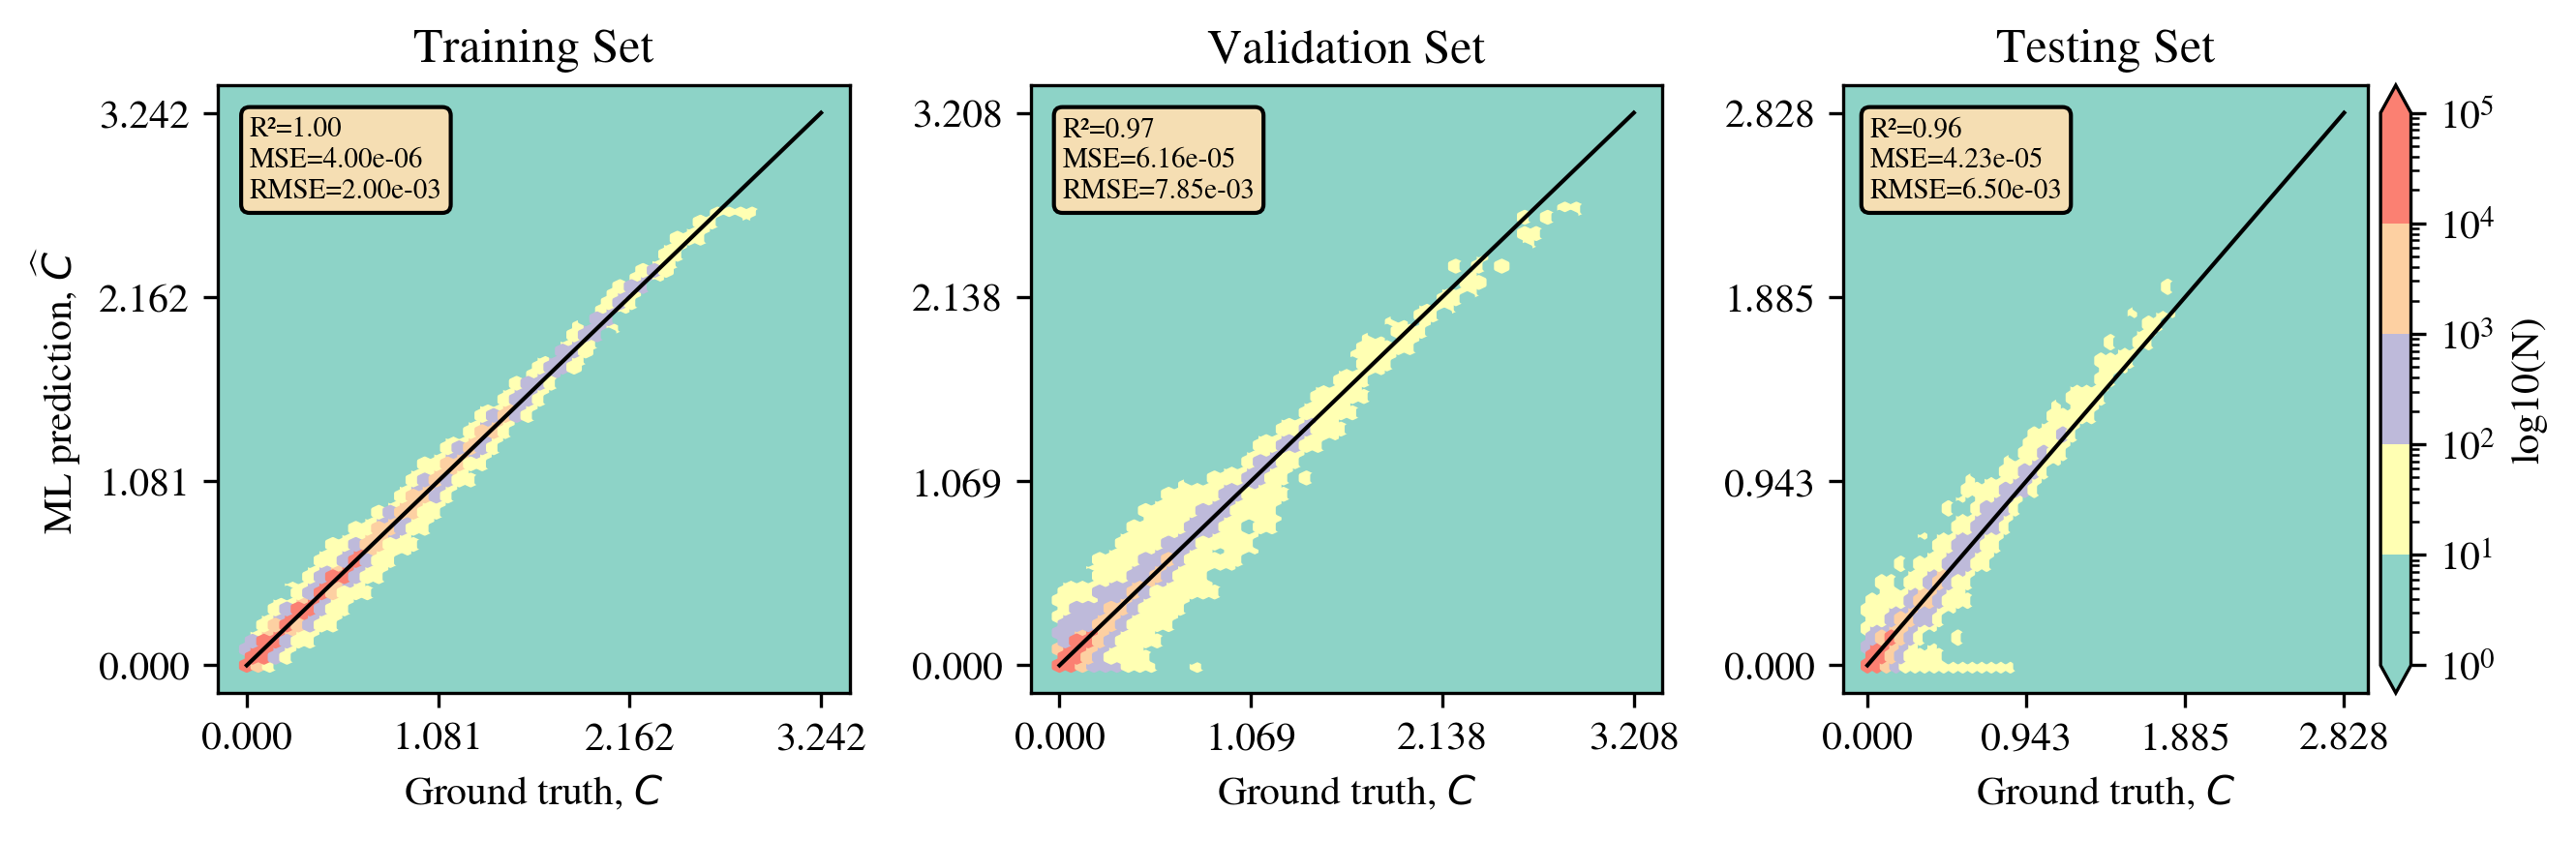

In [40]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

def plot_component_density(train_preds, val_preds, test_preds, train_groundtruth, val_groundtruth, test_groundtruth, component_name, mincnt, gridsize, cmap, vmax):
    f, axes = plt.subplots(1, 3, figsize=(9, 3), dpi=300, sharex=False, sharey=False)
    datasets = [(train_preds, train_groundtruth), (val_preds, val_groundtruth), (test_preds, test_groundtruth)]

    # Calculate the global min and max density for color scale normalization
    # density_values = []
    # for pred, groundtruth in datasets:
    #     density, xedges, yedges = np.histogram2d(groundtruth.flatten(), pred.flatten(), bins=50)
    #     density_values.append(density)
    
    # non_zero_minima = [d[d > 0].min() for d in density_values if np.any(d > 0)]
    # if non_zero_minima:  # Check if the list is non-empty
    #     global_density_min = np.min(non_zero_minima)
    #     global_density_max = np.max([d.max() for d in density_values])
    # else:
    #     raise ValueError("All densities are zero. Cannot set global min and max.")

    # Hexbin plots
    for i, (pred, groundtruth) in enumerate(datasets):
        ax = axes[i]
        # hb = ax.hexbin(groundtruth, pred, gridsize=gridsize, cmap='inferno', bins='log', 
        #                vmin=global_density_min, vmax=global_density_max, mincnt=mincnt)
        hb = ax.hexbin(groundtruth, pred, gridsize=gridsize, cmap=cmap, bins='log', 
                       vmin=mincnt, vmax=vmax, mincnt=mincnt)

        	
        cmap_instance = plt.get_cmap(cmap)
        background_color = cmap_instance(0.0)  # Assumes vmin color is at the zero point of the colormap
        ax.set_facecolor(background_color)

        
        # Identity line
        min_val_truth, max_val_truth = min(groundtruth), max(groundtruth)
        ax.plot([min_val_truth, max_val_truth], [min_val_truth, max_val_truth], 'k-', zorder=5)
        
        # Labels and title
        ax.set_xlabel(f'Ground truth, ${component_name}$')
        if i == 0:  # Set y-label for the first subplot
            ax.set_ylabel(f'ML prediction, $\widehat{{{component_name}}}$')
        ax.set_title(['Training Set', 'Validation Set', 'Testing Set'][i])
        
        # Set tick positions
        # if i == 0:
        min_val, max_val = min(np.min(groundtruth), np.min(pred)), max(np.max(groundtruth), np.max(pred))
        xticks = np.linspace(min_val, max_val, 4)
        ax.set_xticks(xticks)
        ax.set_yticks(xticks)
        
        # Metrics
        R2 = r2_score(groundtruth, pred)
        mse = mean_squared_error(groundtruth, pred)
        rmse = np.sqrt(mse)
        # medpe = np.median(np.abs((groundtruth - pred) / groundtruth) * 1000)
        
        # Text box for metrics
        # props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        # ax.text(0.05, 0.95, f'R²={R2:.2f}\nMSE={mse:.2e}\nRMSE={rmse:.2e}\nMedPE={medpe:.2f}%', 
        #         transform=ax.transAxes, fontsize=7, verticalalignment='top', bbox=props)
        props = dict(boxstyle='round', facecolor='wheat', alpha=1.0)
        ax.text(0.05, 0.95, f'R²={R2:.2f}\nMSE={mse:.2e}\nRMSE={rmse:.2e}', 
        transform=ax.transAxes, fontsize=7, verticalalignment='top', bbox=props)


    # Now, add the colorbar
    # cb = f.colorbar(hb, ax=axes.ravel().tolist(), pad=0.01)
    cb = f.colorbar(hb, ax=ax, pad=0.02, extend='both')
    cb.set_label('log10(N)')
    plt.tight_layout()
    # plot_save_path = os.path.join(specific_note_dir, f'component_density_{component_name}_{mincnt}mincnt_noinletoroutlet_10coarse_{gridsize}gridsize_noshade.png')
    plot_save_path = os.path.join(specific_note_dir, f'component_density_{component_name}_{mincnt}mincnt_cmap_coarse10.png')
    plt.savefig(plot_save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close('all')

from matplotlib.colors import ListedColormap

original_cmap = plt.get_cmap('Set3')
first_color = original_cmap.colors[0]
second_color = original_cmap.colors[1]
third_color = original_cmap.colors[2]
last_color = original_cmap.colors[3]
# forth_color = plt.get_cmap('tab20b').colors[8]
forth_color = plt.get_cmap('tab20c').colors[7]

cmap = ListedColormap([first_color, second_color, third_color, forth_color, last_color])

vmax = 100000
gridsize = 50
mincnt = 1
plot_component_density(train_preds[:, 0], val_preds[:, 0], test_preds[:, 0],
                       train_groundtruth[:, 0], val_groundtruth[:, 0], test_groundtruth[:, 0],
                       'C', mincnt, gridsize, cmap, vmax)

In [ ]:
# del train_preds, val_preds, test_preds
# del train_groundtruth, val_groundtruth, test_groundtruth

# Test 2Dcontour at a specific time

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.animation import FFMpegWriter
from matplotlib.gridspec import GridSpec
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.ticker import FormatStrFormatter
from matplotlib.animation import FFMpegWriter
import matplotlib.image as mpimg
import re
from IPython.display import Video
import matplotlib.tri as tri

In [ ]:
def plot_XYcrosssection_all_components(u_data_, c_data_, t_data_, y_data, s_data, time_index, x1, x2, x3, x4, x5, vmax=None):
    # Define the range for x, y, and z for the cross-section
    xmin, xmax = 0.042202, 2.49111
    ymin, ymax = -1.40139, -0.03

    # Create a grid of x, y values
    x_range = np.linspace(xmin, xmax, num=500)
    y_range = np.linspace(ymin, ymax, num=500)
    z_value = 0.0  # Cross-section at z = 0
    X, Y = np.meshgrid(x_range, y_range)
    coordinates = np.vstack([X.ravel(), Y.ravel()]).T
    coordinates = np.insert(coordinates, 2, z_value, axis=1)

    # Filter out the dead zones
    mask = ~(((coordinates[:, 0] >= xmin) & (coordinates[:, 0] <= 0.912) & (coordinates[:, 1] >= ymin) & (coordinates[:, 1] <= -0.19)) |
             ((coordinates[:, 0] >= 2.122) & (coordinates[:, 0] <= xmax) & (coordinates[:, 1] >= ymin) & (coordinates[:, 1] <= -0.19)))
    filtered_coordinates = coordinates[mask]
    
    y_input = y_scaler.transform(filtered_coordinates).reshape([1, 1, 1, -1, y_data.shape[-1]])
    y_input_ = torch.tensor(y_input, dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        prediction = model(u_data_, c_data_, t_data_, y_input_)
    prediction_np = prediction.cpu().numpy()
    prediction_np = s_scaler.inverse_transform(prediction_np.reshape(-1, prediction_np.shape[-1])).reshape([-1,prediction_np.shape[-1]])
    masked_prediction = np.zeros(X.size)

    true_solution_data = s_data.reshape([-1,s_data.shape[-1]])
    true_solution_interpolated = griddata(y_data.reshape(-1, y_data.shape[-1]), true_solution_data, filtered_coordinates, method='linear')
    masked_true_solution = np.zeros(X.size)

    # Find NaN indices and zero them in prediction_np
    nan_indices = np.isnan(true_solution_interpolated)
    true_solution_interpolated[nan_indices] = 0 # Zeroing out NaNs in prediction
    prediction_np[nan_indices] = 0  # Zeroing out NaNs in prediction
        
    masked_error = np.zeros(X.size)

    fig = plt.figure(figsize=(20, 20), dpi=300)
    gs = GridSpec(4, 5, width_ratios=[0.05, 1, 1, 1, 0.05])  # The last ratio is for the colorbar



    for component in range(s_data.shape[-1]):  # Loop through each component
        print(prediction_np.shape,true_solution_interpolated.shape)
        prediction_component = prediction_np[:,component]
        true_solution_interpolated_component=true_solution_interpolated[:,component]
        
        masked_prediction[mask] = prediction_component
        masked_true_solution[mask] = true_solution_interpolated_component
        error = np.abs(masked_prediction - masked_true_solution)

        vmin = min(np.nanmin(masked_prediction), np.nanmin(masked_true_solution))

        if vmax is None:
            vmax = max(np.nanmax(masked_prediction), np.nanmax(masked_true_solution))
        
        
        triangulation = tri.Triangulation(X.ravel(), Y.ravel())

        cbar_ax = fig.add_subplot(gs[5*component])
        ax_real = fig.add_subplot(gs[5*component+1])
        ax_pred = fig.add_subplot(gs[5*component+2], sharey=ax_real)
        ax_error = fig.add_subplot(gs[5*component+3], sharey=ax_real)
        cbar_ax_error = fig.add_subplot(gs[5*component+4])
    
        ax_real.tricontourf(triangulation, masked_true_solution.ravel(), levels=100, cmap='viridis', vmin=vmin, vmax=vmax)
        ax_real.set_title(f'True Solution for Component {component}')
        ax_pred.tricontourf(triangulation, masked_prediction, levels=100, cmap='viridis', vmin=vmin, vmax=vmax)
        ax_pred.set_title(f'Prediction for Component {component}')
        ax_error.tricontourf(triangulation, error.ravel(), levels=100, cmap='Greys_r')
        ax_error.set_title('Error Contour')

        sm = ScalarMappable(cmap='viridis', norm=Normalize(vmin=vmin, vmax=vmax))
        sm.set_array([])
        cbar_real = fig.colorbar(sm, cax=cbar_ax, label=f'{component}', location='left')
        cbar_real.ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
        cbar_real.set_ticks(np.linspace(vmin, vmax, num=5))

        sm_error = ScalarMappable(cmap='Greys_r', norm=Normalize(vmin=0, vmax=error.max()))
        sm_error.set_array([])
        cbar_error = fig.colorbar(sm_error, cax=cbar_ax_error, label='Error', location='left')
        cbar_error.ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
        cbar_error.set_ticks(np.linspace(0, error.max(), num=5))

        # norm = Normalize(vmin=vmin, vmax=vmax)
        # cmap = plt.get_cmap('viridis')
        # sm = ScalarMappable(cmap=cmap, norm=norm)
        # sm.set_array([])  # You can set an empty array since the actual data is not used
        # cbar_real = fig.colorbar(sm, cax=cbar_ax1, label=f'{component}', location='left')
        # cbar_real.ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        # cbar_real_ticks = np.linspace(vmin, vmax, num=5)
        # cbar_real.set_ticks(cbar_real_ticks)
    #     cbar_real.set_ticklabels([f'{tick:.3f}' for tick in cbar_real_ticks])
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3)  # Adjust this value as needed
    # Save the figure
    filename = f"contours_{time_index}.png"
    directory_path = os.path.join(specific_note_dir, 'contours', f'{x1}_{x2}_{x3}_{x4}_{x5}_case')
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
    full_path = os.path.join(directory_path, filename)
    plt.savefig(full_path, dpi=300, bbox_inches='tight')
    plt.show()

        
def plot_YZcrosssection_all_components(u_data_, c_data_, t_data_, y_data, s_data, time_index):
    # Define the range for x, y, and z for the cross-section
    zmin, zmax = -0.604361, 0.604361
    ymin, ymax = -1.40139, -0.03

    # Create a grid of x, y values
    z_range = np.linspace(zmin, zmax, num=100)
    y_range = np.linspace(ymin, ymax, num=100)

    x_value = 1.5
    Y, Z = np.meshgrid(y_range, z_range)
    coordinates = np.vstack([Y.ravel(), Z.ravel()]).T
    coordinates = np.insert(coordinates, 0, x_value, axis=1)
    # print(coordinates.shape)

    y_input = y_scaler.transform(coordinates).reshape([1, 1, 1, -1, y_data.shape[-1]])
    y_input_ = torch.tensor(y_input, dtype=torch.float32).to(device)
    # print(y_input_.shape)
    model.eval()
    with torch.no_grad():
        prediction = model(u_data_, c_data_, t_data_, y_input_)
    prediction_np = prediction.cpu().numpy()
    prediction_np = s_scaler.inverse_transform(prediction_np.reshape(-1, prediction_np.shape[-1])).reshape([-1,prediction_np.shape[-1]])

    true_solution_data = s_data.reshape([-1,s_data.shape[-1]])
    true_solution_interpolated = griddata(y_data.reshape(-1, y_data.shape[-1]), true_solution_data, coordinates, method='linear')
    
    # Find NaN indices and zero them in prediction_np
    nan_indices = np.isnan(true_solution_interpolated)
    true_solution_interpolated[nan_indices] = 0 # Zeroing out NaNs in prediction
    prediction_np[nan_indices] = 0  # Zeroing out NaNs in prediction

    fig = plt.figure(figsize=(20, 20), dpi=300)
    gs = GridSpec(4, 5, width_ratios=[0.05, 1, 1, 1, 0.05])  # The last ratio is for the colorbar
    
    for component in range(s_data.shape[-1]):  # Loop through each component
        # print(prediction_np.shape,true_solution_interpolated.shape)
        prediction_component = prediction_np[:,component]
        true_solution_interpolated_component=true_solution_interpolated[:,component]
        # print(prediction_component.shape, true_solution_interpolated_component.shape)


        error = np.abs(prediction_component - true_solution_interpolated_component)

        vmin = min(np.nanmin(prediction_component), np.nanmin(true_solution_interpolated_component))
        vmax = max(np.nanmax(prediction_component), np.nanmax(true_solution_interpolated_component))
        
        triangulation = tri.Triangulation(Z.ravel(), Y.ravel())

        cbar_ax = fig.add_subplot(gs[5*component])
        ax_real = fig.add_subplot(gs[5*component+1])
        ax_pred = fig.add_subplot(gs[5*component+2], sharey=ax_real)
        ax_error = fig.add_subplot(gs[5*component+3], sharey=ax_real)
        cbar_ax_error = fig.add_subplot(gs[5*component+4])
        
        # print(prediction_component, true_solution_interpolated_component)
        
        ax_real.pcolormesh(triangulation, true_solution_interpolated_component.ravel(), levels=100, cmap='viridis', vmin=vmin, vmax=vmax)
        ax_real.set_title(f'True Solution for Component {component}')
        ax_pred.pcolormesh(triangulation, prediction_component.ravel(), levels=100, cmap='viridis', vmin=vmin, vmax=vmax)
        ax_pred.set_title(f'Prediction for Component {component}')
        ax_error.pcolormesh(triangulation, error.ravel(), levels=100, cmap='Greys_r')
        ax_error.set_title('Error Contour')

        sm = ScalarMappable(cmap='viridis', norm=Normalize(vmin=vmin, vmax=vmax))
        sm.set_array([])
        cbar_real = fig.colorbar(sm, cax=cbar_ax, label=f'{component}', location='left')
        cbar_real.ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
        cbar_real.set_ticks(np.linspace(vmin, vmax, num=5))

        sm_error = ScalarMappable(cmap='Greys_r', norm=Normalize(vmin=0, vmax=error.max()))
        sm_error.set_array([])
        cbar_error = fig.colorbar(sm_error, cax=cbar_ax_error, label='Error', location='left')
        cbar_error.ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
        cbar_error.set_ticks(np.linspace(0, error.max(), num=5))

        # norm = Normalize(vmin=vmin, vmax=vmax)
        # cmap = plt.get_cmap('viridis')
        # sm = ScalarMappable(cmap=cmap, norm=norm)
        # sm.set_array([])  # You can set an empty array since the actual data is not used
        # cbar_real = fig.colorbar(sm, cax=cbar_ax1, label=f'{component}', location='left')
        # cbar_real.ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        # cbar_real_ticks = np.linspace(vmin, vmax, num=5)
        # cbar_real.set_ticks(cbar_real_ticks)
    #     cbar_real.set_ticklabels([f'{tick:.3f}' for tick in cbar_real_ticks])
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3)  # Adjust this value as needed
    # Save the figure
    filename = f"contours_{time_index}.png"
    full_path = os.path.join(specific_note_dir, filename)
    plt.savefig(full_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_XZcrosssection_all_components(y_value, u_data_, c_data_, t_data_, y_data, s_data, time_index):
    # Define the range for x, y, and z for the cross-section
    xmin, xmax  = -0.912, 2.122
    # zmin, zmax = -.604361, 0.604361
    zmin, zmax = -0.6, 0.6

    # Create a grid of x, y values
    x_range = np.linspace(xmin, xmax, num=1000) 

    z_range = np.linspace(zmin, zmax, num=1000) 

    X, Z = np.meshgrid(x_range, z_range)

    center_x, center_z = 1.517, 0 
    radius = .59 
    distances = np.sqrt((X - center_x)**2 + (Z - center_z)**2) 

    # Apply the circular mask 

    mask = distances <= radius 

    coordinates = np.vstack([X[mask].ravel(), Z[mask].ravel()]).T 
    coordinates = np.insert(coordinates, 1, y_value, axis=1)  # Insert y_value as the second column 
    
    y_input = y_scaler.transform(coordinates).reshape([1, 1, 1, -1, y_data.shape[-1]])
    y_input_ = torch.tensor(y_input, dtype=torch.float32).to(device)
    # print(y_input_.shape)
    model.eval()
    with torch.no_grad():
        prediction = model(u_data_, c_data_, t_data_, y_input_)
    prediction_np = prediction.cpu().numpy()
    prediction_np = s_scaler.inverse_transform(prediction_np.reshape(-1, prediction_np.shape[-1])).reshape([-1,prediction_np.shape[-1]])

    true_solution_data = s_data.reshape([-1,s_data.shape[-1]])
    true_solution_interpolated = griddata(y_data.reshape(-1, y_data.shape[-1]), true_solution_data, coordinates, method='linear')

    # Find NaN indices and zero them in prediction_np
    nan_indices = np.isnan(true_solution_interpolated)
    true_solution_interpolated[nan_indices] = 0 # Zeroing out NaNs in prediction
    prediction_np[nan_indices] = 0  # Zeroing out NaNs in prediction
        
    fig = plt.figure(figsize=(20, 20), dpi=300)
    gs = GridSpec(4, 5, width_ratios=[0.05, 1, 1, 1, 0.05])  # The last ratio is for the colorbar
    
    for component in range(s_data.shape[-1]):  # Loop through each component
        # print(prediction_np.shape,true_solution_interpolated.shape)
        prediction_component = prediction_np[:,component]
        true_solution_interpolated_component=true_solution_interpolated[:,component]
        # print(prediction_component.shape, true_solution_interpolated_component.shape)


        error = np.abs(prediction_component - true_solution_interpolated_component)

        vmin = min(np.nanmin(prediction_component), np.nanmin(true_solution_interpolated_component))
        vmax = max(np.nanmax(prediction_component), np.nanmax(true_solution_interpolated_component))
        
        triangulation = tri.Triangulation(X[mask].ravel(), Z[mask].ravel())

        cbar_ax = fig.add_subplot(gs[5*component])
        ax_real = fig.add_subplot(gs[5*component+1])
        ax_pred = fig.add_subplot(gs[5*component+2], sharey=ax_real)
        ax_error = fig.add_subplot(gs[5*component+3], sharey=ax_real)
        cbar_ax_error = fig.add_subplot(gs[5*component+4])
        
        # print(prediction_component, true_solution_interpolated_component)
        
        ax_real.tricontourf(triangulation, true_solution_interpolated_component.ravel(), levels=100, cmap='viridis', vmin=vmin, vmax=vmax)
        ax_real.set_title(f'True Solution for Component {component}')
        ax_pred.tricontourf(triangulation, prediction_component.ravel(), levels=100, cmap='viridis', vmin=vmin, vmax=vmax)
        ax_pred.set_title(f'Prediction for Component {component}')
        ax_error.tricontourf(triangulation, error.ravel(), levels=100, cmap='Greys_r')
        ax_error.set_title('Error Contour')

        sm = ScalarMappable(cmap='viridis', norm=Normalize(vmin=vmin, vmax=vmax))
        sm.set_array([])
        cbar_real = fig.colorbar(sm, cax=cbar_ax, label=f'{component}', location='left')
        cbar_real.ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
        cbar_real.set_ticks(np.linspace(vmin, vmax, num=5))

        sm_error = ScalarMappable(cmap='Greys_r', norm=Normalize(vmin=0, vmax=error.max()))
        sm_error.set_array([])
        cbar_error = fig.colorbar(sm_error, cax=cbar_ax_error, label='Error', location='left')
        cbar_error.ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
        cbar_error.set_ticks(np.linspace(0, error.max(), num=5))

        # norm = Normalize(vmin=vmin, vmax=vmax)
        # cmap = plt.get_cmap('viridis')
        # sm = ScalarMappable(cmap=cmap, norm=norm)
        # sm.set_array([])  # You can set an empty array since the actual data is not used
        # cbar_real = fig.colorbar(sm, cax=cbar_ax1, label=f'{component}', location='left')
        # cbar_real.ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        # cbar_real_ticks = np.linspace(vmin, vmax, num=5)
        # cbar_real.set_ticks(cbar_real_ticks)
    #     cbar_real.set_ticklabels([f'{tick:.3f}' for tick in cbar_real_ticks])
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3)  # Adjust this value as needed
    # Save the figure
    filename = f"contours_{time_index}.png"
    full_path = os.path.join(specific_note_dir, filename)
    plt.savefig(full_path, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
def plot_XYcrosssection_all_components(u_data_, c_data_, t_data_, y_data, s_data, time_index, x1, x2, x3, x4, x5, vmax=None):
    # Define the range for x, y, and z for the cross-section
    xmin, xmax = 0.042202, 2.49111
    ymin, ymax = -1.40139, -0.03

    # Create a grid of x, y values
    x_range = np.linspace(xmin, xmax, num=500)
    y_range = np.linspace(ymin, ymax, num=500)
    z_value = 0.0  # Cross-section at z = 0
    X, Y = np.meshgrid(x_range, y_range)
    coordinates = np.vstack([X.ravel(), Y.ravel()]).T
    coordinates = np.insert(coordinates, 2, z_value, axis=1)

    # Filter out the dead zones
    mask = ~(((coordinates[:, 0] >= xmin) & (coordinates[:, 0] <= 0.912) & (coordinates[:, 1] >= ymin) & (coordinates[:, 1] <= -0.19)) |
             ((coordinates[:, 0] >= 2.122) & (coordinates[:, 0] <= xmax) & (coordinates[:, 1] >= ymin) & (coordinates[:, 1] <= -0.19)))
    filtered_coordinates = coordinates[mask]
    
    y_input = y_scaler.transform(filtered_coordinates).reshape([1, 1, 1, -1, y_data.shape[-1]])
    y_input_ = torch.tensor(y_input, dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        prediction = model(u_data_, c_data_, t_data_, y_input_)
    prediction_np = prediction.cpu().numpy()
    prediction_np = s_scaler.inverse_transform(prediction_np.reshape(-1, prediction_np.shape[-1])).reshape([-1,prediction_np.shape[-1]])
    masked_prediction = np.zeros(X.size)

    true_solution_data = s_data.reshape([-1,s_data.shape[-1]])
    true_solution_interpolated = griddata(y_data.reshape(-1, y_data.shape[-1]), true_solution_data, filtered_coordinates, method='linear')
    masked_true_solution = np.zeros(X.size)

    # Find NaN indices and zero them in prediction_np
    nan_indices = np.isnan(true_solution_interpolated)
    true_solution_interpolated[nan_indices] = 0 # Zeroing out NaNs in prediction
    prediction_np[nan_indices] = 0  # Zeroing out NaNs in prediction
        
    masked_error = np.zeros(X.size)

    fig = plt.figure(figsize=(20, 20), dpi=300)
    gs = GridSpec(4, 5, width_ratios=[0.05, 1, 1, 1, 0.05])  # The last ratio is for the colorbar



    for component in range(s_data.shape[-1]):  # Loop through each component
        print(prediction_np.shape,true_solution_interpolated.shape)
        prediction_component = prediction_np[:,component]
        true_solution_interpolated_component=true_solution_interpolated[:,component]
        
        masked_prediction[mask] = prediction_component
        masked_true_solution[mask] = true_solution_interpolated_component
        error = np.abs(masked_prediction - masked_true_solution)

        vmin = min(np.nanmin(masked_prediction), np.nanmin(masked_true_solution))

        if vmax is None:
            vmax = max(np.nanmax(masked_prediction), np.nanmax(masked_true_solution))
        
        
        triangulation = tri.Triangulation(X.ravel(), Y.ravel())

        cbar_ax = fig.add_subplot(gs[5*component])
        ax_real = fig.add_subplot(gs[5*component+1])
        ax_pred = fig.add_subplot(gs[5*component+2], sharey=ax_real)
        ax_error = fig.add_subplot(gs[5*component+3], sharey=ax_real)
        cbar_ax_error = fig.add_subplot(gs[5*component+4])
    
        ax_real.tricontourf(triangulation, masked_true_solution.ravel(), levels=100, cmap='viridis', vmin=vmin, vmax=vmax)
        ax_real.set_title(f'True Solution for Component {component}')
        ax_pred.tricontourf(triangulation, masked_prediction, levels=100, cmap='viridis', vmin=vmin, vmax=vmax)
        ax_pred.set_title(f'Prediction for Component {component}')
        ax_error.tricontourf(triangulation, error.ravel(), levels=100, cmap='Greys_r')
        ax_error.set_title('Error Contour')

        sm = ScalarMappable(cmap='viridis', norm=Normalize(vmin=vmin, vmax=vmax))
        sm.set_array([])
        cbar_real = fig.colorbar(sm, cax=cbar_ax, label=f'{component}', location='left')
        cbar_real.ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
        cbar_real.set_ticks(np.linspace(vmin, vmax, num=5))

        sm_error = ScalarMappable(cmap='Greys_r', norm=Normalize(vmin=0, vmax=error.max()))
        sm_error.set_array([])
        cbar_error = fig.colorbar(sm_error, cax=cbar_ax_error, label='Error', location='left')
        cbar_error.ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
        cbar_error.set_ticks(np.linspace(0, error.max(), num=5))

        # norm = Normalize(vmin=vmin, vmax=vmax)
        # cmap = plt.get_cmap('viridis')
        # sm = ScalarMappable(cmap=cmap, norm=norm)
        # sm.set_array([])  # You can set an empty array since the actual data is not used
        # cbar_real = fig.colorbar(sm, cax=cbar_ax1, label=f'{component}', location='left')
        # cbar_real.ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        # cbar_real_ticks = np.linspace(vmin, vmax, num=5)
        # cbar_real.set_ticks(cbar_real_ticks)
    #     cbar_real.set_ticklabels([f'{tick:.3f}' for tick in cbar_real_ticks])
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3)  # Adjust this value as needed
    # Save the figure
    filename = f"contours_{time_index}.png"
    directory_path = os.path.join(specific_note_dir, 'contours', f'{x1}_{x2}_{x3}_{x4}_{x5}_case')
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
    full_path = os.path.join(directory_path, filename)
    plt.savefig(full_path, dpi=300, bbox_inches='tight')
    plt.show()

        
def plot_YZcrosssection_all_components(u_data_, c_data_, t_data_, y_data, s_data, time_index):
    # Define the range for x, y, and z for the cross-section
    zmin, zmax = -0.604361, 0.604361
    ymin, ymax = -1.40139, -0.03

    # Create a grid of x, y values
    z_range = np.linspace(zmin, zmax, num=100)
    y_range = np.linspace(ymin, ymax, num=100)

    x_value = 1.5
    Y, Z = np.meshgrid(y_range, z_range)
    coordinates = np.vstack([Y.ravel(), Z.ravel()]).T
    coordinates = np.insert(coordinates, 0, x_value, axis=1)
    # print(coordinates.shape)

    y_input = y_scaler.transform(coordinates).reshape([1, 1, 1, -1, y_data.shape[-1]])
    y_input_ = torch.tensor(y_input, dtype=torch.float32).to(device)
    # print(y_input_.shape)
    model.eval()
    with torch.no_grad():
        prediction = model(u_data_, c_data_, t_data_, y_input_)
    prediction_np = prediction.cpu().numpy()
    prediction_np = s_scaler.inverse_transform(prediction_np.reshape(-1, prediction_np.shape[-1])).reshape([-1,prediction_np.shape[-1]])

    true_solution_data = s_data.reshape([-1,s_data.shape[-1]])
    true_solution_interpolated = griddata(y_data.reshape(-1, y_data.shape[-1]), true_solution_data, coordinates, method='linear')
    
    # Find NaN indices and zero them in prediction_np
    nan_indices = np.isnan(true_solution_interpolated)
    true_solution_interpolated[nan_indices] = 0 # Zeroing out NaNs in prediction
    prediction_np[nan_indices] = 0  # Zeroing out NaNs in prediction

    fig = plt.figure(figsize=(20, 20), dpi=300)
    gs = GridSpec(4, 5, width_ratios=[0.05, 1, 1, 1, 0.05])  # The last ratio is for the colorbar
    
    for component in range(s_data.shape[-1]):  # Loop through each component
        # print(prediction_np.shape,true_solution_interpolated.shape)
        prediction_component = prediction_np[:,component]
        true_solution_interpolated_component=true_solution_interpolated[:,component]
        # print(prediction_component.shape, true_solution_interpolated_component.shape)


        error = np.abs(prediction_component - true_solution_interpolated_component)

        vmin = min(np.nanmin(prediction_component), np.nanmin(true_solution_interpolated_component))
        vmax = max(np.nanmax(prediction_component), np.nanmax(true_solution_interpolated_component))
        
        triangulation = tri.Triangulation(Z.ravel(), Y.ravel())

        cbar_ax = fig.add_subplot(gs[5*component])
        ax_real = fig.add_subplot(gs[5*component+1])
        ax_pred = fig.add_subplot(gs[5*component+2], sharey=ax_real)
        ax_error = fig.add_subplot(gs[5*component+3], sharey=ax_real)
        cbar_ax_error = fig.add_subplot(gs[5*component+4])
        
        # print(prediction_component, true_solution_interpolated_component)
        
        ax_real.imshow(Z, Y, true_solution_interpolated_component.reshape(Y.shape), cmap='viridis', vmin=vmin, vmax=vmax)
        ax_real.set_title(f'True Solution for Component {component}')
        ax_pred.imshow(Z, Y, prediction_component.reshape(Y.shape), cmap='viridis', vmin=vmin, vmax=vmax)
        ax_pred.set_title(f'Prediction for Component {component}')
        ax_error.imshow(Z, Y, error.reshape(Y.shape), cmap='Greys_r')
        ax_error.set_title('Error Contour')

        sm = ScalarMappable(cmap='viridis', norm=Normalize(vmin=vmin, vmax=vmax))
        sm.set_array([])
        cbar_real = fig.colorbar(sm, cax=cbar_ax, label=f'{component}', location='left')
        cbar_real.ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
        cbar_real.set_ticks(np.linspace(vmin, vmax, num=5))

        sm_error = ScalarMappable(cmap='Greys_r', norm=Normalize(vmin=0, vmax=error.max()))
        sm_error.set_array([])
        cbar_error = fig.colorbar(sm_error, cax=cbar_ax_error, label='Error', location='left')
        cbar_error.ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
        cbar_error.set_ticks(np.linspace(0, error.max(), num=5))

        # norm = Normalize(vmin=vmin, vmax=vmax)
        # cmap = plt.get_cmap('viridis')
        # sm = ScalarMappable(cmap=cmap, norm=norm)
        # sm.set_array([])  # You can set an empty array since the actual data is not used
        # cbar_real = fig.colorbar(sm, cax=cbar_ax1, label=f'{component}', location='left')
        # cbar_real.ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        # cbar_real_ticks = np.linspace(vmin, vmax, num=5)
        # cbar_real.set_ticks(cbar_real_ticks)
    #     cbar_real.set_ticklabels([f'{tick:.3f}' for tick in cbar_real_ticks])
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3)  # Adjust this value as needed
    # Save the figure
    filename = f"contours_{time_index}.png"
    full_path = os.path.join(specific_note_dir, filename)
    plt.savefig(full_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_XZcrosssection_all_components(y_value, u_data_, c_data_, t_data_, y_data, s_data, time_index):
    # Define the range for x, y, and z for the cross-section
    xmin, xmax  = -0.912, 2.122
    # zmin, zmax = -.604361, 0.604361
    zmin, zmax = -0.6, 0.6

    # Create a grid of x, y values
    x_range = np.linspace(xmin, xmax, num=1000) 

    z_range = np.linspace(zmin, zmax, num=1000) 

    X, Z = np.meshgrid(x_range, z_range)

    center_x, center_z = 1.517, 0 
    radius = .59 
    distances = np.sqrt((X - center_x)**2 + (Z - center_z)**2) 

    # Apply the circular mask 

    mask = distances <= radius 

    coordinates = np.vstack([X[mask].ravel(), Z[mask].ravel()]).T 
    coordinates = np.insert(coordinates, 1, y_value, axis=1)  # Insert y_value as the second column 
    
    y_input = y_scaler.transform(coordinates).reshape([1, 1, 1, -1, y_data.shape[-1]])
    y_input_ = torch.tensor(y_input, dtype=torch.float32).to(device)
    # print(y_input_.shape)
    model.eval()
    with torch.no_grad():
        prediction = model(u_data_, c_data_, t_data_, y_input_)
    prediction_np = prediction.cpu().numpy()
    prediction_np = s_scaler.inverse_transform(prediction_np.reshape(-1, prediction_np.shape[-1])).reshape([-1,prediction_np.shape[-1]])

    true_solution_data = s_data.reshape([-1,s_data.shape[-1]])
    true_solution_interpolated = griddata(y_data.reshape(-1, y_data.shape[-1]), true_solution_data, coordinates, method='linear')

    # Find NaN indices and zero them in prediction_np
    nan_indices = np.isnan(true_solution_interpolated)
    true_solution_interpolated[nan_indices] = 0 # Zeroing out NaNs in prediction
    prediction_np[nan_indices] = 0  # Zeroing out NaNs in prediction
        
    fig = plt.figure(figsize=(20, 20), dpi=300)
    gs = GridSpec(4, 5, width_ratios=[0.05, 1, 1, 1, 0.05])  # The last ratio is for the colorbar
    
    for component in range(s_data.shape[-1]):  # Loop through each component
        # print(prediction_np.shape,true_solution_interpolated.shape)
        prediction_component = prediction_np[:,component]
        true_solution_interpolated_component=true_solution_interpolated[:,component]
        # print(prediction_component.shape, true_solution_interpolated_component.shape)


        error = np.abs(prediction_component - true_solution_interpolated_component)

        vmin = min(np.nanmin(prediction_component), np.nanmin(true_solution_interpolated_component))
        vmax = max(np.nanmax(prediction_component), np.nanmax(true_solution_interpolated_component))
        
        triangulation = tri.Triangulation(X[mask].ravel(), Z[mask].ravel())

        cbar_ax = fig.add_subplot(gs[5*component])
        ax_real = fig.add_subplot(gs[5*component+1])
        ax_pred = fig.add_subplot(gs[5*component+2], sharey=ax_real)
        ax_error = fig.add_subplot(gs[5*component+3], sharey=ax_real)
        cbar_ax_error = fig.add_subplot(gs[5*component+4])
        
        # print(prediction_component, true_solution_interpolated_component)
        
        ax_real.imshow(X[mask], Z[mask], true_solution_interpolated_component.reshape(X[mask].shape), levels=100, cmap='viridis', vmin=vmin, vmax=vmax)
        ax_real.set_title(f'True Solution for Component {component}')
        ax_pred.imshow(X[mask], Z[mask], prediction_component.reshape(X[mask].shape), levels=100, cmap='viridis', vmin=vmin, vmax=vmax)
        ax_pred.set_title(f'Prediction for Component {component}')
        ax_error.imshow(X[mask], Z[mask], error.reshape(X[mask].shape), levels=100, cmap='Greys_r')
        ax_error.set_title('Error Contour')

        sm = ScalarMappable(cmap='viridis', norm=Normalize(vmin=vmin, vmax=vmax))
        sm.set_array([])
        cbar_real = fig.colorbar(sm, cax=cbar_ax, label=f'{component}', location='left')
        cbar_real.ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
        cbar_real.set_ticks(np.linspace(vmin, vmax, num=5))

        sm_error = ScalarMappable(cmap='Greys_r', norm=Normalize(vmin=0, vmax=error.max()))
        sm_error.set_array([])
        cbar_error = fig.colorbar(sm_error, cax=cbar_ax_error, label='Error', location='left')
        cbar_error.ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
        cbar_error.set_ticks(np.linspace(0, error.max(), num=5))

        # norm = Normalize(vmin=vmin, vmax=vmax)
        # cmap = plt.get_cmap('viridis')
        # sm = ScalarMappable(cmap=cmap, norm=norm)
        # sm.set_array([])  # You can set an empty array since the actual data is not used
        # cbar_real = fig.colorbar(sm, cax=cbar_ax1, label=f'{component}', location='left')
        # cbar_real.ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        # cbar_real_ticks = np.linspace(vmin, vmax, num=5)
        # cbar_real.set_ticks(cbar_real_ticks)
    #     cbar_real.set_ticklabels([f'{tick:.3f}' for tick in cbar_real_ticks])
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3)  # Adjust this value as needed
    # Save the figure
    filename = f"contours_{time_index}.png"
    full_path = os.path.join(specific_note_dir, filename)
    plt.savefig(full_path, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
def analyze_case(case_index, time_index, vmax=None):
    x1, x2, x3, x4, x5 = u_test[case_index, 0, 0, 0, :]
    file_path = '/lustre/isaac/scratch/mshatara/openfoam/mshatarah-v2306/run/3D_real_nonsymetric/Data_extracted/Case_Parameters.csv'
    data = pd.read_csv(file_path)
    tolerance = 1e-4
    print(x1,x2,x3,x4,x5)

    # Find matching row in the dataset
    matching_row = data[(np.isclose(data['k'], x1, atol=tolerance) &
                         np.isclose(data['theta'], x2, atol=tolerance) &
                         np.isclose(data['lambda'], x3, atol=tolerance) &
                         np.isclose(data['C0'], x4, atol=tolerance) &
                         np.isclose(data['kd'], x5, atol=tolerance))]
    
    if not matching_row.empty:
        matching_indices = matching_row.index.tolist()
        if matching_indices:
            case_number = matching_indices[0]+1  
            print("Extracted index:", case_number)
    else:
        print("No matching row found.")
        
    base_dir = '/lustre/isaac/scratch/mshatara/openfoam/mshatarah-v2306/run/3D_real_nonsymetric/Data_extracted/1class/separate_cases_filtered'
    file_name = f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'
    file_path = os.path.join(base_dir, file_name)
    data_arrays = np.load(file_path)


    u_test3 = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))['branch_loading']

    y_test = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))['trunk_coordinates']
    # s_test = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))['sol_u']
    # s_test = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))['sol_v']
    # s_test = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))['sol_w']
    s_test = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))['sol_c']
    print(y_test.shape, s_test.shape)
    print(u_test3, u_test[case_index, 0, 0, 0, :])

    u_case_= u_test_[case_index:case_index+1]
    c_case_= c_test_
    t_case_= t_test_[:,:,time_index:time_index+1]
    print("t_case_", t_case_, "time_index", time_index)
    y_case= y_test
    s_case= s_test[:,:,time_index:time_index+1]

    print('Full dataset sizes', u_case_.shape, c_case_.shape, t_case_.shape, y_case.shape, s_case.shape)
    # Use the modified function with your data
    # plot_XYcrosssection_all_components(u_case_, c_case_, t_case_, y_case, s_case, time_index, x1, x2, x3, x4, x5, vmax)
    plot_YZcrosssection_all_components(u_case_, c_case_, t_case_, y_case, s_case, time_index)
    y_value = -0.1
    plot_XZcrosssection_all_components(y_value, u_case_, c_case_, t_case_, y_case, s_case, time_index)
    # y_value = -0.2
    # plot_XZcrosssection_all_components(y_value, u_case_, c_case_, t_case_, y_case, s_case, time_index)
    # y_value = -0.5
    # plot_XZcrosssection_all_components(y_value, u_case_, c_case_, t_case_, y_case, s_case, time_index)

In [ ]:
def plot_XYcrosssection_all_components(u_data_, c_data_, t_data_, y_data, s_data, time_index, x1, x2, x3, x4, x5, vmax=None):
    # Define the range for x, y, and z for the cross-section
    xmin, xmax = 0.042202, 2.49111
    ymin, ymax = -1.40139, -0.03

    # Create a grid of x, y values
    x_range = np.linspace(xmin, xmax, num=500)
    y_range = np.linspace(ymin, ymax, num=500)
    z_value = 0.0  # Cross-section at z = 0
    X, Y = np.meshgrid(x_range, y_range)
    coordinates = np.vstack([X.ravel(), Y.ravel()]).T
    coordinates = np.insert(coordinates, 2, z_value, axis=1)

    # Filter out the dead zones
    mask = ~(((coordinates[:, 0] >= xmin) & (coordinates[:, 0] <= 0.912) & (coordinates[:, 1] >= ymin) & (coordinates[:, 1] <= -0.19)) |
             ((coordinates[:, 0] >= 2.122) & (coordinates[:, 0] <= xmax) & (coordinates[:, 1] >= ymin) & (coordinates[:, 1] <= -0.19)))
    filtered_coordinates = coordinates[mask]
    
    y_input = y_scaler.transform(filtered_coordinates).reshape([1, 1, 1, -1, y_data.shape[-1]])
    y_input_ = torch.tensor(y_input, dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        prediction = model(u_data_, c_data_, t_data_, y_input_)
    prediction_np = prediction.cpu().numpy()
    prediction_np = s_scaler.inverse_transform(prediction_np.reshape(-1, prediction_np.shape[-1])).reshape([-1,prediction_np.shape[-1]])
    masked_prediction = np.zeros(X.size)

    true_solution_data = s_data.reshape([-1,s_data.shape[-1]])
    true_solution_interpolated = griddata(y_data.reshape(-1, y_data.shape[-1]), true_solution_data, filtered_coordinates, method='linear')
    masked_true_solution = np.zeros(X.size)

    # Find NaN indices and zero them in prediction_np
    nan_indices = np.isnan(true_solution_interpolated)
    true_solution_interpolated[nan_indices] = 0 # Zeroing out NaNs in prediction
    prediction_np[nan_indices] = 0  # Zeroing out NaNs in prediction
        
    masked_error = np.zeros(X.size)

    fig = plt.figure(figsize=(1.5, 4), dpi=300)
    # gs = GridSpec(4, 5, width_ratios=[0.05, 1, 1, 1, 0.05])  # The last ratio is for the colorbar
    gs = GridSpec(3, 1)  # The last ratio is for the colorbar

    for component in range(s_data.shape[-1]):  # Loop through each component
        print(prediction_np.shape,true_solution_interpolated.shape)
        prediction_component = prediction_np[:,component]
        true_solution_interpolated_component=true_solution_interpolated[:,component]
        
        masked_prediction[mask] = prediction_component
        masked_true_solution[mask] = true_solution_interpolated_component

        masked_prediction = np.clip(masked_prediction, 0, None)
        masked_true_solution = np.clip(masked_true_solution, 0, None)
        
        error = np.abs(masked_prediction - masked_true_solution)
        relative_error = np.abs(masked_prediction - masked_true_solution) / np.nanmax(masked_true_solution)
        # print(relative_error)
        print(np.min(relative_error), np.max(relative_error))
        
        # vmin = min(np.nanmin(masked_prediction), np.nanmin(masked_true_solution))
        vmin = 0

        if vmax is None:
            vmax = max(np.nanmax(masked_prediction), np.nanmax(masked_true_solution))
        
        triangulation = tri.Triangulation(X.ravel(), Y.ravel())

        # cbar_ax = fig.add_subplot(gs[5*component])
        ax_real = fig.add_subplot(gs[5*component])
        ax_pred = fig.add_subplot(gs[5*component+1], sharey=ax_real)
        ax_error = fig.add_subplot(gs[5*component+2], sharey=ax_real)
        # cbar_ax_error = fig.add_subplot(gs[5*component+3])

        ax_real.tricontourf(triangulation, masked_true_solution.ravel(), levels=300, cmap='RdYlBu_r', vmin=vmin, vmax=vmax)
        ax_pred.tricontourf(triangulation, masked_prediction, levels=300, cmap='RdYlBu_r', vmin=vmin, vmax=vmax)
        ax_error.tricontourf(triangulation, relative_error.ravel(), levels=300, cmap='Greys_r', vmin=0, vmax=1.0)

        ax_real.text(0.15, 0.45, 'CFD', ha='center', fontsize=9, color='white', transform=ax_real.transAxes)
        ax_pred.text(0.15, 0.45, 'ML', ha='center', fontsize=9, color='white', transform=ax_pred.transAxes)
        ax_error.text(0.15, 0.45, 'Error', ha='center', fontsize=9, color='white', transform=ax_error.transAxes)

        ax_real.axis('off')
        ax_pred.axis('off')
        ax_error.axis('off')
    
    # plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Adjust this value as needed
    # Save the figure
    filename = f"contours_{time_index}_300levels_vertical.png"
    directory_path = os.path.join(specific_note_dir, 'contours', f'{x1}_{x2}_{x3}_{x4}_{x5}_case')
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
    full_path = os.path.join(directory_path, filename)
    plt.savefig(full_path, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
# for time_index in range(10, 360):  # range(28, 31) includes 28, 29, 30
#     analyze_case(16, time_index, None)
#high:16
#medium:1
#low: 38

# analyze_case(16, 29, None)
# analyze_case(1, 36, None)
# analyze_case(38, 44, None)

In [ ]:
# analyze_case(16, 29, None)
# analyze_case(1, 36, None)
# analyze_case(38, 44, None)

In [ ]:
def plot_XYcrosssection_all_components(u_data_, c_data_, t_data_, y_data, s_data, time_index, x1, x2, x3, x4, x5, cmap, vmax=None):
    # Define the range for x, y, and z for the cross-section
    xmin, xmax = 0.042202, 2.49111
    ymin, ymax = -1.40139, -0.03

    # Create a grid of x, y values
    x_range = np.linspace(xmin, xmax, num=100)
    y_range = np.linspace(ymin, ymax, num=100)
    z_value = 0.0  # Cross-section at z = 0
    X, Y = np.meshgrid(x_range, y_range)
    coordinates = np.vstack([X.ravel(), Y.ravel()]).T
    coordinates = np.insert(coordinates, 2, z_value, axis=1)

    # Filter out the dead zones
    mask = ~(((coordinates[:, 0] >= xmin) & (coordinates[:, 0] <= 0.912) & (coordinates[:, 1] >= ymin) & (coordinates[:, 1] <= -0.19)) |
             ((coordinates[:, 0] >= 2.122) & (coordinates[:, 0] <= xmax) & (coordinates[:, 1] >= ymin) & (coordinates[:, 1] <= -0.19)))
    filtered_coordinates = coordinates[mask]
    
    y_input = y_scaler.transform(filtered_coordinates).reshape([1, 1, 1, -1, y_data.shape[-1]])
    y_input_ = torch.tensor(y_input, dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        prediction = model(u_data_, c_data_, t_data_, y_input_)
    prediction_np = prediction.cpu().numpy()
    prediction_np = s_scaler.inverse_transform(prediction_np.reshape(-1, prediction_np.shape[-1])).reshape([-1,prediction_np.shape[-1]])
    masked_prediction = np.zeros(X.size)

    true_solution_data = s_data.reshape([-1,s_data.shape[-1]])
    true_solution_interpolated = griddata(y_data.reshape(-1, y_data.shape[-1]), true_solution_data, filtered_coordinates, method='linear')
    masked_true_solution = np.zeros(X.size)

    # Find NaN indices and zero them in prediction_np
    nan_indices = np.isnan(true_solution_interpolated)
    true_solution_interpolated[nan_indices] = 0 # Zeroing out NaNs in prediction
    prediction_np[nan_indices] = 0  # Zeroing out NaNs in prediction
        
    masked_error = np.zeros(X.size)

    fig = plt.figure(figsize=(5.5, 1.5), dpi=300)
    # gs = GridSpec(4, 5, width_ratios=[0.05, 1, 1, 1, 0.05])  # The last ratio is for the colorbar
    gs = GridSpec(1, 3)  # The last ratio is for the colorbar

    for component in range(s_data.shape[-1]):  # Loop through each component
        print(prediction_np.shape,true_solution_interpolated.shape)
        prediction_component = prediction_np[:,component]
        true_solution_interpolated_component=true_solution_interpolated[:,component]
        
        masked_prediction[mask] = prediction_component
        masked_true_solution[mask] = true_solution_interpolated_component

        masked_prediction = np.clip(masked_prediction, 0, None)
        masked_true_solution = np.clip(masked_true_solution, 0, None)
        
        error = np.abs(masked_prediction - masked_true_solution)
        relative_error = np.abs(masked_prediction - masked_true_solution) / np.nanmax(masked_true_solution)
        # print(relative_error)
        print(np.min(relative_error), np.max(relative_error))
        
        # vmin = min(np.nanmin(masked_prediction), np.nanmin(masked_true_solution))
        vmin = 0

        if vmax is None:
            vmax = max(np.nanmax(masked_prediction), np.nanmax(masked_true_solution))
        
        triangulation = tri.Triangulation(X.ravel(), Y.ravel())

        # cbar_ax = fig.add_subplot(gs[5*component])
        ax_real = fig.add_subplot(gs[5*component])
        ax_pred = fig.add_subplot(gs[5*component+1], sharey=ax_real)
        ax_error = fig.add_subplot(gs[5*component+2], sharey=ax_real)
        # cbar_ax_error = fig.add_subplot(gs[5*component+3])

        ax_real.tricontourf(triangulation, masked_true_solution.ravel(), levels=100, cmap=cmap, vmin=vmin, vmax=vmax)
        ax_pred.tricontourf(triangulation, masked_prediction, levels=100, cmap=cmap, vmin=vmin, vmax=vmax)
        ax_error.tricontourf(triangulation, relative_error.ravel(), levels=100, cmap='Greys_r', vmin=0, vmax=1.0)

        ax_real.text(0.15, 0.45, 'CFD', ha='center', fontsize=9, color='white', transform=ax_real.transAxes)
        ax_pred.text(0.15, 0.45, 'ML', ha='center', fontsize=9, color='white', transform=ax_pred.transAxes)
        ax_error.text(0.15, 0.45, 'Error', ha='center', fontsize=9, color='white', transform=ax_error.transAxes)

        ax_real.axis('off')
        ax_pred.axis('off')
        ax_error.axis('off')
    
    # plt.tight_layout()
    plt.subplots_adjust(wspace=0.1)  # Adjust this value as needed
    # Save the figure
    filename = f"contours_{time_index}_300levels.png"
    directory_path = os.path.join(specific_note_dir, 'contours', f'{x1}_{x2}_{x3}_{x4}_{x5}_case')
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
    full_path = os.path.join(directory_path, filename)
    plt.savefig(full_path, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
# analyze_case(1, 36, "CMRmap", None)
# analyze_case(1, 36, "turbo", None)
# analyze_case(1, 36, "jet", None)
# analyze_case(1, 36, "RdYlBu_r", None)

In [ ]:
# analyze_case(16,28, 0.1162)
# analyze_case(16,28)
# analyze_case(16,30)
# analyze_case(16,50)
# analyze_case(16,100)
# analyze_case(16,150)
# analyze_case(16,250)
# analyze_case(16,350)

In [ ]:
# analyze_case(9,10)
# analyze_case(9,30)
# analyze_case(9,50)
# analyze_case(9,100)
# analyze_case(9,150)
# analyze_case(9,250)
# analyze_case(9,350)

In [ ]:
# analyze_case(45,10)
# analyze_case(45,30)
# analyze_case(45,50)
# analyze_case(45,100)
# analyze_case(45,150)
# analyze_case(45,250)
# analyze_case(45,350)

# Sensitivity map

In [ ]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib as mpl

# def plot_XYcrosssection_all_components(u_data_, c_data_, t_data_, y_data, s_data):
#     # Define the range for x, y, and z for the cross-section
#     # xmin, xmax = 0.042202, 2.49111
#     xmin, xmax = 0.042202, 2.49111
#     ymin, ymax = -1.40139, -0.03

#     # xmin, xmax = 0.915, 2.12
#     # ymin, ymax = -1.40139, -0.03

#     # Create a grid of x, y values
#     x_range = np.linspace(xmin, xmax, num=500)
#     y_range = np.linspace(ymin, ymax, num=500)
#     z_value = 0.0  # Cross-section at z = 0
#     X, Y = np.meshgrid(x_range, y_range)
#     coordinates = np.vstack([X.ravel(), Y.ravel()]).T
#     coordinates = np.insert(coordinates, 2, z_value, axis=1)

#     # Filter out the dead zones
#     mask = ~(((coordinates[:, 0] >= xmin) & (coordinates[:, 0] <= 0.912) & (coordinates[:, 1] >= ymin) & (coordinates[:, 1] <= -0.19)) |
#              ((coordinates[:, 0] >= 2.122) & (coordinates[:, 0] <= xmax) & (coordinates[:, 1] >= ymin) & (coordinates[:, 1] <= -0.19)))
#     filtered_coordinates = coordinates[mask]
    
#     y_input = y_scaler.transform(filtered_coordinates).reshape([1, 1, 1, -1, y_data.shape[-1]])
#     y_input_ = torch.tensor(y_input, dtype=torch.float32).to(device)

#     model.eval()
#     with torch.no_grad():
#         prediction = model(u_data_, c_data_, t_data_, y_input_)
#     prediction_np = prediction.cpu().numpy()
#     prediction_np = s_scaler.inverse_transform(prediction_np.reshape(-1, prediction_np.shape[-1])).reshape([-1,prediction_np.shape[-1]])
#     masked_prediction = np.zeros(X.size)

#     true_solution_data = s_data.reshape([-1,s_data.shape[-1]])
#     true_solution_interpolated = griddata(y_data.reshape(-1, y_data.shape[-1]), true_solution_data, filtered_coordinates, method='linear')
#     masked_true_solution = np.zeros(X.size)

#     # Find NaN indices and zero them in prediction_np
#     nan_indices = np.isnan(true_solution_interpolated)
#     true_solution_interpolated[nan_indices] = 0 # Zeroing out NaNs in prediction
#     prediction_np[nan_indices] = 0  # Zeroing out NaNs in prediction
        
#     masked_error = np.zeros(X.size)

#     fig = plt.figure(figsize=(20, 20), dpi=300)
#     gs = GridSpec(4, 5, width_ratios=[0.05, 1, 1, 1, 0.05])  # The last ratio is for the colorbar



#     for component in range(s_data.shape[-1]):  # Loop through each component
#         print(prediction_np.shape,true_solution_interpolated.shape)
#         prediction_component = prediction_np[:,component]
#         true_solution_interpolated_component=true_solution_interpolated[:,component]
        
#         masked_prediction[mask] = prediction_component
#         masked_true_solution[mask] = true_solution_interpolated_component
#         error = np.abs(masked_prediction - masked_true_solution)

#         vmin = min(np.nanmin(masked_prediction), np.nanmin(masked_true_solution))
#         vmax = max(np.nanmax(masked_prediction), np.nanmax(masked_true_solution))
        
#         triangulation = tri.Triangulation(X.ravel(), Y.ravel())

#         cbar_ax = fig.add_subplot(gs[5*component])
#         ax_real = fig.add_subplot(gs[5*component+1])
#         ax_pred = fig.add_subplot(gs[5*component+2], sharey=ax_real)
#         ax_error = fig.add_subplot(gs[5*component+3], sharey=ax_real)
#         cbar_ax_error = fig.add_subplot(gs[5*component+4])
    
#         ax_real.tricontourf(triangulation, masked_true_solution.ravel(), levels=100, cmap='viridis', vmin=vmin, vmax=vmax)
#         ax_real.set_title(f'True Solution for Component {component}')
#         ax_pred.tricontourf(triangulation, masked_prediction, levels=100, cmap='viridis', vmin=vmin, vmax=vmax)
#         ax_pred.set_title(f'Prediction for Component {component}')
#         ax_error.tricontourf(triangulation, error.ravel(), levels=100, cmap='Greys_r')
#         ax_error.set_title('Error Contour')

#         sm = ScalarMappable(cmap='viridis', norm=Normalize(vmin=vmin, vmax=vmax))
#         sm.set_array([])
#         cbar_real = fig.colorbar(sm, cax=cbar_ax, label=f'{component}', location='left')
#         cbar_real.ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
#         cbar_real.set_ticks(np.linspace(vmin, vmax, num=5))

#         sm_error = ScalarMappable(cmap='Greys_r', norm=Normalize(vmin=0, vmax=error.max()))
#         sm_error.set_array([])
#         cbar_error = fig.colorbar(sm_error, cax=cbar_ax_error, label='Error', location='left')
#         cbar_error.ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
#         cbar_error.set_ticks(np.linspace(0, error.max(), num=5))

#     plt.tight_layout()
#     plt.subplots_adjust(wspace=0.3)  # Adjust this value as needed
#     # Save the figure
#     filename = f"contours.png"
#     full_path = os.path.join(specific_note_dir, filename)
#     plt.savefig(full_path, dpi=300, bbox_inches='tight')
#     plt.show()
    
# def plot_sensitivity_map(u_case_, c_case_, t_case_, y_case, s_case,cmap):
#     # Define the range for x, y, and z for the cross-section
#     xmin, xmax = 0.042202, 2.49111
    
#     # xmin, xmax = 0.915, 2.12
#     ymin, ymax = -1.40139, -0.03

#     # Create a grid of x, y values
#     x_range = np.linspace(xmin, xmax, num=500)
#     y_range = np.linspace(ymin, ymax, num=500)
#     z_value = 0.0  # Cross-section at z = 0
#     X, Y = np.meshgrid(x_range, y_range)
#     coordinates = np.vstack([X.ravel(), Y.ravel()]).T
#     coordinates = np.insert(coordinates, 2, z_value, axis=1)

#     # Filter out the dead zones
#     mask = ~(((coordinates[:, 0] >= xmin) & (coordinates[:, 0] <= 0.912) & (coordinates[:, 1] >= ymin) & (coordinates[:, 1] <= -0.19)) |
#              ((coordinates[:, 0] >= 2.122) & (coordinates[:, 0] <= xmax) & (coordinates[:, 1] >= ymin) & (coordinates[:, 1] <= -0.19)))
#     filtered_coordinates = coordinates[mask]
#     y_input = y_scaler.transform(filtered_coordinates).reshape([1, 1, 1, -1, y_case.shape[-1]])
    
#     y_input_ = torch.tensor(y_input, dtype=torch.float32, requires_grad=True).to(device)

#     # Create tensors for the input data
#     u_case_tensor = u_case_.clone().detach().requires_grad_(True)
#     c_case_tensor = c_case_.clone().detach().requires_grad_(True)
#     t_case_tensor = t_case_.clone().detach().requires_grad_(True)

    
#     u_case_tensor = u_case_tensor.repeat(1, 1, 1, y_input.shape[3], 1)
#     t_case_tensor = t_case_tensor.repeat(1, 1, 1, y_input.shape[3], 1)
    
#     print(u_case_tensor.shape, c_case_tensor.shape, t_case_tensor.shape, y_input_.shape)    

#     # Set the model to evaluation mode
#     model.eval()

#     # Compute the output of the model
#     output = model(u_case_tensor, c_case_tensor, t_case_tensor, y_input_)

#     # Compute the gradients of the output with respect to the inputs
#     gradients = torch.autograd.grad(output, (u_case_tensor, c_case_tensor, t_case_tensor, y_input_), grad_outputs=torch.ones_like(output), retain_graph=True)
    
#     for i, grad in enumerate(gradients):
#         print(f"Gradient {i} shape: {grad.shape}")
        
#     ds_dx = np.abs(gradients[3][0, 0, 0, :, 0].cpu().numpy())
#     ds_dy = np.abs(gradients[3][0, 0, 0, :, 1].cpu().numpy())
#     ds_dz = np.abs(gradients[3][0, 0, 0, :, 2].cpu().numpy())
#     ds_dt = np.abs(gradients[2][0, 0, 0, :, 0].cpu().numpy())
#     ds_dk = np.abs(gradients[0][0, 0, 0, :, 0].cpu().numpy())
#     ds_dtheta = np.abs(gradients[0][0, 0, 0, :, 1].cpu().numpy())
#     ds_dlambda = np.abs(gradients[0][0, 0, 0, :, 2].cpu().numpy())
#     ds_dC0 = np.abs(gradients[0][0, 0, 0, :, 3].cpu().numpy())
#     ds_dkd = np.abs(gradients[0][0, 0, 0, :, 4].cpu().numpy())
    
#     ds_dx_relative =      (ds_dx      - np.min(ds_dx))      / (np.max(ds_dx)      - np.min(ds_dx))
#     ds_dy_relative =      (ds_dy      - np.min(ds_dy))      / (np.max(ds_dy)      - np.min(ds_dy))
#     ds_dz_relative =      (ds_dz      - np.min(ds_dz))      / (np.max(ds_dz)      - np.min(ds_dz))
#     ds_dt_relative =      (ds_dt      - np.min(ds_dt))      / (np.max(ds_dt)      - np.min(ds_dt))
#     ds_dk_relative =      (ds_dk      - np.min(ds_dk))      / (np.max(ds_dk)      - np.min(ds_dk))
#     ds_dtheta_relative =  (ds_dtheta  - np.min(ds_dtheta))  / (np.max(ds_dtheta)  - np.min(ds_dtheta))
#     ds_dlambda_relative = (ds_dlambda - np.min(ds_dlambda)) / (np.max(ds_dlambda) - np.min(ds_dlambda))
#     ds_dC0_relative =     (ds_dC0     - np.min(ds_dC0))     / (np.max(ds_dC0)     - np.min(ds_dC0))
#     ds_dkd_relative =     (ds_dkd     - np.min(ds_dkd))     / (np.max(ds_dkd)     - np.min(ds_dkd))

#     masked_ds_dx_relative = np.zeros(X.size)
#     masked_ds_dy_relative = np.zeros(X.size)
#     masked_ds_dz_relative = np.zeros(X.size)
#     masked_ds_dt_relative = np.zeros(X.size)
#     masked_ds_dk_relative = np.zeros(X.size)
#     masked_ds_dtheta_relative = np.zeros(X.size)
#     masked_ds_dlambda_relative = np.zeros(X.size)
#     masked_ds_dC0_relative = np.zeros(X.size)
#     masked_ds_dkd_relative = np.zeros(X.size)
    
#     masked_ds_dx_relative[mask] = ds_dx_relative
#     masked_ds_dy_relative[mask] = ds_dy_relative
#     masked_ds_dz_relative[mask] = ds_dz_relative
#     masked_ds_dt_relative[mask] = ds_dt_relative
#     masked_ds_dk_relative[mask] = ds_dk_relative
#     masked_ds_dtheta_relative[mask] = ds_dtheta_relative
#     masked_ds_dlambda_relative[mask] = ds_dlambda_relative
#     masked_ds_dC0_relative[mask] = ds_dC0_relative
#     masked_ds_dkd_relative[mask] = ds_dkd_relative

    
#     fig, axs = plt.subplots(3, 3, figsize=(6.5, 6))

#     print(X.ravel().shape, Y.ravel().shape, ds_dx_relative.shape)
    
#     triangulation = tri.Triangulation(X.ravel(), Y.ravel())

#     vmin = 0
#     vmax = 1
    
#     cmap = cmap
#     axs[0, 0].tricontourf(triangulation, masked_ds_dx_relative, levels=100, cmap=cmap, vmin=vmin, vmax=vmax)
#     axs[0, 0].set_title('ds/dx')
    
#     axs[0, 1].tricontourf(triangulation, masked_ds_dy_relative, levels=100, cmap=cmap, vmin=vmin, vmax=vmax)
#     axs[0, 1].set_title('ds/dy')

#     axs[0, 2].tricontourf(triangulation, masked_ds_dz_relative, levels=100, cmap=cmap, vmin=vmin, vmax=vmax)
#     axs[0, 2].set_title('ds/dz')
    
#     axs[1, 0].tricontourf(triangulation, masked_ds_dt_relative, levels=100, cmap=cmap, vmin=vmin, vmax=vmax)
#     axs[1, 0].set_title('ds/dt')

#     axs[1, 1].tricontourf(triangulation, masked_ds_dC0_relative, levels=100, cmap=cmap, vmin=vmin, vmax=vmax)
#     axs[1, 1].set_title('ds/dC0')

#     axs[1, 2].tricontourf(triangulation, masked_ds_dkd_relative, levels=100, cmap=cmap, vmin=vmin, vmax=vmax)
#     axs[1, 2].set_title('ds/dkd')

#     axs[2, 0].tricontourf(triangulation, masked_ds_dk_relative, levels=100, cmap=cmap, vmin=vmin, vmax=vmax)
#     axs[2, 0].set_title('ds/dk')

#     axs[2, 1].tricontourf(triangulation, masked_ds_dtheta_relative, levels=100, cmap=cmap, vmin=vmin, vmax=vmax)
#     axs[2, 1].set_title('ds/dtheta')

#     axs[2, 2].tricontourf(triangulation, masked_ds_dlambda_relative, levels=100, cmap=cmap, vmin=vmin, vmax=vmax)
#     axs[2, 2].set_title('ds/dlambda')

#     axs[0, 0].xaxis.set_visible(False) 
#     axs[0, 0].yaxis.set_visible(False) 
#     axs[0, 1].xaxis.set_visible(False) 
#     axs[0, 1].yaxis.set_visible(False) 
#     axs[0, 2].xaxis.set_visible(False) 
#     axs[0, 2].yaxis.set_visible(False) 
#     axs[1, 0].xaxis.set_visible(False) 
#     axs[1, 0].yaxis.set_visible(False) 
#     axs[1, 1].xaxis.set_visible(False) 
#     axs[1, 1].yaxis.set_visible(False) 
#     axs[1, 2].xaxis.set_visible(False) 
#     axs[1, 2].yaxis.set_visible(False) 
#     axs[2, 0].xaxis.set_visible(False) 
#     axs[2, 0].yaxis.set_visible(False) 
#     axs[2, 1].xaxis.set_visible(False) 
#     axs[2, 1].yaxis.set_visible(False) 
#     axs[2, 2].xaxis.set_visible(False) 
#     axs[2, 2].yaxis.set_visible(False) 

#     fig.subplots_adjust(right=0.83, wspace=0.1, hspace=0.2)
#     cbar_ax = fig.add_axes([0.85, 0.25, 0.02, 0.5])
#     norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
#     cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
#     cb.set_label('Relative sesitivity')
#     plt.show()


# def analyze_case(case_index, time_index,cmap):
#     x1, x2, x3, x4, x5 = u_test[case_index, 0, 0, 0, :]
#     file_path = '/lustre/isaac/scratch/mshatara/openfoam/mshatarah-v2306/run/3D_real_nonsymetric/Data_extracted/Case_Parameters.csv'
#     data = pd.read_csv(file_path)
#     tolerance = 1e-4
#     print(x1,x2,x3,x4,x5)

#     # Find matching row in the dataset
#     matching_row = data[(np.isclose(data['k'], x1, atol=tolerance) &
#                          np.isclose(data['theta'], x2, atol=tolerance) &
#                          np.isclose(data['lambda'], x3, atol=tolerance) &
#                          np.isclose(data['C0'], x4, atol=tolerance) &
#                          np.isclose(data['kd'], x5, atol=tolerance))]
    
#     if not matching_row.empty:
#         matching_indices = matching_row.index.tolist()
#         if matching_indices:
#             case_number = matching_indices[0]+1  
#             print("Extracted index:", case_number)
#     else:
#         print("No matching row found.")
        
#     base_dir = '/lustre/isaac/scratch/mshatara/openfoam/mshatarah-v2306/run/3D_real_nonsymetric/Data_extracted/1class/separate_cases_filtered'
#     file_name = f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'
#     file_path = os.path.join(base_dir, file_name)
#     data_arrays = np.load(file_path)


#     u_test3 = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))['branch_loading']

#     y_test = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))['trunk_coordinates']
#     # s_test = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))['sol_u']
#     # s_test = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))['sol_v']
#     # s_test = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))['sol_w']
#     s_test = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))['sol_c']
#     print(y_test.shape, s_test.shape)
#     print(u_test3, u_test[case_index, 0, 0, 0, :])

#     u_case_= u_test_[case_index:case_index+1]
#     c_case_= c_test_
#     t_case_= t_test_[:,:,time_index:time_index+1]
#     y_case= y_test
#     s_case= s_test[:,:,time_index:time_index+1]
#     print('Full dataset sizes', u_case_.shape, c_case_.shape, t_case_.shape, y_case.shape, s_case.shape)
#     # Use the modified function with your data
#     # plot_XYcrosssection_all_components(u_case_, c_case_, t_case_, y_case, s_case)
#     plot_sensitivity_map(u_case_, c_case_, t_case_, y_case, s_case,cmap)

#     # plot_YZcrosssection_all_components(u_case_, c_case_, t_case_, y_case, s_case)
#     # y_value = -0.1
#     # plot_XZcrosssection_all_components(y_value, u_case_, c_case_, t_case_, y_case, s_case)
#     # y_value = -0.2
#     # plot_XZcrosssection_all_components(y_value, u_case_, c_case_, t_case_, y_case, s_case)
#     # y_value = -0.5
#     # plot_XZcrosssection_all_components(y_value, u_case_, c_case_, t_case_, y_case, s_case)

# # analyze_case(16,10)
# # analyze_case(16,30)
# analyze_case(16,50, "nipy_spectral")
# # analyze_case(16,50, "jet")
# # analyze_case(16,50, "rainbow")
# # analyze_case(16,100)
# # analyze_case(16,150)
# # analyze_case(16,250)
# # analyze_case(16,350)

In [ ]:
# def plot_XYcrosssection_all_components_mapsensitivity(u_data_, c_data_, t_data_, y_data, s_data):
#     u_data_.requires_grad_(True)
#     y_data.requires_grad_(True)
#     # Define the range for x, y, and z for the cross-section
#     xmin, xmax = 0.042202, 2.49111
#     ymin, ymax = -1.40139, -0.03

#     # Create a grid of x, y values
#     x_range = np.linspace(xmin, xmax, num=500)
#     y_range = np.linspace(ymin, ymax, num=500)
#     z_value = 0.0  # Cross-section at z = 0
#     X, Y = np.meshgrid(x_range, y_range)
#     coordinates = np.vstack([X.ravel(), Y.ravel()]).T
#     coordinates = np.insert(coordinates, 2, z_value, axis=1)

#     # Filter out the dead zones
#     mask = ~(((coordinates[:, 0] >= xmin) & (coordinates[:, 0] <= 0.912) & (coordinates[:, 1] >= ymin) & (coordinates[:, 1] <= -0.19)) |
#              ((coordinates[:, 0] >= 2.122) & (coordinates[:, 0] <= xmax) & (coordinates[:, 1] >= ymin) & (coordinates[:, 1] <= -0.19)))
#     filtered_coordinates = coordinates[mask]
    
#     y_input = y_scaler.transform(filtered_coordinates).reshape([1, 1, 1, -1, y_data.shape[-1]])
#     y_input_ = torch.tensor(y_input, dtype=torch.float32).to(device)

#     model.eval()
#     with torch.no_grad():
#         prediction = model(u_data_, c_data_, t_data_, y_input_)
#     prediction_np = prediction.cpu().numpy()

#     # Compute gradients for sensitivity analysis
#     prediction.backward(torch.ones_like(prediction))
#     grad_u = u_data_.grad.cpu().numpy()  # Gradient w.r.t. u parameters
#     grad_t = t_data_.grad.cpu().numpy()  # Gradient w.r.t. t parameter
#     grad_y = y_input_.grad.cpu().numpy()   # Gradient w.r.t. spatial coordinates (x, y, z)


#     prediction_np = s_scaler.inverse_transform(prediction_np.reshape(-1, prediction_np.shape[-1])).reshape([-1,prediction_np.shape[-1]])
#     masked_prediction = np.zeros(X.size)

#     true_solution_data = s_data.reshape([-1,s_data.shape[-1]])
#     true_solution_interpolated = griddata(y_data.reshape(-1, y_data.shape[-1]), true_solution_data, filtered_coordinates, method='linear')
#     masked_true_solution = np.zeros(X.size)

#     # Find NaN indices and zero them in prediction_np
#     nan_indices = np.isnan(true_solution_interpolated)
#     true_solution_interpolated[nan_indices] = 0 # Zeroing out NaNs in prediction
#     prediction_np[nan_indices] = 0  # Zeroing out NaNs in prediction
        
#     masked_error = np.zeros(X.size)

#     fig = plt.figure(figsize=(20, 20), dpi=300)
#     gs = GridSpec(4, 5, width_ratios=[0.05, 1, 1, 1, 0.05])  # The last ratio is for the colorbar



#     for component in range(s_data.shape[-1]):  # Loop through each component
#         print(prediction_np.shape,true_solution_interpolated.shape)
#         prediction_component = prediction_np[:,component]
#         true_solution_interpolated_component=true_solution_interpolated[:,component]
        
#         masked_prediction[mask] = prediction_component
#         masked_true_solution[mask] = true_solution_interpolated_component
#         error = np.abs(masked_prediction - masked_true_solution)

#         vmin = min(np.nanmin(masked_prediction), np.nanmin(masked_true_solution))
#         vmax = max(np.nanmax(masked_prediction), np.nanmax(masked_true_solution))
        
#         triangulation = tri.Triangulation(X.ravel(), Y.ravel())

#         cbar_ax = fig.add_subplot(gs[5*component])
#         ax_real = fig.add_subplot(gs[5*component+1])
#         ax_pred = fig.add_subplot(gs[5*component+2], sharey=ax_real)
#         ax_error = fig.add_subplot(gs[5*component+3], sharey=ax_real)
#         cbar_ax_error = fig.add_subplot(gs[5*component+4])
    
#         ax_real.tricontourf(triangulation, masked_true_solution.ravel(), levels=100, cmap='viridis', vmin=vmin, vmax=vmax)
#         ax_real.set_title(f'True Solution for Component {component}')
#         ax_pred.tricontourf(triangulation, masked_prediction, levels=100, cmap='viridis', vmin=vmin, vmax=vmax)
#         ax_pred.set_title(f'Prediction for Component {component}')
#         ax_error.tricontourf(triangulation, error.ravel(), levels=100, cmap='Greys_r')
#         ax_error.set_title('Error Contour')

#         sm = ScalarMappable(cmap='viridis', norm=Normalize(vmin=vmin, vmax=vmax))
#         sm.set_array([])
#         cbar_real = fig.colorbar(sm, cax=cbar_ax, label=f'{component}', location='left')
#         cbar_real.ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
#         cbar_real.set_ticks(np.linspace(vmin, vmax, num=5))

#         sm_error = ScalarMappable(cmap='Greys_r', norm=Normalize(vmin=0, vmax=error.max()))
#         sm_error.set_array([])
#         cbar_error = fig.colorbar(sm_error, cax=cbar_ax_error, label='Error', location='left')
#         cbar_error.ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
#         cbar_error.set_ticks(np.linspace(0, error.max(), num=5))

#         # norm = Normalize(vmin=vmin, vmax=vmax)
#         # cmap = plt.get_cmap('viridis')
#         # sm = ScalarMappable(cmap=cmap, norm=norm)
#         # sm.set_array([])  # You can set an empty array since the actual data is not used
#         # cbar_real = fig.colorbar(sm, cax=cbar_ax1, label=f'{component}', location='left')
#         # cbar_real.ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
#         # cbar_real_ticks = np.linspace(vmin, vmax, num=5)
#         # cbar_real.set_ticks(cbar_real_ticks)
#     #     cbar_real.set_ticklabels([f'{tick:.3f}' for tick in cbar_real_ticks])
    
#     plt.tight_layout()
#     plt.subplots_adjust(wspace=0.3)  # Adjust this value as needed
#     # Save the figure
#     filename = f"contours.png"
#     full_path = os.path.join(specific_note_dir, filename)
#     plt.savefig(full_path, dpi=300, bbox_inches='tight')
#     plt.show()


# def analyze_case(case_index, time_index):
#     x1, x2, x3, x4, x5 = u_test[case_index, 0, 0, 0, :]
#     file_path = '/lustre/isaac/scratch/mshatara/openfoam/mshatarah-v2306/run/3D_real_nonsymetric/Data_extracted/Case_Parameters.csv'
#     data = pd.read_csv(file_path)
#     tolerance = 1e-4
#     print(x1,x2,x3,x4,x5)

#     # Find matching row in the dataset
#     matching_row = data[(np.isclose(data['k'], x1, atol=tolerance) &
#                          np.isclose(data['theta'], x2, atol=tolerance) &
#                          np.isclose(data['lambda'], x3, atol=tolerance) &
#                          np.isclose(data['kd'], x4, atol=tolerance) &
#                          np.isclose(data['C0'], x5, atol=tolerance))]
    
#     if not matching_row.empty:
#         matching_indices = matching_row.index.tolist()
#         if matching_indices:
#             case_number = matching_indices[0]+1  
#             print("Extracted index:", case_number)
#     else:
#         print("No matching row found.")
        
#     base_dir = '/lustre/isaac/scratch/mshatara/openfoam/mshatarah-v2306/run/3D_real_nonsymetric/Data_extracted/1class/separate_cases_filtered'
#     file_name = f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'
#     file_path = os.path.join(base_dir, file_name)
#     data_arrays = np.load(file_path)


#     u_test3 = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))['branch_loading']

#     y_test = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))['trunk_coordinates']
#     # s_test = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))['sol_u']
#     # s_test = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))['sol_v']
#     # s_test = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))['sol_w']
#     s_test = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))['sol_c']
#     print(y_test.shape, s_test.shape)
#     print(u_test3, u_test[case_index, 0, 0, 0, :])

#     u_case_= u_test_[case_index:case_index+1]
#     c_case_= c_test_
#     t_case_= t_test_[:,:,time_index:time_index+1]
#     y_case= y_test
#     s_case= s_test[:,:,time_index:time_index+1]
#     print('Full dataset sizes', u_case_.shape, c_case_.shape, t_case_.shape, y_case.shape, s_case.shape)
#     # Use the modified function with your data
#     plot_XYcrosssection_all_components_mapsensitivity(u_case_, c_case_, t_case_, y_case, s_case)
#     # plot_YZcrosssection_all_components(u_case_, c_case_, t_case_, y_case, s_case)
#     # y_value = -0.1
#     # plot_XZcrosssection_all_components(y_value, u_case_, c_case_, t_case_, y_case, s_case)
#     # y_value = -0.2
#     # plot_XZcrosssection_all_components(y_value, u_case_, c_case_, t_case_, y_case, s_case)
#     # y_value = -0.5
#     # plot_XZcrosssection_all_components(y_value, u_case_, c_case_, t_case_, y_case, s_case)

# analyze_case(16,10)
# analyze_case(16,30)
# analyze_case(16,50)
# analyze_case(16,100)
# analyze_case(16,150)
# analyze_case(16,250)
# analyze_case(16,350)

In [ ]:
# the problem with this code is that the relative value is absolute / max at that time. it is not max of the whole case. so i prefer the case code which uses the max for the whole case

# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.interpolate import griddata
# from matplotlib.animation import FFMpegWriter
# from matplotlib.gridspec import GridSpec
# from matplotlib.cm import ScalarMappable
# from matplotlib.colors import Normalize
# from matplotlib.ticker import FormatStrFormatter
# import torch
# import os

# def plot_sensitivity_maps(u_data_, c_data_, t_data_, y_data_, s_data_):
#     # Define the range for x, y, and z for the cross-section
#     # xmin, xmax = 0.042202, 2.49111
#     xmin, xmax = 0.915, 2.12

#     ymin, ymax = -1.40139, -0.03
#     z_value = 0.0  # Cross-section at z = 0

#     # Create a grid of x, y values
#     x_range = np.linspace(xmin, xmax, num=500)
#     y_range = np.linspace(ymin, ymax, num=500)
#     X, Y = np.meshgrid(x_range, y_range)
#     coordinates = np.vstack([X.ravel(), Y.ravel()]).T
#     coordinates = np.insert(coordinates, 2, z_value, axis=1)

#     # Filter out the dead zones and prepare for the model
#     mask = ~(((coordinates[:, 0] >= xmin) & (coordinates[:, 0] <= 0.912) & (coordinates[:, 1] >= ymin) & (coordinates[:, 1] <= -0.19)) |
#              ((coordinates[:, 0] >= 2.122) & (coordinates[:, 0] <= xmax) & (coordinates[:, 1] >= ymin) & (coordinates[:, 1] <= -0.19)))
#     filtered_coordinates = coordinates[mask]
#     y_input = y_scaler.transform(filtered_coordinates).reshape([1, 1, 1, -1, y_data_.shape[-1]])
#     y_input_ = torch.tensor(y_input, dtype=torch.float32, device=device, requires_grad=True)

#     # Model prediction with gradient tracking
#     u_data_.requires_grad_(True)
#     model.eval()
#     prediction = model(u_data_, c_data_, t_data_, y_input_)
#     prediction.backward(torch.ones_like(prediction))

#     # Obtain gradients
#     grad_u = u_data_.grad.cpu().numpy()  # Gradient w.r.t. u parameters
#     grad_y = y_input_.grad.cpu().numpy()  # Gradient w.r.t. spatial coordinates (x, y, z)

#     # Reset gradients for future computations
#     u_data_.grad.zero_()
#     y_input_.grad.zero_()

#     # Visualization
#     fig = plt.figure(figsize=(20, 20), dpi=300)
#     gs = GridSpec(3, 5)

#     # # Gradients w.r.t. u parameters
#     # for i in range(grad_u.shape[1]):
#     #     ax = fig.add_subplot(gs[i])
#     #     cbar_ax = fig.add_subplot(gs[i + 5])
#     #     print(X.shape, grad_u[:, i].shape)
#     #     sc = ax.tricontourf(X, Y, grad_u[:, i].reshape(X.shape), levels=100, cmap='viridis')
#     #     plt.colorbar(sc, cax=cbar_ax)
#     #     ax.set_title(f'Gradient w.r.t. Parameter p{i + 1}')

#     # Gradients w.r.t. spatial coordinates
#     coord_names = ['x', 'y', 'z']
#     for i in range(grad_y.shape[-1]):
#         ax = fig.add_subplot(gs[i])
#         cbar_ax = fig.add_subplot(gs[i + 3])  # Correct indexing here
#         sc = ax.tricontourf(X, Y, grad_y[:, :, i].reshape(X.shape), levels=100, cmap='viridis')
#         plt.colorbar(sc, cax=cbar_ax)
#         ax.set_title(f'Gradient w.r.t. {coord_names[i]} Coordinate')
        
#     plt.tight_layout()
#     plt.show()
    
# # import numpy as np
# # import matplotlib.pyplot as plt
# # from matplotlib.gridspec import GridSpec
# # import torch

# # def plot_sensitivity_maps(u_data_, c_data_, t_data_, y_data_, s_data_):
# #     xmin, xmax = 0.915, 2.12
# #     ymin, ymax = -1.40139, -0.03
# #     z_value = 0.0  # Z-coordinate for the cross-section

# #     x_range = np.linspace(xmin, xmax, num=500)
# #     y_range = np.linspace(ymin, ymax, num=500)
# #     X, Y = np.meshgrid(x_range, y_range)
# #     coordinates = np.vstack([X.ravel(), Y.ravel()]).T
# #     coordinates = np.insert(coordinates, 2, z_value, axis=1)

# #     y_input = y_scaler.transform(coordinates).reshape([1, 1, 1, -1, y_data_.shape[-1]])
# #     y_input_ = torch.tensor(y_input, dtype=torch.float32, device=device, requires_grad=True)

# #     u_data_.requires_grad_(True)
# #     model.eval()
# #     prediction = model(u_data_, c_data_, t_data_, y_input_)
# #     prediction.backward(torch.ones_like(prediction))

# #     grad_u = u_data_.grad.cpu().numpy()
# #     grad_y = y_input_.grad.cpu().numpy().reshape(y_input_.shape[:-1] + (X.shape))

# #     u_data_.grad.zero_()
# #     y_input_.grad.zero_()

# #     fig = plt.figure(figsize=(20, 20), dpi=300)
# #     gs = GridSpec(1, 3)  # Assume we are plotting gradients for 3 coordinates

# #     coord_names = ['x', 'y', 'z']
# #     for i in range(3):  # Assuming the last dimension of grad_y corresponds to the spatial coordinates
# #         ax = fig.add_subplot(gs[i])
# #         sc = ax.tricontourf(X, Y, grad_y[..., i], levels=100, cmap='viridis')
# #         plt.colorbar(sc, ax=ax)
# #         ax.set_title(f'Gradient w.r.t. {coord_names[i]} Coordinate')

# #     plt.tight_layout()
# #     plt.show()

# def analyze_case(case_index, time_index):
#     x1, x2, x3, x4, x5 = u_test[case_index, 0, 0, 0, :]
#     file_path = '/lustre/isaac/scratch/mshatara/openfoam/mshatarah-v2306/run/3D_real_nonsymetric/Data_extracted/Case_Parameters.csv'
#     data = pd.read_csv(file_path)
#     tolerance = 1e-4
#     print(x1,x2,x3,x4,x5)

#     # Find matching row in the dataset
#     matching_row = data[(np.isclose(data['k'], x1, atol=tolerance) &
#                          np.isclose(data['theta'], x2, atol=tolerance) &
#                          np.isclose(data['lambda'], x3, atol=tolerance) &
#                          np.isclose(data['kd'], x4, atol=tolerance) &
#                          np.isclose(data['C0'], x5, atol=tolerance))]
    
#     if not matching_row.empty:
#         matching_indices = matching_row.index.tolist()
#         if matching_indices:
#             case_number = matching_indices[0]+1  
#             print("Extracted index:", case_number)
#     else:
#         print("No matching row found.")
        
#     base_dir = '/lustre/isaac/scratch/mshatara/openfoam/mshatarah-v2306/run/3D_real_nonsymetric/Data_extracted/1class/separate_cases_filtered'
#     file_name = f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'
#     file_path = os.path.join(base_dir, file_name)
#     data_arrays = np.load(file_path)


#     u_test3 = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))['branch_loading']

#     y_test = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))['trunk_coordinates']
#     # s_test = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))['sol_u']
#     # s_test = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))['sol_v']
#     # s_test = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))['sol_w']
#     s_test = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))['sol_c']
#     print(y_test.shape, s_test.shape)
#     print(u_test3, u_test[case_index, 0, 0, 0, :])

#     u_case_= u_test_[case_index:case_index+1]
#     c_case_= c_test_
#     t_case_= t_test_[:,:,time_index:time_index+1]
#     y_case= y_test
#     s_case= s_test[:,:,time_index:time_index+1]
#     print('Full dataset sizes', u_case_.shape, c_case_.shape, t_case_.shape, y_case.shape, s_case.shape)
#     # Use the modified function with your data
#     plot_sensitivity_maps(u_case_, c_case_, t_case_, y_case, s_case)

# analyze_case(16,10)

# Full Case

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.animation import FFMpegWriter
from matplotlib.gridspec import GridSpec
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.ticker import FormatStrFormatter
import matplotlib.image as mpimg
import re
from IPython.display import Video
import matplotlib.tri as tri
import imageio
import multiprocessing
import matplotlib as mpl

In [ ]:
def plot_contours(fig, gs, triangulation, s_real, pred, error, vmin, vmax, errormax, component_name, actual_time, idx):
    # Create subplots and colorbars
    cbar_ax = fig.add_subplot(gs[5*idx])
    ax_real = fig.add_subplot(gs[5*idx+1])
    ax_pred = fig.add_subplot(gs[5*idx+2], sharey=ax_real)
    ax_error = fig.add_subplot(gs[5*idx+3], sharey=ax_real)
    cbar_ax_error = fig.add_subplot(gs[5*idx+4])

    # Plot real, predicted, and error contours
    ax_real.tricontourf(triangulation, s_real.ravel(), levels=100, cmap='viridis', vmin=vmin, vmax=vmax)
    ax_real.set_title(f'Real {component_name} at time {actual_time:.2f}')
    # ax_real.set_xlabel('X')
    # ax_real.set_ylabel('Y')

    ax_pred.tricontourf(triangulation, pred.ravel(), levels=100, cmap='viridis', vmin=vmin, vmax=vmax)
    ax_pred.set_title(f'Predicted {component_name} at time {actual_time:.2f}')
    # ax_pred.set_xlabel('X')
    # ax_pred.set_ylabel('Y')

    ax_error.tricontourf(triangulation, error.ravel(), levels=100, cmap='Greys_r', vmin=0, vmax=errormax)
    ax_error.set_title('Error Contour')
    #log Error Contour
    # error_magnitude_log10 = np.log10(error + 1e-10)
    # log_errormin, log_errormax = np.log10(0+ 1e-10), np.log10(errormax)
    # ax_error.tricontourf(X, Y, error_magnitude_log10, levels=100, cmap='Greys_r', vmin=log_errormin, vmax=log_errormax)
    # ax_error.set_title('Log Error Contour')
    # ax_error.set_xlabel('X')
    # ax_error.set_ylabel('Y')
    
    # Colorbars
    sm = ScalarMappable(cmap='viridis', norm=Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar_real = fig.colorbar(sm, cax=cbar_ax, label=f'{component_name}', location='left')
    cbar_real.ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    cbar_real.set_ticks(np.linspace(vmin, vmax, num=5))

    sm_error = ScalarMappable(cmap='Greys_r', norm=Normalize(vmin=0, vmax=errormax))
    sm_error.set_array([])
    cbar_error = fig.colorbar(sm_error, cax=cbar_ax_error, label='Error', location='left')
    cbar_error.ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    cbar_error.set_ticks(np.linspace(0, errormax, num=5))
    
    #log Error colormap
    # sm_error = ScalarMappable(cmap='Greys_r', norm=Normalize(vmin=log_errormin, vmax=log_errormax))
    # sm_error.set_array([])
    # cbar_error = fig.colorbar(sm_error, cax=cbar_ax2, label='Log Error', location='left')
    # cbar_error.ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    # cbar_error.set_ticks(np.linspace(log_errormin, log_errormax, num=5))

def calculate_global_min_max(pred, s_data):
    # Number of components
    num_components = s_data.shape[-1]
    
    # Initialize arrays to store min and max values for each component
    global_vmin = np.full(num_components, np.inf)
    global_vmax = np.full(num_components, -np.inf)
    global_errormax = np.full(num_components, -np.inf)

    # print(pred.shape, s_data.shape)

    for i in range(s_data.shape[-1]):
        values_real = s_data[:,:, i]
        values_pred = pred[:,:, i]

        # print(values_real.shape, values_pred.shape)

        error_magnitude = np.abs(values_real - values_pred)

        # Update global min and max for each component
        global_vmin[i] = min(values_real.min(), values_pred.min())
        global_vmax[i] = max(values_real.max(), values_pred.max())
        global_errormax[i] = error_magnitude.max()

    # print(global_vmin.shape, global_vmax.shape, global_errormax.shape)

    return global_vmin, global_vmax, global_errormax
    


def predict_and_interpolate_truesolution(u_data_, c_data_, t_data_, y_input_, y_data, s_data, coordinates):
    model.eval()
    with torch.no_grad():
        prediction = model(u_data_, c_data_, t_data_, y_input_)
    prediction_np = prediction.cpu().numpy()
    prediction_np = s_scaler.inverse_transform(prediction_np.reshape(-1, prediction_np.shape[-1])).reshape([prediction_np.shape[2], -1, prediction_np.shape[-1]])
    print(s_data.shape)

    true_solution_data = s_data.reshape([s_data.shape[2], -1, s_data.shape[-1]])
    print(y_data.reshape(-1, y_data.shape[-1]).shape, true_solution_data.transpose(1, 0, 2).shape, coordinates.shape)
    true_solution_interpolated = griddata(y_data.reshape(-1, y_data.shape[-1]), true_solution_data.transpose(1, 0, 2), coordinates, method='linear').transpose(1, 0, 2)

    nan_indices = np.isnan(true_solution_interpolated)
    true_solution_interpolated[nan_indices] = 0  # Zeroing out NaNs in true solution
    prediction_np[nan_indices] = 0  # Zeroing out NaNs in predictions

    return prediction_np, true_solution_interpolated


def plot_for_time_step(X, Y, time, masked_prediction, masked_true_solution, vmin, vmax, errormax, save_path, case_type, component_names,vmax_lowered):

    fig = plt.figure(figsize=(20, 20), dpi=300)
    gs = GridSpec(4, 5, width_ratios=[0.05, 1, 1, 1, 0.05])
    actual_time = (time + 1) * 10

    for i, component_name in enumerate(component_names):
        prediction_np_timestep_component = masked_prediction[time, :, i]
        true_solution_timestep_component = masked_true_solution[time, :, i]
        error = np.abs(true_solution_timestep_component - prediction_np_timestep_component)
        triangulation = tri.Triangulation(X.ravel(), Y.ravel())
        plot_contours(fig, gs, triangulation, true_solution_timestep_component, prediction_np_timestep_component, error, vmin[i], vmax[i], errormax[i], component_name, actual_time, i,vmax_lowered)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3)
    filename = f"contours_time_{actual_time:.2f}_{case_type}.png"

    full_path = os.path.join(save_path, filename)
    plt.savefig(full_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    gc.collect()

def plot_cross_section(X, Y, masked_prediction, masked_true_solution, vmin, vmax, errormax, x1, x2, x3, x4, x5, case_type, processes,vmax_lowered):
    component_names = ['C']
    all_results = []  # This will store all AsyncResult objects
    save_path = os.path.join(specific_note_dir, 'video', f'{x1}_{x2}_{x3}_{x4}_{x5}_case', f'_{case_type}')
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    with multiprocessing.Pool(processes=processes) as pool:
        # First batch of tasks
        results_0_90 = [pool.apply_async(plot_for_time_step, (X, Y, time, masked_prediction, masked_true_solution, vmin, vmax, errormax, save_path, case_type, component_names,vmax_lowered)) for time in range(0, 90, 1)]
        all_results.extend(results_0_90)

        # Second batch of tasks
        results_90_180 = [pool.apply_async(plot_for_time_step, (X, Y, time, masked_prediction, masked_true_solution, vmin, vmax, errormax, save_path, case_type, component_names,vmax_lowered)) for time in range(90, 180, 1)]
        all_results.extend(results_90_180)

        # Third batch of tasks
        results_180_270 = [pool.apply_async(plot_for_time_step, (X, Y, time, masked_prediction, masked_true_solution, vmin, vmax, errormax, save_path, case_type, component_names,vmax_lowered)) for time in range(180, 270, 2)]
        all_results.extend(results_180_270)

        # Fourth batch of tasks
        # results_270_360 = [pool.apply_async(plot_for_time_step, (X, Y, time, masked_prediction, masked_true_solution, vmin, vmax, errormax, save_path, case_type, component_names,vmax_lowered)) for time in range(270, 360, 2)]
        # all_results.extend(results_270_360)

        # Ensure all processes complete
        for result in all_results:
            result.get()

    print('All plotting tasks completed.')

def plot_XYcrosssection_all_components_fullcase(x1, x2, x3, x4, x5, u_data_, c_data_, t_data_, y_data, s_data, processes,vmax_lowered):
    # Define the range for x, y, and z for the cross-section
    xmin, xmax = 0.042202, 2.49111
    ymin, ymax = -1.40139, -0.03

    # Create a grid of x, y values
    x_range = np.linspace(xmin, xmax, num=200)
    y_range = np.linspace(ymin, ymax, num=200)
    z_value = 0.0  # Cross-section at z = 0
    X, Y = np.meshgrid(x_range, y_range)
    coordinates = np.vstack([X.ravel(), Y.ravel()]).T
    coordinates = np.insert(coordinates, 2, z_value, axis=1)

    # Filter out the dead zones
    mask = ~(((coordinates[:, 0] >= xmin) & (coordinates[:, 0] <= 0.912) & (coordinates[:, 1] >= ymin) & (coordinates[:, 1] <= -0.19)) |
             ((coordinates[:, 0] >= 2.122) & (coordinates[:, 0] <= xmax) & (coordinates[:, 1] >= ymin) & (coordinates[:, 1] <= -0.19)))
    filtered_coordinates = coordinates[mask]
    
    y_input = y_scaler.transform(filtered_coordinates).reshape([1, 1, 1, -1, y_data.shape[-1]])
    y_input_ = torch.tensor(y_input, dtype=torch.float32).to(device)

    prediction_np, true_solution_interpolated = predict_and_interpolate_truesolution(u_data_, c_data_, t_data_, y_input_, y_data, s_data, filtered_coordinates)

    vmin, vmax, errormax = calculate_global_min_max(prediction_np, true_solution_interpolated)
    
    masked_prediction = np.zeros((prediction_np.shape[0], X.size, prediction_np.shape[-1]))
    masked_true_solution = np.zeros((true_solution_interpolated.shape[0], X.size, true_solution_interpolated.shape[-1]))
    masked_prediction[:, mask] = prediction_np
    masked_true_solution[:, mask] = true_solution_interpolated

    plot_cross_section(X, Y, masked_prediction, masked_true_solution, vmin, vmax, errormax, x1, x2, x3, x4, x5, f"XY_vmax_{vmax_lowered}", processes, vmax_lowered)


def plot_XYcrosssection_all_components_fullcase_noinletoroutlet(x1, x2, x3, x4, x5, u_data_, c_data_, t_data_, y_data, s_data, processes,vmax_lowered):
    # Define the range for x, y, and z for the cross-section
    xmin, xmax = 0.913, 2.12
    ymin, ymax = -1.40139, -0.03

    # Create a grid of x, y values
    x_range = np.linspace(xmin, xmax, num=200)
    y_range = np.linspace(ymin, ymax, num=200)
    z_value = 0.0  # Cross-section at z = 0
    X, Y = np.meshgrid(x_range, y_range)
    coordinates = np.vstack([X.ravel(), Y.ravel()]).T
    coordinates = np.insert(coordinates, 2, z_value, axis=1)

    # Filter out the dead zones
    # mask = ~(((coordinates[:, 0] >= xmin) & (coordinates[:, 0] <= 0.912) & (coordinates[:, 1] >= ymin) & (coordinates[:, 1] <= -0.19)) |
    #          ((coordinates[:, 0] >= 2.122) & (coordinates[:, 0] <= xmax) & (coordinates[:, 1] >= ymin) & (coordinates[:, 1] <= -0.19)))
    # filtered_coordinates = coordinates[mask]
    
    y_input = y_scaler.transform(coordinates).reshape([1, 1, 1, -1, y_data.shape[-1]])
    y_input_ = torch.tensor(y_input, dtype=torch.float32).to(device)

    prediction_np, true_solution_interpolated = predict_and_interpolate_truesolution(u_data_, c_data_, t_data_, y_input_, y_data, s_data, coordinates)

    vmin, vmax, errormax = calculate_global_min_max(prediction_np, true_solution_interpolated)
    
    # masked_prediction = np.zeros((prediction_np.shape[0], X.size, prediction_np.shape[-1]))
    # masked_true_solution = np.zeros((true_solution_interpolated.shape[0], X.size, true_solution_interpolated.shape[-1]))
    # masked_prediction[:, mask] = prediction_np
    # masked_true_solution[:, mask] = true_solution_interpolated

    plot_cross_section(X, Y, prediction_np, true_solution_interpolated, vmin, vmax, errormax, x1, x2, x3, x4, x5, f"XY_noinletoroutlet_vmax_{vmax_lowered}", processes, vmax_lowered)

def plot_YZcrosssection_all_components_fullcase(x1, x2, x3, x4, x5, u_data_, c_data_, t_data_, y_data, s_data, processes,vmax_lowered):
    # Define the range for x, y, and z for the cross-section
    zmin, zmax = -0.604361, 0.604361
    ymin, ymax = -1.40139, -0.03
    
    # Create a grid of x, y values
    z_range = np.linspace(zmin, zmax, num=100)
    y_range = np.linspace(ymin, ymax, num=100)
    x_value = 1.5
    Y, Z = np.meshgrid(y_range, z_range)
    coordinates = np.vstack([Y.ravel(), Z.ravel()]).T
    coordinates = np.insert(coordinates, 0, x_value, axis=1)
    
    # Filter out the dead zones    
    y_input = y_scaler.transform(coordinates).reshape([1, 1, 1, -1, y_data.shape[-1]])
    y_input_ = torch.tensor(y_input, dtype=torch.float32).to(device)

    prediction_np, true_solution_interpolated = predict_and_interpolate_truesolution(u_data_, c_data_, t_data_, y_input_, y_data, s_data, coordinates)
    vmin, vmax, errormax = calculate_global_min_max(prediction_np, true_solution_interpolated)
    plot_cross_section(Z, Y, prediction_np, true_solution_interpolated, vmin, vmax, errormax, x1, x2, x3, x4, x5, f"YZ_vmax_{vmax_lowered}", processes, vmax_lowered)

       
def plot_XZcrosssection_all_components_fullcase(y_value, x1, x2, x3, x4, x5, u_data_, c_data_, t_data_, y_data, s_data, processes,vmax_lowered):   
    xmin, xmax  = -0.912, 2.122 
    zmin, zmax = -0.6, 0.6 
    x_range = np.linspace(xmin, xmax, num=100)  
    z_range = np.linspace(zmin, zmax, num=100)  
    X, Z = np.meshgrid(x_range, z_range) 
    center_x, center_z = 1.517, 0  
    radius = .59  
    distances = np.sqrt((X - center_x)**2 + (Z - center_z)**2)  
    mask = distances <= radius  
    X_masked, Z_masked = X[mask], Z[mask]

    coordinates = np.vstack([X_masked.ravel(), Z_masked.ravel()]).T  
    coordinates = np.insert(coordinates, 1, y_value, axis=1) 
    
    y_input = y_scaler.transform(coordinates).reshape([1, 1, 1, -1, y_data.shape[-1]])
    y_input_ = torch.tensor(y_input, dtype=torch.float32).to(device)

    prediction_np, true_solution_interpolated = predict_and_interpolate_truesolution(u_data_, c_data_, t_data_, y_input_, y_data, s_data, coordinates)
    vmin, vmax, errormax = calculate_global_min_max(prediction_np, true_solution_interpolated)
    plot_cross_section(X_masked, Z_masked, prediction_np, true_solution_interpolated, vmin, vmax, errormax, x1, x2, x3, x4, x5, f"XZ_{y_value}_vmax_{vmax_lowered}", processes, vmax_lowered)

# Function to sort filenames by numerical order
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

# Function to create a GIF from imagesXZ
def create_case_gif(image_folder, output_path):
    file_names = sorted_alphanumeric(os.listdir(image_folder))
    images = []
    for filename in file_names:
        if filename.endswith('.png'):
            img_path = os.path.join(image_folder, filename)
            images.append(imageio.imread(img_path))
    imageio.mimsave(output_path, images, duration=1)

In [ ]:
def plot_contours(fig, gs, triangulation, s_real, pred, error, vmin, vmax, errormax, component_name, actual_time, idx,vmax_lowered):
    # Create subplots and colorbars
    cbar_ax = fig.add_subplot(gs[5*idx])
    ax_real = fig.add_subplot(gs[5*idx+1])
    ax_pred = fig.add_subplot(gs[5*idx+2], sharey=ax_real)
    ax_error = fig.add_subplot(gs[5*idx+3], sharey=ax_real)
    cbar_ax_error = fig.add_subplot(gs[5*idx+4])

    vmin=0

    vmax=vmax/vmax_lowered
    
    # Plot real, predicted, and error contours
    ax_real.tricontourf(triangulation, s_real.ravel(), levels=100, cmap='viridis', vmin=vmin, vmax=vmax)
    ax_real.set_title(f'Real {component_name} at time {actual_time:.2f}')
    # ax_real.set_xlabel('X')
    # ax_real.set_ylabel('Y')

    ax_pred.tricontourf(triangulation, pred.ravel(), levels=100, cmap='viridis', vmin=vmin, vmax=vmax)
    ax_pred.set_title(f'Predicted {component_name} at time {actual_time:.2f}')
    # ax_pred.set_xlabel('X')
    # ax_pred.set_ylabel('Y')

    ax_error.tricontourf(triangulation, error.ravel(), levels=100, cmap='Greys_r', vmin=0, vmax=errormax)
    ax_error.set_title('Error Contour')
    #log Error Contour
    # error_magnitude_log10 = np.log10(error + 1e-10)
    # log_errormin, log_errormax = np.log10(0+ 1e-10), np.log10(errormax)
    # ax_error.tricontourf(X, Y, error_magnitude_log10, levels=100, cmap='Greys_r', vmin=log_errormin, vmax=log_errormax)
    # ax_error.set_title('Log Error Contour')
    # ax_error.set_xlabel('X')
    # ax_error.set_ylabel('Y')
    
    # Colorbars
    sm = ScalarMappable(cmap='viridis', norm=Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar_real = fig.colorbar(sm, cax=cbar_ax, label=f'{component_name}', location='left')
    cbar_real.ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    cbar_real.set_ticks(np.linspace(vmin, vmax, num=5))

    sm_error = ScalarMappable(cmap='Greys_r', norm=Normalize(vmin=0, vmax=errormax))
    sm_error.set_array([])
    cbar_error = fig.colorbar(sm_error, cax=cbar_ax_error, label='Error', location='left')
    cbar_error.ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    cbar_error.set_ticks(np.linspace(0, errormax, num=5))
    
    #log Error colormap
    # sm_error = ScalarMappable(cmap='Greys_r', norm=Normalize(vmin=log_errormin, vmax=log_errormax))
    # sm_error.set_array([])
    # cbar_error = fig.colorbar(sm_error, cax=cbar_ax2, label='Log Error', location='left')
    # cbar_error.ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    # cbar_error.set_ticks(np.linspace(log_errormin, log_errormax, num=5))

In [ ]:
import pandas as pd
import numpy as np
import os

def process_data(case_index, dataset_label, u_data_, c_data_, t_data_, base_dir, processes,vmax_lowered):
    # Load the parameters from a file
    data = pd.read_csv('/lustre/isaac/scratch/mshatara/openfoam/mshatarah-v2306/run/3D_real_nonsymetric/Data_extracted/Case_Parameters.csv')
    tolerance = 1e-4
    
    # Extract parameters from the dataset
    x1, x2, x3, x4, x5 = dataset_label[case_index, 0, 0, 0, :]
    print(x1, x2, x3, x4, x5)

    # Find the matching row in the dataset
    matching_row = data[np.isclose(data['k'], x1, atol=tolerance) &
                        np.isclose(data['theta'], x2, atol=tolerance) &
                        np.isclose(data['lambda'], x3, atol=tolerance) &
                        np.isclose(data['C0'], x4, atol=tolerance) &
                        np.isclose(data['kd'], x5, atol=tolerance)]

    if not matching_row.empty:
        matching_indices = matching_row.index.tolist()
        if matching_indices:
            case_number = matching_indices[0] + 1
            print("Extracted index:", case_number)
    else:
        print("No matching row found.")
        return

    # Load data based on the extracted case number
    npz_file = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))
    y_case = npz_file['trunk_coordinates']
    u = npz_file['branch_loading']
    s_case = npz_file['sol_c']
    print(y_case.shape, s_case.shape)
    print(u)

    u_case_= u_data_[case_index:case_index+1]
    c_case_= c_data_
    t_case_= t_data_

    # Example function calls (assuming these functions are defined elsewhere)
    print('Full dataset sizes', u_case_.shape, c_case_.shape, t_case_.shape, y_case.shape, s_case.shape)
    
    plot_XYcrosssection_all_components_fullcase(x1, x2, x3, x4, x5, u_case_, c_case_, t_case_, y_case, s_case, processes,vmax_lowered)
    plot_XYcrosssection_all_components_fullcase_noinletoroutlet(x1, x2, x3, x4, x5, u_case_, c_case_, t_case_, y_case, s_case, processes,vmax_lowered)
    plot_YZcrosssection_all_components_fullcase(x1, x2, x3, x4, x5, u_case_, c_case_, t_case_, y_case, s_case, processes,vmax_lowered)
    y_value = -0.1
    plot_XZcrosssection_all_components_fullcase(y_value, x1, x2, x3, x4, x5, u_case_, c_case_, t_case_, y_case, s_case, processes,vmax_lowered)
    y_value = -0.2
    plot_XZcrosssection_all_components_fullcase(y_value, x1, x2, x3, x4, x5, u_case_, c_case_, t_case_, y_case, s_case, processes,vmax_lowered)
    y_value = -0.5
    plot_XZcrosssection_all_components_fullcase(y_value, x1, x2, x3, x4, x5, u_case_, c_case_, t_case_, y_case, s_case, processes,vmax_lowered)

base_dir = '/lustre/isaac/scratch/mshatara/openfoam/mshatarah-v2306/run/3D_real_nonsymetric/Data_extracted/1class/separate_cases_filtered'
processes = 6
# process_data(17, u_test, u_test_, c_test_, t_test_, base_dir, processes,10)
# process_data(28, u_test, u_test_, c_test_, t_test_, base_dir, processes,10)
# process_data(1, u_test, u_test_, c_test_, t_test_, base_dir, processes,10)
# process_data(44, u_test, u_test_, c_test_, t_test_, base_dir, processes,10)
# process_data(16, u_test, u_test_, c_test_, t_test_, base_dir, processes,10)
# process_data(45, u_test, u_test_, c_test_, t_test_, base_dir, processes,10)

In [ ]:
# Indices with R2 <= 0: [17, 28]
# R2 values corresponding to indices with R2 <= 0: [-2.2709734300389077, -0.3351858538579535]
# Indices with 0.741 < R2 < 0.8: [1, 44]
# R2 values corresponding to indices with 0.75 < R2 < 0.8: [0.7416618992819635, 0.7703065857804411]
# Indices with R2 > 0.99: [16, 45]
# R2 values corresponding to indices with R2 > 0.995: [0.9958944675838728, 0.9960371664252509]

# Sensitivity map

In [ ]:
def plot_XYcrosssection_all_components_fullcase_gradient(x1, x2, x3, x4, x5, u_data_, c_data_, t_data_, y_data, s_data, processes):
    # Define the range for x, y, and z for the cross-section
    xmin, xmax = 0.042202, 2.49111
    ymin, ymax = -1.40139, -0.03

    # Create a grid of x, y values
    x_range = np.linspace(xmin, xmax, num=200)
    y_range = np.linspace(ymin, ymax, num=200)
    z_value = 0.0  # Cross-section at z = 0
    X, Y = np.meshgrid(x_range, y_range)
    coordinates = np.vstack([X.ravel(), Y.ravel()]).T
    coordinates = np.insert(coordinates, 2, z_value, axis=1)

    # Filter out the dead zones
    mask = ~(((coordinates[:, 0] >= xmin) & (coordinates[:, 0] <= 0.912) & (coordinates[:, 1] >= ymin) & (coordinates[:, 1] <= -0.19)) |
             ((coordinates[:, 0] >= 2.122) & (coordinates[:, 0] <= xmax) & (coordinates[:, 1] >= ymin) & (coordinates[:, 1] <= -0.19)))
    filtered_coordinates = coordinates[mask]
    
    y_input = y_scaler.transform(filtered_coordinates).reshape([1, 1, 1, -1, y_data.shape[-1]])
    y_input_ = torch.tensor(y_input, dtype=torch.float32, requires_grad=True).to(device)

    u_case_tensor = u_data_.clone().detach().requires_grad_(True)
    c_case_tensor = c_data_.clone().detach().requires_grad_(True)
    t_case_tensor = t_data_.clone().detach().requires_grad_(True)

    
    u_case_tensor = u_case_tensor.repeat(1, 1, t_case_tensor.shape[2], y_input.shape[3], 1)
    t_case_tensor = t_case_tensor.repeat(1, 1, 1, y_input.shape[3], 1)
    y_input_ = y_input_.repeat(1, 1, t_case_tensor.shape[2], 1, 1)
    
    print(u_case_tensor.shape, c_case_tensor.shape, t_case_tensor.shape, y_input_.shape)    

    # Set the model to evaluation mode
    model.eval()

    # Compute the output of the model
    output = model(u_case_tensor, c_case_tensor, t_case_tensor, y_input_)

    # Compute the gradients of the output with respect to the inputs
    gradients = torch.autograd.grad(output, (u_case_tensor, c_case_tensor, t_case_tensor, y_input_), grad_outputs=torch.ones_like(output), retain_graph=True)
    
    for i, grad in enumerate(gradients):
        print(f"Gradient {i} shape: {grad.shape}")
    
    ds_dx = np.abs(gradients[3][0, 0, :, :, 0].cpu().numpy())
    ds_dy = np.abs(gradients[3][0, 0, :, :, 1].cpu().numpy())
    ds_dz = np.abs(gradients[3][0, 0, :, :, 2].cpu().numpy())
    ds_dt = np.abs(gradients[2][0, 0, :, :, 0].cpu().numpy())
    ds_dk = np.abs(gradients[0][0, 0, :, :, 0].cpu().numpy())
    ds_dtheta = np.abs(gradients[0][0, 0, :, :, 1].cpu().numpy())
    ds_dlambda = np.abs(gradients[0][0, 0, :, :, 2].cpu().numpy())
    ds_dC0 = np.abs(gradients[0][0, 0, :, :, 3].cpu().numpy())
    ds_dkd = np.abs(gradients[0][0, 0, :, :, 4].cpu().numpy())
    
    # print(ds_dx.shape)
    def relative(gradient, X):
        gradient_relative = (gradient      - np.min(gradient))      / (np.max(gradient)      - np.min(gradient))
        masked_gradient_relative = np.zeros((gradient.shape[0],X.size))
        for i in range(gradient.shape[0]):
            # print("masked_gradient_relative", masked_gradient_relative[i].shape, "gradient_relative",gradient_relative[i].shape)
            masked_gradient_relative[i][mask] = gradient_relative[i]
        # masked_gradient_relative = np.zeros(X.size)
        # print("masked_gradient_relative",masked_gradient_relative.shape)
        return masked_gradient_relative
    
    masked_ds_dx_relative = relative(ds_dx, X)
    masked_ds_dy_relative = relative(ds_dy, X)
    masked_ds_dz_relative = relative(ds_dz, X)
    masked_ds_dt_relative = relative(ds_dt, X)
    masked_ds_dk_relative = relative(ds_dk, X)
    masked_ds_dtheta_relative = relative(ds_dtheta, X)
    masked_ds_dlambda_relative = relative(ds_dlambda, X)
    masked_ds_dC0_relative = relative(ds_dC0, X)
    masked_ds_dkd_relative = relative(ds_dkd, X)

    data = [
    masked_ds_dx_relative,
    masked_ds_dy_relative,
    masked_ds_dz_relative,
    masked_ds_dt_relative,
    masked_ds_dC0_relative,
    masked_ds_dkd_relative,
    masked_ds_dk_relative,
    masked_ds_dtheta_relative,
    masked_ds_dlambda_relative,
    ]
    for i, d in enumerate(data):
        print(f"Shape of array {i} (e.g., ds_dx_relative if i=0): {d.shape}")
    vmin, vmax = 0, 1
        
    plot_cross_section_gradient(X, Y, data,vmin, vmax, x1, x2, x3, x4, x5, f"XY_gradient", processes)

def plot_YZcrosssection_all_components_fullcase_gradient(x1, x2, x3, x4, x5, u_data_, c_data_, t_data_, y_data, s_data, processes):
    # Define the range for x, y, and z for the cross-section
    zmin, zmax = -0.604361, 0.604361
    ymin, ymax = -1.40139, -0.03
    
    # Create a grid of x, y values
    z_range = np.linspace(zmin, zmax, num=100)
    y_range = np.linspace(ymin, ymax, num=100)
    x_value = 1.5
    Y, Z = np.meshgrid(y_range, z_range)
    coordinates = np.vstack([Y.ravel(), Z.ravel()]).T
    coordinates = np.insert(coordinates, 0, x_value, axis=1)
    
    # Filter out the dead zones    
    y_input = y_scaler.transform(coordinates).reshape([1, 1, 1, -1, y_data.shape[-1]])
    y_input_ = torch.tensor(y_input, dtype=torch.float32, requires_grad=True).to(device)

    u_case_tensor = u_data_.clone().detach().requires_grad_(True)
    c_case_tensor = c_data_.clone().detach().requires_grad_(True)
    t_case_tensor = t_data_.clone().detach().requires_grad_(True)

    
    u_case_tensor = u_case_tensor.repeat(1, 1, t_case_tensor.shape[2], y_input.shape[3], 1)
    t_case_tensor = t_case_tensor.repeat(1, 1, 1, y_input.shape[3], 1)
    y_input_ = y_input_.repeat(1, 1, t_case_tensor.shape[2], 1, 1)
    
    print(u_case_tensor.shape, c_case_tensor.shape, t_case_tensor.shape, y_input_.shape)    

    # Set the model to evaluation mode
    model.eval()

    # Compute the output of the model
    output = model(u_case_tensor, c_case_tensor, t_case_tensor, y_input_)

    # Compute the gradients of the output with respect to the inputs
    gradients = torch.autograd.grad(output, (u_case_tensor, c_case_tensor, t_case_tensor, y_input_), grad_outputs=torch.ones_like(output), retain_graph=True)
    
    for i, grad in enumerate(gradients):
        print(f"Gradient {i} shape: {grad.shape}")
    
    ds_dx = np.abs(gradients[3][0, 0, :, :, 0].cpu().numpy())
    ds_dy = np.abs(gradients[3][0, 0, :, :, 1].cpu().numpy())
    ds_dz = np.abs(gradients[3][0, 0, :, :, 2].cpu().numpy())
    ds_dt = np.abs(gradients[2][0, 0, :, :, 0].cpu().numpy())
    ds_dk = np.abs(gradients[0][0, 0, :, :, 0].cpu().numpy())
    ds_dtheta = np.abs(gradients[0][0, 0, :, :, 1].cpu().numpy())
    ds_dlambda = np.abs(gradients[0][0, 0, :, :, 2].cpu().numpy())
    ds_dC0 = np.abs(gradients[0][0, 0, :, :, 3].cpu().numpy())
    ds_dkd = np.abs(gradients[0][0, 0, :, :, 4].cpu().numpy())


    def relative(gradient):
        gradient_relative = (gradient      - np.min(gradient))      / (np.max(gradient)      - np.min(gradient))
        return gradient_relative
    
    ds_dx_relative = relative(ds_dx)
    ds_dy_relative = relative(ds_dy)
    ds_dz_relative = relative(ds_dz)
    ds_dt_relative = relative(ds_dt)
    ds_dk_relative = relative(ds_dk)
    ds_dtheta_relative = relative(ds_dtheta)
    ds_dlambda_relative = relative(ds_dlambda)
    ds_dC0_relative = relative(ds_dC0)
    ds_dkd_relative = relative(ds_dkd)

    data = [
    ds_dx_relative,
    ds_dy_relative,
    ds_dz_relative,
    ds_dt_relative,
    ds_dC0_relative,
    ds_dkd_relative,
    ds_dk_relative,
    ds_dtheta_relative,
    ds_dlambda_relative,
    ]
    for i, d in enumerate(data):
        print(f"Shape of array {i} (e.g., ds_dx_relative if i=0): {d.shape}")
    vmin, vmax = 0, 1
        
    plot_cross_section_gradient(Y, Z, data,vmin, vmax, x1, x2, x3, x4, x5, f"YZ_gradient", processes)
       
def plot_XZcrosssection_all_components_fullcase_gradient(y_value, x1, x2, x3, x4, x5, u_data_, c_data_, t_data_, y_data, s_data, processes):   
    xmin, xmax  = -0.912, 2.122 
    zmin, zmax = -0.6, 0.6 
    x_range = np.linspace(xmin, xmax, num=100)  
    z_range = np.linspace(zmin, zmax, num=100)  
    X, Z = np.meshgrid(x_range, z_range) 
    center_x, center_z = 1.517, 0  
    radius = .59  
    distances = np.sqrt((X - center_x)**2 + (Z - center_z)**2)  
    mask = distances <= radius  
    X_masked, Z_masked = X[mask], Z[mask]

    coordinates = np.vstack([X_masked.ravel(), Z_masked.ravel()]).T  
    coordinates = np.insert(coordinates, 1, y_value, axis=1) 
    
    y_input = y_scaler.transform(coordinates).reshape([1, 1, 1, -1, y_data.shape[-1]])
    y_input_ = torch.tensor(y_input, dtype=torch.float32, requires_grad=True).to(device)

    u_case_tensor = u_data_.clone().detach().requires_grad_(True)
    c_case_tensor = c_data_.clone().detach().requires_grad_(True)
    t_case_tensor = t_data_.clone().detach().requires_grad_(True)

    
    u_case_tensor = u_case_tensor.repeat(1, 1, t_case_tensor.shape[2], y_input.shape[3], 1)
    t_case_tensor = t_case_tensor.repeat(1, 1, 1, y_input.shape[3], 1)
    y_input_ = y_input_.repeat(1, 1, t_case_tensor.shape[2], 1, 1)
    
    print(u_case_tensor.shape, c_case_tensor.shape, t_case_tensor.shape, y_input_.shape)    

    # Set the model to evaluation mode
    model.eval()

    # Compute the output of the model
    output = model(u_case_tensor, c_case_tensor, t_case_tensor, y_input_)

    # Compute the gradients of the output with respect to the inputs
    gradients = torch.autograd.grad(output, (u_case_tensor, c_case_tensor, t_case_tensor, y_input_), grad_outputs=torch.ones_like(output), retain_graph=True)
    
    for i, grad in enumerate(gradients):
        print(f"Gradient {i} shape: {grad.shape}")
    
    ds_dx = np.abs(gradients[3][0, 0, :, :, 0].cpu().numpy())
    ds_dy = np.abs(gradients[3][0, 0, :, :, 1].cpu().numpy())
    ds_dz = np.abs(gradients[3][0, 0, :, :, 2].cpu().numpy())
    ds_dt = np.abs(gradients[2][0, 0, :, :, 0].cpu().numpy())
    ds_dk = np.abs(gradients[0][0, 0, :, :, 0].cpu().numpy())
    ds_dtheta = np.abs(gradients[0][0, 0, :, :, 1].cpu().numpy())
    ds_dlambda = np.abs(gradients[0][0, 0, :, :, 2].cpu().numpy())
    ds_dC0 = np.abs(gradients[0][0, 0, :, :, 3].cpu().numpy())
    ds_dkd = np.abs(gradients[0][0, 0, :, :, 4].cpu().numpy())

    def relative(gradient):
        gradient_relative = (gradient      - np.min(gradient))      / (np.max(gradient)      - np.min(gradient))
        return gradient_relative
    
    ds_dx_relative = relative(ds_dx)
    ds_dy_relative = relative(ds_dy)
    ds_dz_relative = relative(ds_dz)
    ds_dt_relative = relative(ds_dt)
    ds_dk_relative = relative(ds_dk)
    ds_dtheta_relative = relative(ds_dtheta)
    ds_dlambda_relative = relative(ds_dlambda)
    ds_dC0_relative = relative(ds_dC0)
    ds_dkd_relative = relative(ds_dkd)

    data = [
    ds_dx_relative,
    ds_dy_relative,
    ds_dz_relative,
    ds_dt_relative,
    ds_dC0_relative,
    ds_dkd_relative,
    ds_dk_relative,
    ds_dtheta_relative,
    ds_dlambda_relative,
    ]

    for i, d in enumerate(data):
        print(f"Shape of array {i} (e.g., ds_dx_relative if i=0): {d.shape}")
    
    vmin, vmax = 0, 1
        
    plot_cross_section_gradient(X_masked, Z_masked, data,vmin, vmax, x1, x2, x3, x4, x5, f"XZ_gradient_{y_value}", processes)




def plot_for_time_step_gradient(X, Y, time, data_onetime, vmin, vmax, save_path, case_type, component_names):

    titles = [
    'ds/dx',
    'ds/dy',
    'ds/dz',
    'ds/dt',
    'ds/dC0',
    'ds/dkd',
    'ds/dk',
    'ds/dtheta',
    'ds/dlambda',
    ]
    fig, axs = plt.subplots(3, 3, figsize=(6.5, 6))
    triangulation = tri.Triangulation(X.ravel(), Y.ravel())
    cmap="nipy_spectral"
    actual_time = (time + 1) * 10
    
    print(data_onetime[0].shape)

    for i, (ax, d, title) in enumerate(zip(axs.flat, data_onetime, titles)):
        print(d.shape)
        ax.tricontourf(triangulation, d, levels=100, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(title)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)


    fig.subplots_adjust(right=0.83, wspace=0.1, hspace=0.2)
    cbar_ax = fig.add_axes([0.85, 0.25, 0.02, 0.5])
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
    cb.set_label('Relative sesitivity')
    
    filename = f"contours_time_{actual_time:.2f}_{case_type}.png"
    full_path = os.path.join(save_path, filename)
    plt.savefig(full_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    gc.collect()

def plot_cross_section_gradient(X, Y, data,vmin, vmax, x1, x2, x3, x4, x5, case_type, processes):

    component_names = ['C']
    all_results = []  # This will store all AsyncResult objects
    save_path = os.path.join(specific_note_dir, 'video', f'{x1}_{x2}_{x3}_{x4}_{x5}_case', f'_{case_type}')
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    for time in range(0, 270): 
        data_onetime = [d[time] for d in data]
        print("data_onetime", data_onetime)

        plot_for_time_step_gradient(X, Y, time, data_onetime, vmin, vmax, save_path, case_type, component_names)

    # with multiprocessing.Pool(processes=processes) as pool:
    #     # First batch of tasks
    #     results_0_90 = [pool.apply_async(plot_for_time_step_gradient, (X, Y, time, data, vmin, vmax, save_path, case_type, component_names)) for time in range(0, 4, 1)]
    #     all_results.extend(results_0_90)

    #     # Second batch of tasks
    #     # results_90_180 = [pool.apply_async(plot_for_time_step_gradient, (X, Y, time, data, vmin, vmax, save_path, case_type, component_names)) for time in range(90, 180, 1)]
    #     # all_results.extend(results_90_180)

    #     # # Third batch of tasks
    #     # results_180_270 = [pool.apply_async(plot_for_time_step_gradient, (X, Y, time, data, vmin, vmax, save_path, case_type, component_names)) for time in range(180, 270, 1)]
    #     # all_results.extend(results_180_270)

    #     # Fourth batch of tasks
    #     # results_270_360 = [pool.apply_async(plot_for_time_step_gradient, (X, Y, time, data, vmin, vmax, errormax, save_path, case_type, component_names)) for time in range(270, 360, 2)]
    #     # all_results.extend(results_270_360)

    #     # Ensure all processes complete
    #     for result in all_results:
    #         result.get()

In [ ]:
def process_data_gradient(case_index, dataset_label, u_data_, c_data_, t_data_, base_dir, processes):
    # Load the parameters from a file
    data = pd.read_csv('/lustre/isaac/scratch/mshatara/openfoam/mshatarah-v2306/run/3D_real_nonsymetric/Data_extracted/Case_Parameters.csv')
    tolerance = 1e-4
    
    # Extract parameters from the dataset
    x1, x2, x3, x4, x5 = dataset_label[case_index, 0, 0, 0, :]
    print(x1, x2, x3, x4, x5)

    # Find the matching row in the dataset
    matching_row = data[np.isclose(data['k'], x1, atol=tolerance) &
                        np.isclose(data['theta'], x2, atol=tolerance) &
                        np.isclose(data['lambda'], x3, atol=tolerance) &
                        np.isclose(data['C0'], x4, atol=tolerance) &
                        np.isclose(data['kd'], x5, atol=tolerance)]

    if not matching_row.empty:
        matching_indices = matching_row.index.tolist()
        if matching_indices:
            case_number = matching_indices[0] + 1
            print("Extracted index:", case_number)
    else:
        print("No matching row found.")
        return

    # Load data based on the extracted case number
    npz_file = np.load(os.path.join(base_dir, f'3D_{case_number}_4Darrays_wholecontour_real_capped.npz'))
    y_case = npz_file['trunk_coordinates']
    u = npz_file['branch_loading']
    s_case = npz_file['sol_c']
    print(y_case.shape, s_case.shape)
    print(u)

    u_case_= u_data_[case_index:case_index+1]
    c_case_= c_data_
    t_case_= t_data_

    # Example function calls (assuming these functions are defined elsewhere)
    print('Full dataset sizes', u_case_.shape, c_case_.shape, t_case_.shape, y_case.shape, s_case.shape)
    
    plot_XYcrosssection_all_components_fullcase_gradient(x1, x2, x3, x4, x5, u_case_, c_case_, t_case_, y_case, s_case, processes)
    plot_YZcrosssection_all_components_fullcase_gradient(x1, x2, x3, x4, x5, u_case_, c_case_, t_case_, y_case, s_case, processes)
    y_value = -0.1
    plot_XZcrosssection_all_components_fullcase_gradient(y_value, x1, x2, x3, x4, x5, u_case_, c_case_, t_case_, y_case, s_case, processes)
    y_value = -0.2
    plot_XZcrosssection_all_components_fullcase_gradient(y_value, x1, x2, x3, x4, x5, u_case_, c_case_, t_case_, y_case, s_case, processes)
    y_value = -0.5
    plot_XZcrosssection_all_components_fullcase_gradient(y_value, x1, x2, x3, x4, x5, u_case_, c_case_, t_case_, y_case, s_case, processes)

# base_dir = '/lustre/isaac/scratch/mshatara/openfoam/mshatarah-v2306/run/3D_real_nonsymetric/Data_extracted/1class/separate_cases_filtered'
# del s_test_
# torch.cuda.empty_cache()  # Release unused memory
# processes = 1
# process_data_gradient(16, u_test, u_test_, c_test_, t_test_, base_dir, processes)
# # process_data_gradient(45, u_test, u_test_, c_test_, t_test_, base_dir, processes)

# Time averaged map sensitivity

In [ ]:
def plot_XYcrosssection_all_components_fullcase_gradient(x1, x2, x3, x4, x5, u_data_, c_data_, t_data_, y_data, s_data, processes):
    # Define the range for x, y, and z for the cross-section
    xmin, xmax = 0.042202, 2.49111
    ymin, ymax = -1.40139, -0.03

    # Create a grid of x, y values
    x_range = np.linspace(xmin, xmax, num=200)
    y_range = np.linspace(ymin, ymax, num=200)
    z_value = 0.0  # Cross-section at z = 0
    X, Y = np.meshgrid(x_range, y_range)
    coordinates = np.vstack([X.ravel(), Y.ravel()]).T
    coordinates = np.insert(coordinates, 2, z_value, axis=1)

    # Filter out the dead zones
    mask = ~(((coordinates[:, 0] >= xmin) & (coordinates[:, 0] <= 0.912) & (coordinates[:, 1] >= ymin) & (coordinates[:, 1] <= -0.19)) |
             ((coordinates[:, 0] >= 2.122) & (coordinates[:, 0] <= xmax) & (coordinates[:, 1] >= ymin) & (coordinates[:, 1] <= -0.19)))
    filtered_coordinates = coordinates[mask]
    
    y_input = y_scaler.transform(filtered_coordinates).reshape([1, 1, 1, -1, y_data.shape[-1]])
    y_input_ = torch.tensor(y_input, dtype=torch.float32, requires_grad=True).to(device)

    u_case_tensor = u_data_.clone().detach().requires_grad_(True)
    c_case_tensor = c_data_.clone().detach().requires_grad_(True)
    t_case_tensor = t_data_.clone().detach().requires_grad_(True)

    
    u_case_tensor = u_case_tensor.repeat(1, 1, t_case_tensor.shape[2], y_input.shape[3], 1)
    t_case_tensor = t_case_tensor.repeat(1, 1, 1, y_input.shape[3], 1)
    y_input_ = y_input_.repeat(1, 1, t_case_tensor.shape[2], 1, 1)
    
    print(u_case_tensor.shape, c_case_tensor.shape, t_case_tensor.shape, y_input_.shape)    

    # Set the model to evaluation mode
    model.eval()

    # Compute the output of the model
    output = model(u_case_tensor, c_case_tensor, t_case_tensor, y_input_)

    # Compute the gradients of the output with respect to the inputs
    gradients = torch.autograd.grad(output, (u_case_tensor, c_case_tensor, t_case_tensor, y_input_), grad_outputs=torch.ones_like(output), retain_graph=True)
    
    for i, grad in enumerate(gradients):
        print(f"Gradient {i} shape: {grad.shape}")
    
    ds_dx = np.abs(gradients[3][0, 0, :, :, 0].cpu().numpy())
    ds_dy = np.abs(gradients[3][0, 0, :, :, 1].cpu().numpy())
    ds_dz = np.abs(gradients[3][0, 0, :, :, 2].cpu().numpy())
    ds_dt = np.abs(gradients[2][0, 0, :, :, 0].cpu().numpy())
    ds_dk = np.abs(gradients[0][0, 0, :, :, 0].cpu().numpy())
    ds_dtheta = np.abs(gradients[0][0, 0, :, :, 1].cpu().numpy())
    ds_dlambda = np.abs(gradients[0][0, 0, :, :, 2].cpu().numpy())
    ds_dC0 = np.abs(gradients[0][0, 0, :, :, 3].cpu().numpy())
    ds_dkd = np.abs(gradients[0][0, 0, :, :, 4].cpu().numpy())


    
    print("ds_dx.shape", ds_dx.shape)
    def relative(gradient, X):
        gradient_relative = (gradient      - np.min(gradient))      / (np.max(gradient)      - np.min(gradient))
        masked_gradient_relative = np.zeros((gradient.shape[0],X.size))
        for i in range(gradient.shape[0]):
            # print("masked_gradient_relative", masked_gradient_relative[i].shape, "gradient_relative",gradient_relative[i].shape)
            masked_gradient_relative[i][mask] = gradient_relative[i]
        # masked_gradient_relative = np.zeros(X.size)
        # print("masked_gradient_relative",masked_gradient_relative.shape)
        return masked_gradient_relative

    case_type2 = case_type + "_time_variance"
    data_temporal_variance = [np.var(d, axis=0) for d in data]
    
    masked_ds_dx_relative = relative(ds_dx, X)
    masked_ds_dy_relative = relative(ds_dy, X)
    masked_ds_dz_relative = relative(ds_dz, X)
    masked_ds_dt_relative = relative(ds_dt, X)
    masked_ds_dk_relative = relative(ds_dk, X)
    masked_ds_dtheta_relative = relative(ds_dtheta, X)
    masked_ds_dlambda_relative = relative(ds_dlambda, X)
    masked_ds_dC0_relative = relative(ds_dC0, X)
    masked_ds_dkd_relative = relative(ds_dkd, X)

    data = [
    masked_ds_dx_relative,
    masked_ds_dy_relative,
    masked_ds_dz_relative,
    masked_ds_dt_relative,
    masked_ds_dC0_relative,
    masked_ds_dkd_relative,
    masked_ds_dk_relative,
    masked_ds_dtheta_relative,
    masked_ds_dlambda_relative,
    ]

    
    for i, d in enumerate(data):
        print(f"Shape of array {i} (e.g., ds_dx_relative if i=0): {d.shape}")
    vmin, vmax = 0, 1
        
    plot_cross_section_gradient(X, Y, data,vmin, vmax, x1, x2, x3, x4, x5, f"XY_gradient", processes)

def plot_YZcrosssection_all_components_fullcase_gradient(x1, x2, x3, x4, x5, u_data_, c_data_, t_data_, y_data, s_data, processes):
    # Define the range for x, y, and z for the cross-section
    zmin, zmax = -0.604361, 0.604361
    ymin, ymax = -1.40139, -0.03
    
    # Create a grid of x, y values
    z_range = np.linspace(zmin, zmax, num=100)
    y_range = np.linspace(ymin, ymax, num=100)
    x_value = 1.5
    Y, Z = np.meshgrid(y_range, z_range)
    coordinates = np.vstack([Y.ravel(), Z.ravel()]).T
    coordinates = np.insert(coordinates, 0, x_value, axis=1)
    
    # Filter out the dead zones    
    y_input = y_scaler.transform(coordinates).reshape([1, 1, 1, -1, y_data.shape[-1]])
    y_input_ = torch.tensor(y_input, dtype=torch.float32, requires_grad=True).to(device)

    u_case_tensor = u_data_.clone().detach().requires_grad_(True)
    c_case_tensor = c_data_.clone().detach().requires_grad_(True)
    t_case_tensor = t_data_.clone().detach().requires_grad_(True)

    
    u_case_tensor = u_case_tensor.repeat(1, 1, t_case_tensor.shape[2], y_input.shape[3], 1)
    t_case_tensor = t_case_tensor.repeat(1, 1, 1, y_input.shape[3], 1)
    y_input_ = y_input_.repeat(1, 1, t_case_tensor.shape[2], 1, 1)
    
    print(u_case_tensor.shape, c_case_tensor.shape, t_case_tensor.shape, y_input_.shape)    

    # Set the model to evaluation mode
    model.eval()

    # Compute the output of the model
    output = model(u_case_tensor, c_case_tensor, t_case_tensor, y_input_)

    # Compute the gradients of the output with respect to the inputs
    gradients = torch.autograd.grad(output, (u_case_tensor, c_case_tensor, t_case_tensor, y_input_), grad_outputs=torch.ones_like(output), retain_graph=True)
    
    for i, grad in enumerate(gradients):
        print(f"Gradient {i} shape: {grad.shape}")
    
    ds_dx = np.abs(gradients[3][0, 0, :, :, 0].cpu().numpy())
    ds_dy = np.abs(gradients[3][0, 0, :, :, 1].cpu().numpy())
    ds_dz = np.abs(gradients[3][0, 0, :, :, 2].cpu().numpy())
    ds_dt = np.abs(gradients[2][0, 0, :, :, 0].cpu().numpy())
    ds_dk = np.abs(gradients[0][0, 0, :, :, 0].cpu().numpy())
    ds_dtheta = np.abs(gradients[0][0, 0, :, :, 1].cpu().numpy())
    ds_dlambda = np.abs(gradients[0][0, 0, :, :, 2].cpu().numpy())
    ds_dC0 = np.abs(gradients[0][0, 0, :, :, 3].cpu().numpy())
    ds_dkd = np.abs(gradients[0][0, 0, :, :, 4].cpu().numpy())


    def relative(gradient):
        gradient_relative = (gradient      - np.min(gradient))      / (np.max(gradient)      - np.min(gradient))
        return gradient_relative
    
    ds_dx_relative = relative(ds_dx)
    ds_dy_relative = relative(ds_dy)
    ds_dz_relative = relative(ds_dz)
    ds_dt_relative = relative(ds_dt)
    ds_dk_relative = relative(ds_dk)
    ds_dtheta_relative = relative(ds_dtheta)
    ds_dlambda_relative = relative(ds_dlambda)
    ds_dC0_relative = relative(ds_dC0)
    ds_dkd_relative = relative(ds_dkd)

    data = [
    ds_dx_relative,
    ds_dy_relative,
    ds_dz_relative,
    ds_dt_relative,
    ds_dC0_relative,
    ds_dkd_relative,
    ds_dk_relative,
    ds_dtheta_relative,
    ds_dlambda_relative,
    ]
    for i, d in enumerate(data):
        print(f"Shape of array {i} (e.g., ds_dx_relative if i=0): {d.shape}")
    vmin, vmax = 0, 1
        
    plot_cross_section_gradient(Y, Z, data,vmin, vmax, x1, x2, x3, x4, x5, f"YZ_gradient", processes)
       
def plot_XZcrosssection_all_components_fullcase_gradient(y_value, x1, x2, x3, x4, x5, u_data_, c_data_, t_data_, y_data, s_data, processes):   
    xmin, xmax  = -0.912, 2.122 
    zmin, zmax = -0.6, 0.6 
    x_range = np.linspace(xmin, xmax, num=100)  
    z_range = np.linspace(zmin, zmax, num=100)  
    X, Z = np.meshgrid(x_range, z_range) 
    center_x, center_z = 1.517, 0  
    radius = .59  
    distances = np.sqrt((X - center_x)**2 + (Z - center_z)**2)  
    mask = distances <= radius  
    X_masked, Z_masked = X[mask], Z[mask]

    coordinates = np.vstack([X_masked.ravel(), Z_masked.ravel()]).T  
    coordinates = np.insert(coordinates, 1, y_value, axis=1) 
    
    y_input = y_scaler.transform(coordinates).reshape([1, 1, 1, -1, y_data.shape[-1]])
    y_input_ = torch.tensor(y_input, dtype=torch.float32, requires_grad=True).to(device)

    u_case_tensor = u_data_.clone().detach().requires_grad_(True)
    c_case_tensor = c_data_.clone().detach().requires_grad_(True)
    t_case_tensor = t_data_.clone().detach().requires_grad_(True)

    
    u_case_tensor = u_case_tensor.repeat(1, 1, t_case_tensor.shape[2], y_input.shape[3], 1)
    t_case_tensor = t_case_tensor.repeat(1, 1, 1, y_input.shape[3], 1)
    y_input_ = y_input_.repeat(1, 1, t_case_tensor.shape[2], 1, 1)
    
    print(u_case_tensor.shape, c_case_tensor.shape, t_case_tensor.shape, y_input_.shape)    

    # Set the model to evaluation mode
    model.eval()

    # Compute the output of the model
    output = model(u_case_tensor, c_case_tensor, t_case_tensor, y_input_)

    # Compute the gradients of the output with respect to the inputs
    gradients = torch.autograd.grad(output, (u_case_tensor, c_case_tensor, t_case_tensor, y_input_), grad_outputs=torch.ones_like(output), retain_graph=True)
    
    for i, grad in enumerate(gradients):
        print(f"Gradient {i} shape: {grad.shape}")
    
    ds_dx = np.abs(gradients[3][0, 0, :, :, 0].cpu().numpy())
    ds_dy = np.abs(gradients[3][0, 0, :, :, 1].cpu().numpy())
    ds_dz = np.abs(gradients[3][0, 0, :, :, 2].cpu().numpy())
    ds_dt = np.abs(gradients[2][0, 0, :, :, 0].cpu().numpy())
    ds_dk = np.abs(gradients[0][0, 0, :, :, 0].cpu().numpy())
    ds_dtheta = np.abs(gradients[0][0, 0, :, :, 1].cpu().numpy())
    ds_dlambda = np.abs(gradients[0][0, 0, :, :, 2].cpu().numpy())
    ds_dC0 = np.abs(gradients[0][0, 0, :, :, 3].cpu().numpy())
    ds_dkd = np.abs(gradients[0][0, 0, :, :, 4].cpu().numpy())

    def relative(gradient):
        gradient_relative = (gradient      - np.min(gradient))      / (np.max(gradient)      - np.min(gradient))
        return gradient_relative
    
    ds_dx_relative = relative(ds_dx)
    ds_dy_relative = relative(ds_dy)
    ds_dz_relative = relative(ds_dz)
    ds_dt_relative = relative(ds_dt)
    ds_dk_relative = relative(ds_dk)
    ds_dtheta_relative = relative(ds_dtheta)
    ds_dlambda_relative = relative(ds_dlambda)
    ds_dC0_relative = relative(ds_dC0)
    ds_dkd_relative = relative(ds_dkd)

    data = [
    ds_dx_relative,
    ds_dy_relative,
    ds_dz_relative,
    ds_dt_relative,
    ds_dC0_relative,
    ds_dkd_relative,
    ds_dk_relative,
    ds_dtheta_relative,
    ds_dlambda_relative,
    ]

    for i, d in enumerate(data):
        print(f"Shape of array {i} (e.g., ds_dx_relative if i=0): {d.shape}")
    
    vmin, vmax = 0, 1
        
    plot_cross_section_gradient(X_masked, Z_masked, data,vmin, vmax, x1, x2, x3, x4, x5, f"XZ_gradient_{y_value}", processes)




def plot_for_time_step_gradient(X, Y, time, data_onetime, vmin, vmax, save_path, case_type, component_names):

    titles = [
    'ds/dx',
    'ds/dy',
    'ds/dz',
    'ds/dt',
    'ds/dC0',
    'ds/dkd',
    'ds/dk',
    'ds/dtheta',
    'ds/dlambda',
    ]
    fig, axs = plt.subplots(3, 3, figsize=(6.5, 6))
    triangulation = tri.Triangulation(X.ravel(), Y.ravel())
    cmap="nipy_spectral"
    actual_time = (time + 1) * 10
    
    print(data_onetime[0].shape)

    for i, (ax, d, title) in enumerate(zip(axs.flat, data_onetime, titles)):
        print(d.shape)
        ax.tricontourf(triangulation, d, levels=100, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(title)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)


    fig.subplots_adjust(right=0.83, wspace=0.1, hspace=0.2)
    cbar_ax = fig.add_axes([0.85, 0.25, 0.02, 0.5])
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
    cb.set_label('Relative sesitivity')
    
    filename = f"contours_time_{actual_time:.2f}_{case_type}.png"
    full_path = os.path.join(save_path, filename)
    plt.savefig(full_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    gc.collect()

def plot_cross_section_gradient(X, Y, data,vmin, vmax, x1, x2, x3, x4, x5, case_type, processes):

    component_names = ['C']
    all_results = []  # This will store all AsyncResult objects
    save_path = os.path.join(specific_note_dir, 'video', f'{x1}_{x2}_{x3}_{x4}_{x5}_case', f'_{case_type}')
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    for time in range(0, 270): 
        data_onetime = [d[time] for d in data]
        print("data_onetime", data_onetime)

        plot_for_time_step_gradient(X, Y, time, data_onetime, vmin, vmax, save_path, case_type, component_names)

        def plot_cross_section_gradient(X, Y, data,vmin, vmax, x1, x2, x3, x4, x5, case_type, processes):

    time = 0

    case_type2 = case_type + "_time_deviation"
    data_temporal_std_devs = [np.std(d, axis=0) for d in data]
    for i, d in enumerate(data_temporal_std_devs):
        print(f"Shape of array {i} (e.g., ds_dx_relative if i=0): {d.shape}")
    plot_for_time_step_gradient(X, Y, time, data_temporal_std_devs, vmin, vmax, save_path, case_type2, component_names)

    case_type2 = case_type + "_time_variance"
    data_temporal_variance = [np.var(d, axis=0) for d in data]
    plot_for_time_step_gradient(X, Y, time, data_temporal_variance, vmin, vmax, save_path, case_type2, component_names)

In [ ]:
base_dir = '/lustre/isaac/scratch/mshatara/openfoam/mshatarah-v2306/run/3D_real_nonsymetric/Data_extracted/1class/separate_cases_filtered'
del s_test_
torch.cuda.empty_cache()  # Release unused memory
processes = 1
# process_data_gradient(16, u_test, u_test_, c_test_, t_test_, base_dir, processes)
# process_data_gradient(45, u_test, u_test_, c_test_, t_test_, base_dir, processes)

In [ ]:
def plot_for_time_step_gradient(data_onetime, case_type):
    xmin, xmax = 0.042202, 2.49111
    ymin, ymax = -1.40139, -0.03

    # Create a grid of x, y values
    x_range = np.linspace(xmin, xmax, num=200)
    y_range = np.linspace(ymin, ymax, num=200)
    z_value = 0.0  # Cross-section at z = 0
    X, Y = np.meshgrid(x_range, y_range)
    
    titles = [
    'ds/dx',
    'ds/dy',
    'ds/dz',
    'ds/dt',
    'ds/dC0',
    'ds/dkd',
    'ds/dk',
    'ds/dtheta',
    'ds/dlambda',
    ]
    fig, axs = plt.subplots(3, 3, figsize=(6.5, 6))
    triangulation = tri.Triangulation(X.ravel(), Y.ravel())
    cmap="nipy_spectral"
    
    print(data_onetime[0].shape)

    vmin, vmax = 0, 1
    
    for i, (ax, d, title) in enumerate(zip(axs.flat, data_onetime, titles)):
        print(d.shape)
        ax.tricontourf(triangulation, d, levels=100, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(title)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)


    fig.subplots_adjust(right=0.83, wspace=0.1, hspace=0.2)
    cbar_ax = fig.add_axes([0.85, 0.25, 0.02, 0.5])
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
    cb.set_label('Relative sesitivity')
    
    filename = f"contours_{case_type}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    gc.collect()
def plot_mean_contours(case_type):
    file_paths = [
        "/home/mshatarah/Downloads/1.8085999488830566_17.9867000579834_0.1404999941587448_1.7125999927520752_0.9872999787330627_case (1)/d2/contour_values_XY_gradient_mean_d2.npy",
        "/home/mshatarah/Downloads/1.8085999488830566_17.9867000579834_0.1404999941587448_1.7125999927520752_0.9872999787330627_case (1)/d4/contour_values_XY_gradient_mean_d4.npy",
        "/home/mshatarah/Downloads/1.8085999488830566_17.9867000579834_0.1404999941587448_1.7125999927520752_0.9872999787330627_case (1)/d6/contour_values_XY_gradient_mean_d6.npy",
        "/home/mshatarah/Downloads/1.8085999488830566_17.9867000579834_0.1404999941587448_1.7125999927520752_0.9872999787330627_case (1)/d7/contour_values_XY_gradient_mean_d7.npy"
    ]

    contour_values = [np.load(file_path) for file_path in file_paths]
    mean_contour_values = np.mean(contour_values, axis=0)

    plot_for_time_step_gradient(mean_contour_values, case_type)
# plot_mean_contours("_XY_gradient_mean")

In [ ]:
# def move_file_to_its_own_folder(base_path, filename):
#     # Construct the folder name based on the filename (without the extension)
#     folder_name = os.path.splitext(filename)[0] 
#     folder_path = os.path.join(base_path, folder_name)
    
#     # Construct the full paths to the file and the new destination file
#     file_path = os.path.join(base_path, filename)
#     new_file_path = os.path.join(folder_path, filename)
    
#     if not os.path.exists(folder_path):
#         os.makedirs(folder_path)
#         print(f"Created folder: {folder_path}")
        
#     # Move/replace the file to the new folder
#     shutil.copy(file_path, new_file_path)
#     print(f"File moved to: {new_file_path}")


# # Usage example
# base_path = "/home/mshatarah/NN_code/"
# filename = f"{notebook_name}.ipynb"  # Replace with your actual file name
# move_file_to_its_own_folder(base_path, filename)